# Insider 2.0 clean regression and brand_state list generation

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math

from sqlalchemy import create_engine
import boto3

from datetime import datetime, timedelta

# SKLEARN stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from faire.datascience.vendor.aws.redshift import query_to_df, write_output_to_redshift

from faire.datascience.vendor.aws.s3 import write_output_to_s3

### TODO: threshold was being summed with t[] + 25 to give ~50% marketplace gmv coverage. Temporarily removed for subsidy work

#### SQL helper functions

In [3]:
# def query_to_raw_df(connection_url,query,col_names = None):
#     try:
#         conn = create_engine(connection_url, convert_unicode=True, client_encoding='utf8')
#     except Error as e:
#         print(e)
#         print('Connection failed - check database path and credentials')
#         return

#     result = conn.execute(query).fetchall()
#     if col_names:
#         return pd.DataFrame(result, columns = col_names)
#     else:
#         return pd.DataFrame(result, columns = result[0].keys())

In [4]:
# def write_output_to_s3(filename,key,bucket_name,boto3_session):
#     print('Saving file to s3 to',bucket_name)

#     try:
#         s3_resource = boto3_session.resource('s3')
#     except:
#         print('Error connecting to s3 - check bucket name and credentials')
#         return

#     s3_resource.Bucket(bucket_name).upload_file(
#                         Filename=filename, Key=key)

In [5]:
# credentials = pd.read_csv('/Users/pedrosalesdebruin/Development/config/credentials.csv')

# redshift_postgres_uri = pd.read_pickle('/Users/pedrosalesdebruin/Development/config/production_credentials.pkl')[0][0]

# boto3_session = boto3.session.Session(aws_access_key_id=credentials['Access key ID'][0],
#                                     aws_secret_access_key= credentials['Secret access key'][0])

# Parameters of model:

In [6]:
# Only consider orders after
start_date = '2017-01-01'
train_test_split_date = '2019-08-01'
#end_date = '2019-09-01' ## Just use all data after split instead

target_future_scf = True
use_xgb_model = True

## Steps:
- Take data at brand order level from finance_cm (add OpEx, ignore lack of Insider subcription)
- Compute CM_per_GMV
- Group by brand_state
- Compute macro_avg_CM_per_GMV, macro_avg_Insider_freight_per_GMV
- Must-have features: zone, brand_category, commercial/residential address densities in state
- Must look at confidence interval of final prediction
- Validate again historical, estimate prediction and fully loaded errors

### Data Ingestion

Must include non-Insider orders to increase density

In [7]:
print(train_test_split_date)

2019-08-01


In [8]:
# query = f'''\

# with product_weights as (
# SELECT DISTINCT
#       po.product_id
#     , po.weight
# FROM production.product_options po
# where weight is not null
# )

# , product_cat_weights as (
#   SELECT 
#         c.name as product_category
#       , AVG(pw.weight) as avg_product_weight_in_cat
#   FROM product_weights pw
#   JOIN production.product_categories pc
#     on pc.product_id = pw.product_id
#   join production.categories c
#     on pc.category_id = c.id
  
#   group by 1
# )

# , brand_cat_items AS (
# SELECT 
#     oi.brand_id
#   , c.name as product_category
#   , SUM(oi.quantity) as item_quantity_from_category
# FROM production.order_items oi
# JOIN production.product_categories pc
#   ON oi.product_id = pc.product_id
# JOIN production.categories c
#   ON pc.category_id = c.id

# where oi.created_at < '2019-07-01'

# GROUP BY 1,2
# )

# , brand_items AS (
#   SELECT 
#       brand_id
#     , SUM(item_quantity_from_category) as total_item_quantity
#   FROM brand_cat_items
#   GROUP BY 1
# )

# , brand_avg_product_weight AS (
# SELECT 
#       bi.brand_id
#     , SUM(pcw.avg_product_weight_in_cat * bci.item_quantity_from_category :: FLOAT / bi.total_item_quantity)
#     as avg_weight_of_products
# FROM brand_items bi
# JOIN brand_cat_items bci
#   ON bi.brand_id = bci.brand_id
  
# JOIN product_cat_weights pcw
#   ON pcw.product_category = bci.product_category

# GROUP BY 1
# )

# , sub1 as 
# (
# select 
# bo.brand_id,
# bo.id as brand_order_id,
# s.id as shipment_id,
# json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_tracking_location','zip') as origin_zip_1,
# substring(split_part(json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_location'),',',2),1,6) as origin_zip_2,
# case when origin_zip_1 = '' then origin_zip_2 else origin_zip_1 end as origin_zip_3,
# COALESCE( NULLIF(origin_zip_3,''), ss.actual_origin_zip_code ) as origin_zip

# from production.shipments s
# join production.brand_orders bo
#   on bo.id = s.brand_order_id
# join etl.brand_order_summary bos
#   on bos.brand_order_token = bo.token
# join production.retailers r
#   on r.id = bos.retailer_id
# LEFT JOIN etl.shipments_summary ss
#   ON bos.brand_order_id = ss.brand_order_id
# ),
# -- SELECT COUNT(DISTINCT brand_id) FROM sub1 gives 4784

# sub2 as 
# (
# select 
#   brand_id, 
#   origin_zip, 
#   count(*) as num_shipments, 
#   rank() over (partition by brand_id order by num_shipments desc, origin_zip) as zipcode_rank
# from sub1 
# where origin_zip is not null and origin_zip <> '' and origin_zip not like '%%US%%'
# group by 1,2 order by 1,3 desc
# )

# , brand_shipping_methods as (
# select 
#   brand_id,
#   count(*) as num_shipments_pastNdays,
#   count(case when is_ship_with_faire = 1 then 1 else null end)::FLOAT/num_shipments_pastNdays as pct_swf_shipments, 
#   sum(case when carrier = 'USPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_USPS,
#   sum(case when carrier = 'FEDEX' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_FEDEX,
#   sum(case when carrier = 'UPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_UPS,
#   sum(case when carrier is null then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_other
# from etl.shipments_summary ss
# --where ss.created_at < {train_test_split_date}  -- DEBUG THIS!
# where ss.created_at < '2019-07-01'
#   and ss.created_at > '2019-02-01'
# group by 1
# )

# SELECT 
#       fcm.gmv
#     , fcm.brand_id
#     , fcm.brand_order_created_date
#     , fcm.brand_order_id
#     , fcm.brand_location
#     , fcm.retailer_location
#     , fcm.insider_free_freight 
#     , fcm.commission
#     , fcm.brand_age
#     , fcm.retailer_age
#     , fcm.primary_brand_category
#     , fcm.primary_retailer_category
#     , fcm.brand_order_type
#     , fcm.insider_subscriber
#     , fcm.retailer_store_type
#     , fcm.freight_type
#     , fcm.number_of_stockists
#     --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) as cm_ex_fees_from_insider_and_opex
#     --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) - 0.025 as cm_ex_fees_from_insider
#     , pbsc.category_name as primary_brand_sub_category
#     , bos.is_elevate_order
#     , coalesce(b.first_order_commission_bps,0) / 10000.0 as first_order_commission
#     , bos.is_ship_with_faire
#     , bos.total_shipping_cost_dollars
#     , bos.net_faire_shipping_cost_dollars
#     , bos.returned_gmv_dollars
#     --, bos.return_order_faire_shipping_cost_dollars
#     , bos.maker_paid_shipping_dollars
#     , CASE WHEN bos.brand_order_created_date < getdate() - interval '30 days' then 1 else 0 end as is_cured
#     , CASE WHEN bos.brand_order_created_date < getdate() - interval '70 days' then 1 else 0 end as is_rr_cured
#     , (CASE WHEN bos.free_retailer_shipping_reason IS NOT NULL THEN bos.net_faire_shipping_cost_dollars
#            ELSE coalesce(bos.retailer_charged_shipping_dollars,0) + coalesce(bos.net_faire_shipping_cost_dollars,0)
#       END) as coalesced_shipping_cost_dollars
#     , bos.net_faire_shipping_cost_dollars::FLOAT / NULLIF(bos.total_gmv_dollars, 0) as micro_avg_net_shipping_cost_fraction
#     , coalesce(ra.state, sa.state) as retailer_state
#     , coalesce(ra.postal_code, sa.postal_code) as retailer_postal_code
#     , coalesce(ra.usps_type, sa.usps_type) as retailer_address_type
#     , b.based_in_state as brand_state
#     , coalesce(ltrim(origin_zip,' '), ba.postal_code) as brand_postal_code
#     , pc.is_same_state
#     , pc.is_same_division
#     , pc.is_same_region
#     , pc.ups_ground_zone_use as postal_zone
#     , coalesce(pct_swf_shipments,0) as brand_pct_swf
#     , coalesce(pct_USPS,0) as brand_pct_usps
#     , coalesce(pct_UPS,0) as brand_pct_ups
#     , coalesce(pct_FEDEX,0) as brand_pct_fedex
#     , coalesce(pct_other,0) as brand_pct_other
#     , bapw.avg_weight_of_products
  
# FROM etl.finance_cm fcm
# join etl.brand_order_summary bos
#   on bos.brand_order_id = fcm.brand_order_id
  
# JOIN production.brands b
#   ON fcm.brand_id = b.id
# JOIN production.retailers r
#   ON fcm.retailer_id = r.id
# JOIN production.users u
#   ON r.owner_id = u.id

# LEFT JOIN etl.primary_brand_sub_categories pbsc
#   on pbsc.brand_id = fcm.brand_id

# LEFT JOIN brand_avg_product_weight bapw
#   on bapw.brand_id = fcm.brand_id

# -- Retailer address block
# LEFT JOIN production.addresses ra
#   ON ra.id = r.address_id
# LEFT JOIN production.addresses sa
#   ON sa.id = u.default_shipping_address_id

# -- Brand address block
# LEFT JOIN production.addresses ba
#   ON ba.id = b.address_id
  
# left join sub2 
#   on sub2.brand_id = fcm.brand_id
#   and sub2.zipcode_rank = 1
# LEFT JOIN brand_shipping_methods bsm
#   ON bsm.brand_id = fcm.brand_id
# -- LEFT JOIN etl.brand_top_shipping_zipcode btsz
#   -- ON btsz.token = b.token

# LEFT JOIN etl.postal_code_ups_zones_imputed pc
#   ON pc.origin_postal_code = LEFT(coalesce(sub2.origin_zip, ba.postal_code), 3)
#   AND pc.destination_postal_code = LEFT(coalesce(ra.postal_code, sa.postal_code), 3)
  
# where fcm.revenue_recognition_date is not NULL
#   and b.id NOT in ('9320', '9299')  
#   and bos.total_gmv_dollars > 0
#   -- and bos.is_elevate_order = false
# '''

# #   and bos.shipped_gmv_dollars > 0.9 * bos.total_gmv_dollars

In [9]:
query = f'''\

with product_weights as (
    SELECT DISTINCT
          po.product_id
        , po.weight
    FROM production.product_options po
    where weight is not null
    )
    
    , product_category_counts AS (
      SELECT 
            pc.product_id
          , COUNT(DISTINCT pc.category_id) as num_product_categories
      FROM production.product_categories pc
      GROUP BY 1
    )
    
    -- Make sure to deduplicate product_id, category_id rows (same product_id, category_id can have COUNT(*) >> 1)
    -- Remove top-level categories
    , product_cat_weights as (
      SELECT 
            c.name as product_category
          , SUM( (1.0/pcc.num_product_categories) * pw.weight)::FLOAT / SUM(1.0/pcc.num_product_categories) as avg_product_weight_in_cat
      FROM product_weights pw
      JOIN production.product_categories pc
        on pc.product_id = pw.product_id
      JOIN product_category_counts pcc
        ON pcc.product_id = pw.product_id
      join production.categories c
        on pc.category_id = c.id
      
      group by 1
    )
    
    , brand_cat_items AS (
    SELECT 
        oi.brand_id
      , c.name as product_category
      , SUM( (1.0/coalesce(pcc.num_product_categories,1)) * oi.quantity) as item_quantity_from_category
    FROM production.order_items oi
    JOIN production.product_categories pc
      ON oi.product_id = pc.product_id
    JOIN production.categories c
      ON pc.category_id = c.id
    JOIN product_category_counts pcc
        ON pcc.product_id = oi.product_id
    
    -- where oi.created_at < '2019-08-01'
    where oi.created_at < getdate() - interval '70 days'
    
    GROUP BY 1,2
    )
    
    , brand_items AS (
      SELECT 
          brand_id
        , SUM(item_quantity_from_category) as total_item_quantity
      FROM brand_cat_items
      GROUP BY 1
    )
    
    -- Weigh every product by a coefficient inversely proportional to the number of category occurrences
    , brand_avg_product_weight AS (
    SELECT 
          bi.brand_id
        , SUM(pcw.avg_product_weight_in_cat * bci.item_quantity_from_category :: FLOAT / NULLIF(bi.total_item_quantity,0))
        as avg_weight_of_products
    FROM brand_items bi
    JOIN brand_cat_items bci
      ON bi.brand_id = bci.brand_id
      
    JOIN product_cat_weights pcw
      ON pcw.product_category = bci.product_category
    
    GROUP BY 1
    )

, sub1 as 
(
select 
bo.brand_id,
bo.id as brand_order_id,
s.id as shipment_id,
json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_tracking_location','zip') as origin_zip_1,
substring(split_part(json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_location'),',',2),1,6) as origin_zip_2,
case when origin_zip_1 = '' then origin_zip_2 else origin_zip_1 end as origin_zip_3,
COALESCE( NULLIF(origin_zip_3,''), ss.actual_origin_zip_code ) as origin_zip

from production.shipments s
join production.brand_orders bo
  on bo.id = s.brand_order_id
join etl.brand_order_summary bos
  on bos.brand_order_token = bo.token
join production.retailers r
  on r.id = bos.retailer_id
LEFT JOIN etl.shipments_summary ss
  ON bos.brand_order_id = ss.brand_order_id
),
-- SELECT COUNT(DISTINCT brand_id) FROM sub1 gives 4784

sub2 as 
(
select 
  brand_id, 
  origin_zip, 
  count(*) as num_shipments, 
  rank() over (partition by brand_id order by num_shipments desc, origin_zip) as zipcode_rank
from sub1 
where origin_zip is not null and origin_zip <> '' and origin_zip not like '%%US%%'
group by 1,2 order by 1,3 desc
)

, brand_shipping_methods as (
select 
  brand_id,
  count(*) as num_shipments_pastNdays,
  count(case when is_ship_with_faire = 1 then 1 else null end)::FLOAT/num_shipments_pastNdays as pct_swf_shipments, 
  sum(case when carrier = 'USPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_USPS,
  sum(case when carrier = 'FEDEX' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_FEDEX,
  sum(case when carrier = 'UPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_UPS,
  sum(case when carrier is null then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_other
from etl.shipments_summary ss
-- where ss.created_at < {train_test_split_date}  -- DEBUG THIS!
-- where ss.created_at < '2019-08-01'
where ss.created_at < getdate() - interval '70 days'
  and ss.created_at > '2019-02-01'
group by 1
)

SELECT 
      fcm.gmv
    , fcm.brand_id
    , fcm.brand_order_created_date
    , fcm.brand_order_id
    , fcm.brand_location
    , fcm.retailer_location
    , fcm.insider_free_freight 
    , fcm.commission
    , fcm.brand_age
    , fcm.retailer_age
    , fcm.primary_brand_category
    , fcm.primary_retailer_category
    , fcm.brand_order_type
    , fcm.insider_subscriber
    , fcm.retailer_store_type
    , fcm.freight_type
    , fcm.number_of_stockists
    --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) as cm_ex_fees_from_insider_and_opex
    --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) - 0.025 as cm_ex_fees_from_insider
    , pbsc.category_name as primary_brand_sub_category
    , bos.is_elevate_order
    , coalesce(b.first_order_commission_bps,0) / 10000.0 as first_order_commission
    , bos.is_ship_with_faire
    , bos.total_shipping_cost_dollars
    , bos.net_faire_shipping_cost_dollars
    , bos.returned_gmv_dollars
    --, bos.return_order_faire_shipping_cost_dollars
    , bos.maker_paid_shipping_dollars
    , CASE WHEN bos.brand_order_created_date < getdate() - interval '30 days' then 1 else 0 end as is_cured
    , CASE WHEN bos.brand_order_created_date < getdate() - interval '70 days' then 1 else 0 end as is_rr_cured
    , (CASE WHEN bos.free_retailer_shipping_reason IS NOT NULL THEN bos.net_faire_shipping_cost_dollars
           ELSE coalesce(bos.retailer_charged_shipping_dollars,0) + coalesce(bos.net_faire_shipping_cost_dollars,0)
      END) as coalesced_shipping_cost_dollars
    , bos.net_faire_shipping_cost_dollars::FLOAT / NULLIF(bos.total_gmv_dollars, 0) as micro_avg_net_shipping_cost_fraction
    , coalesce(ra.state, sa.state) as retailer_state
    , coalesce(ra.postal_code, sa.postal_code) as retailer_postal_code
    , coalesce(ra.usps_type, sa.usps_type) as retailer_address_type
    , b.based_in_state as brand_state
    , coalesce(ltrim(origin_zip,' '), ba.postal_code) as brand_postal_code
    , pc.is_same_state
    , pc.is_same_division
    , pc.is_same_region
    , pc.ups_ground_zone_use as postal_zone
    , coalesce(pct_swf_shipments,0) as brand_pct_swf
    , coalesce(pct_USPS,0) as brand_pct_usps
    , coalesce(pct_UPS,0) as brand_pct_ups
    , coalesce(pct_FEDEX,0) as brand_pct_fedex
    , coalesce(pct_other,0) as brand_pct_other
    , COALESCE(bapw.avg_weight_of_products,1.0) as avg_weight_of_products
  
FROM etl.finance_cm fcm
join etl.brand_order_summary bos
  on bos.brand_order_id = fcm.brand_order_id
  
JOIN production.brands b
  ON fcm.brand_id = b.id
JOIN production.retailers r
  ON fcm.retailer_id = r.id
JOIN production.users u
  ON r.owner_id = u.id

LEFT JOIN etl.primary_brand_sub_categories pbsc
  on pbsc.brand_id = fcm.brand_id

LEFT JOIN brand_avg_product_weight bapw
  on bapw.brand_id = fcm.brand_id

-- Retailer address block
LEFT JOIN production.addresses ra
  ON ra.id = r.address_id
LEFT JOIN production.addresses sa
  ON sa.id = u.default_shipping_address_id

-- Brand address block
LEFT JOIN production.addresses ba
  ON ba.id = b.address_id
  
left join sub2 
  on sub2.brand_id = fcm.brand_id
  and sub2.zipcode_rank = 1
LEFT JOIN brand_shipping_methods bsm
  ON bsm.brand_id = fcm.brand_id
-- LEFT JOIN etl.brand_top_shipping_zipcode btsz
  -- ON btsz.token = b.token

LEFT JOIN etl.postal_code_ups_zones_imputed pc
  ON pc.origin_postal_code = LEFT(coalesce(sub2.origin_zip, ba.postal_code), 3)
  AND pc.destination_postal_code = LEFT(coalesce(ra.postal_code, sa.postal_code), 3)
  
where fcm.revenue_recognition_date is not NULL
  and b.id NOT in ('9320', '9299')  
  and bos.total_gmv_dollars > 0
  -- and bos.is_elevate_order = false
'''

#   and bos.shipped_gmv_dollars > 0.9 * bos.total_gmv_dollars

In [10]:
df = query_to_df(query)

INFO:faire.datascience._app:Instantiating new app <faire.datascience._app.App object at 0x129b17710>
INFO:sqlalchemy.engine.base.Engine:select version()
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:select current_schema()
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:/* INTERMIX_ID: eyJmb3JtYXQiOiAiaW50ZXJtaXgiLCAidmVyc2lvbiI6ICIxIiwgInBsdWdpbiI6ICJpbnRlcm1peC1weXRob24tcGx1Z2luIiwgInBsdWdpbl92ZXIiOiAiMC43IiwgImFwcCI6ICJkYXRhc2NpZW5jZS1kZWZhdWx0IiwgInVzZXIiOiAiIiwgImFwcF92ZXIiOiAiSEVBRCIsICJkYWciOiAiZGVmYXVsdCIsICJ0YXNrIjogImRlZmF1bHQiLCAiYXQiOiAiMjAyMC0wMi0yM1QwMzo1ODoxNC4yMTY5MDFaIiwgImZpbGUiOiAiL1VzZXJzL3BlZHJvc2FsZXNkZWJydWluL0RldmVsb3BtZW50L2RhdGFzY2llbmNlL2RhdGFzY2l

INFO:sqlalchemy.engine.base.Engine:{}


In [11]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt

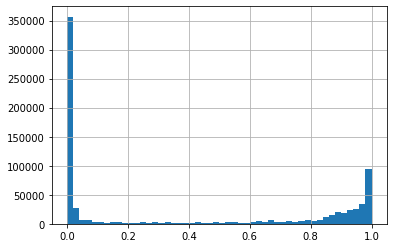

In [12]:
fig, ax = plt.subplots()
df['brand_pct_swf'].hist(bins=50, ax=ax)

In [13]:
df_future = df.loc[df['brand_order_created_date'] > train_test_split_date, :]
df = df.loc[df['brand_order_created_date']< train_test_split_date, :]

In [14]:
df.shape

(348668, 44)

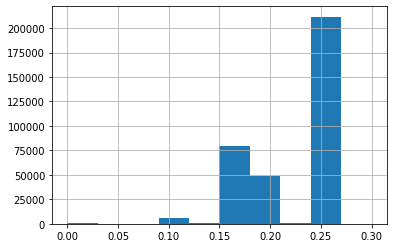

In [15]:
df['first_order_commission'].astype(float).hist()

## EDA

In [16]:
df.head()

,gmv,brand_id,brand_order_created_date,brand_order_id,brand_location,retailer_location,insider_free_freight,commission,brand_age,retailer_age,...,is_same_state,is_same_division,is_same_region,postal_zone,brand_pct_swf,brand_pct_usps,brand_pct_ups,brand_pct_fedex,brand_pct_other,avg_weight_of_products
0,210.0000,396,2017-02-21 02:07:22,93,New England,Pacific West,0.0000,0E-10,New,Mature,...,0.0,0.0,0.0,8,0.000000,0.022222,0.000000,0.966667,0.011111,2.002188
1,438.0000,4198,2017-11-27 22:31:25,5202,Pacific West,Unknown,0.0000,65.7000000000,Mature,New,...,NaN,NaN,NaN,None,0.007853,0.159686,0.827225,0.001309,0.011780,1.190212
2,161.0000,4198,2018-01-20 00:24:30,9897,Pacific West,Unknown,0.0000,24.1500000000,Mature,New,...,NaN,NaN,NaN,None,0.007853,0.159686,0.827225,0.001309,0.011780,1.190212
3,216.0000,6881,2018-02-26 15:58:21,14625,Northeast Midwest,South East,0.0000,32.4000000000,Mature,New,...,0.0,0.0,0.0,4,0.000000,0.029727,0.001189,0.953627,0.003567,1.109405
4,464.9400,10036,2018-04-02 02:51:58,19606,Unknown,Northwest Midwest,0.0000,116.2350000000,New,Mature,...,NaN,NaN,NaN,None,0.000000,0.000000,0.000000,0.000000,0.000000,1.755226


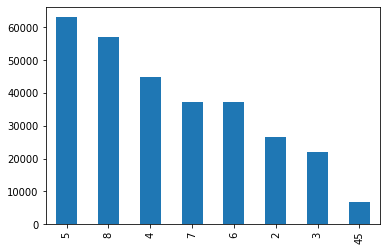

In [17]:
df['postal_zone'].value_counts().plot(kind='bar')

In [18]:
df.dtypes

gmv                                             object
brand_id                                         int64
brand_order_created_date                datetime64[ns]
brand_order_id                                   int64
brand_location                                  object
retailer_location                               object
insider_free_freight                            object
commission                                      object
brand_age                                       object
retailer_age                                    object
primary_brand_category                          object
primary_retailer_category                       object
brand_order_type                                object
insider_subscriber                              object
retailer_store_type                             object
freight_type                                    object
number_of_stockists                             object
primary_brand_sub_category                      object
is_elevate

#### Columns with NAs

In [19]:
(df.isna().sum()/df.shape[0]).loc[df.isna().sum()/df.shape[0] > 0.05]

retailer_address_type    0.083604
is_same_state            0.155317
is_same_division         0.155317
is_same_region           0.155317
postal_zone              0.155317
dtype: float64

45 is Puerto Rico I think. Notice it's key to get rid of 7, 8 and 45.

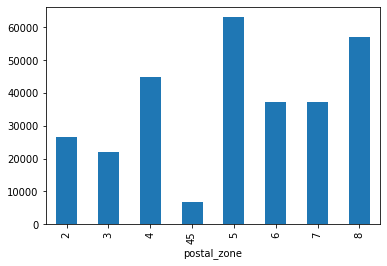

In [20]:
df.groupby('postal_zone')['brand_order_id'].nunique().plot(kind='bar')

Free 1.2% CM improvement if zones 7, 8 and 45 are removed:

In [21]:
df.shape

(348668, 44)

In [22]:
df.loc[df['postal_zone'].notna(), :].shape

(294514, 44)

In [23]:
df.loc[(df['postal_zone'].notna()) 
       & (df['postal_zone'] != '6')
       & (df['postal_zone'] != '7')
       & (df['postal_zone'] != '8')
       & (df['postal_zone'] != '45')
       , :].shape[0] / df.shape[0]

0.448194270767607

In [24]:
df.columns

Index(['gmv', 'brand_id', 'brand_order_created_date', 'brand_order_id',
       'brand_location', 'retailer_location', 'insider_free_freight',
       'commission', 'brand_age', 'retailer_age', 'primary_brand_category',
       'primary_retailer_category', 'brand_order_type', 'insider_subscriber',
       'retailer_store_type', 'freight_type', 'number_of_stockists',
       'primary_brand_sub_category', 'is_elevate_order',
       'first_order_commission', 'is_ship_with_faire',
       'total_shipping_cost_dollars', 'net_faire_shipping_cost_dollars',
       'returned_gmv_dollars', 'maker_paid_shipping_dollars', 'is_cured',
       'is_rr_cured', 'coalesced_shipping_cost_dollars',
       'micro_avg_net_shipping_cost_fraction', 'retailer_state',
       'retailer_postal_code', 'retailer_address_type', 'brand_state',
       'brand_postal_code', 'is_same_state', 'is_same_division',
       'is_same_region', 'postal_zone', 'brand_pct_swf', 'brand_pct_usps',
       'brand_pct_ups', 'brand_pct_fedex', 

In [25]:
df.loc[df['insider_free_freight']>0, ['postal_zone', 'insider_free_freight']].groupby('postal_zone').sum()

,insider_free_freight
postal_zone,
2,69433.9200
3,66020.9900
4,128350.6000
45,27422.3300
5,202237.9100
6,129658.9500
7,138144.3300
8,230362.0200


In [26]:
df.loc[df['insider_free_freight']>0, ['postal_zone', 'gmv']].groupby('postal_zone').sum()

,gmv
postal_zone,
2,1213363.9600
3,1006709.8800
4,1807145.3900
45,240325.5200
5,2675645.8700
6,1579342.3800
7,1558066.3700
8,2449309.9700


### Macro avg shipping cost differences (which we care about):

In [27]:
# zone 2
101463/1726963.7350

0.05875224704704062

In [28]:
# zone 4
184528.7400 / 2585514.0000

0.07137023431317718

In [29]:
# zone 7
194403.6800 / 2196887.2585

0.08849051276884175

In [30]:
# zone 8
330739.2400 / 3519325.2090

0.09397802713832691

Thus we have 3.5pp difference from Zone 2 to Zone 8 and 2.2 from Zone 4 to Zone 9!

#### and micro_avg differences:

In [31]:
df.loc[(df['postal_zone'].notna())
       & (df['insider_free_freight']>0)
       , :].groupby('postal_zone')['insider_free_freight']

In [32]:
df.loc[(df['postal_zone'].notna()) 
#        & (df['postal_zone'] != '6')
       & (df['postal_zone'] != '7')
       & (df['postal_zone'] != '8')
       & (df['postal_zone'] != '45')
       & (df['insider_free_freight']>0)
       , 'insider_free_freight'].mean()

17.38261949226729

In [33]:
df.loc[(df['postal_zone'].notna())
       & (df['insider_free_freight']>0)
       , 'insider_free_freight'].mean()

19.201654628894527

In [34]:
df.loc[(df['postal_zone'].notna()) 
       & (df['postal_zone'] != '7')
       & (df['postal_zone'] != '8')
       & (df['postal_zone'] != '45')
       & (df['insider_free_freight']>0)
       , 'insider_free_freight'].median()

12.565000000000001

## Group by to calculate historical brand_state GMV

TODO: remake this based on past few months

In [35]:
df[['brand_id', 'retailer_state', 'gmv']].dtypes

brand_id           int64
retailer_state    object
gmv               object
dtype: object

In [36]:
df['gmv'] = df['gmv'].astype(float)

In [37]:
df_b_s_gmv = (df.groupby(['brand_id', 'retailer_state'])['gmv'].sum() / df['gmv'].sum() ).reset_index()

In [38]:
df_b_s_gmv.head()

,brand_id,retailer_state,gmv
0,3,AL,0.000003
1,3,AR,0.000004
2,3,CA,0.000006
3,3,CO,0.000003
4,3,FL,0.000001


#### Adding it back to main dataframe

In [39]:
df.shape

(348668, 44)

In [40]:
df = df.merge(df_b_s_gmv, on=['brand_id', 'retailer_state'])

In [41]:
df.shape

(348663, 45)

In [42]:
df['historical_gmv_fraction'] = df['gmv_y']
df['gmv'] = df['gmv_x']
df.drop(columns=['gmv_x', 'gmv_y'], inplace=True)

Add it to future df

In [43]:
df.columns.tolist()

['brand_id',
 'brand_order_created_date',
 'brand_order_id',
 'brand_location',
 'retailer_location',
 'insider_free_freight',
 'commission',
 'brand_age',
 'retailer_age',
 'primary_brand_category',
 'primary_retailer_category',
 'brand_order_type',
 'insider_subscriber',
 'retailer_store_type',
 'freight_type',
 'number_of_stockists',
 'primary_brand_sub_category',
 'is_elevate_order',
 'first_order_commission',
 'is_ship_with_faire',
 'total_shipping_cost_dollars',
 'net_faire_shipping_cost_dollars',
 'returned_gmv_dollars',
 'maker_paid_shipping_dollars',
 'is_cured',
 'is_rr_cured',
 'coalesced_shipping_cost_dollars',
 'micro_avg_net_shipping_cost_fraction',
 'retailer_state',
 'retailer_postal_code',
 'retailer_address_type',
 'brand_state',
 'brand_postal_code',
 'is_same_state',
 'is_same_division',
 'is_same_region',
 'postal_zone',
 'brand_pct_swf',
 'brand_pct_usps',
 'brand_pct_ups',
 'brand_pct_fedex',
 'brand_pct_other',
 'avg_weight_of_products',
 'historical_gmv_fractio

In [44]:
df_future.loc[:, 'historical_gmv_fraction'] = df_future.merge(df[['brand_id',
                                                           'retailer_state',
                                                           'historical_gmv_fraction']],
                                                       on=['brand_id', 'retailer_state'],
                                                       how='left'
                                                      )

In [45]:
df_future.head()

,gmv,brand_id,brand_order_created_date,brand_order_id,brand_location,retailer_location,insider_free_freight,commission,brand_age,retailer_age,...,is_same_division,is_same_region,postal_zone,brand_pct_swf,brand_pct_usps,brand_pct_ups,brand_pct_fedex,brand_pct_other,avg_weight_of_products,historical_gmv_fraction
19688,87.5000,21414,2019-08-02 19:36:43,430170,South Atlantic,South Atlantic,7.7100,13.1250000000,Mature,Mature,...,1.0,1.0,2,0.949275,0.391304,0.315217,0.293478,0.000000,1.526492,0.000044
19689,110.0000,39532,2019-08-06 03:31:35,435524,Middle Atlantic,Pacific West,0.0000,0E-10,New,New,...,0.0,0.0,8,0.000000,0.034106,0.949523,0.000000,0.016371,1.600316,0.000013
21148,228.0000,13718,2019-08-01 18:28:54,428192,Northeast Midwest,Unknown,0.0000,6.9000000000,Mature,Mature,...,0.0,0.0,5,0.889237,0.985371,0.005225,0.001045,0.008359,1.718319,0.001189
22508,124.7500,45063,2019-08-02 12:50:31,429406,New England,Northwest Midwest,0.0000,34.9300000000,New,Mature,...,0.0,0.0,6,1.000000,0.704918,0.278689,0.016393,0.000000,1.414024,0.000217
22509,448.5000,2975,2019-08-05 18:18:05,434393,New England,South Atlantic,12.0000,80.7300000000,Mature,Mature,...,0.0,0.0,5,0.947195,0.834983,0.003300,0.158416,0.003300,1.252199,0.000217


In [46]:
(df.groupby(['brand_id', 'retailer_state'])['historical_gmv_fraction'].mean()).sum()

0.9999837436107215

In [47]:
df.columns

Index(['brand_id', 'brand_order_created_date', 'brand_order_id',
       'brand_location', 'retailer_location', 'insider_free_freight',
       'commission', 'brand_age', 'retailer_age', 'primary_brand_category',
       'primary_retailer_category', 'brand_order_type', 'insider_subscriber',
       'retailer_store_type', 'freight_type', 'number_of_stockists',
       'primary_brand_sub_category', 'is_elevate_order',
       'first_order_commission', 'is_ship_with_faire',
       'total_shipping_cost_dollars', 'net_faire_shipping_cost_dollars',
       'returned_gmv_dollars', 'maker_paid_shipping_dollars', 'is_cured',
       'is_rr_cured', 'coalesced_shipping_cost_dollars',
       'micro_avg_net_shipping_cost_fraction', 'retailer_state',
       'retailer_postal_code', 'retailer_address_type', 'brand_state',
       'brand_postal_code', 'is_same_state', 'is_same_division',
       'is_same_region', 'postal_zone', 'brand_pct_swf', 'brand_pct_usps',
       'brand_pct_ups', 'brand_pct_fedex', 'brand_

## Convert Data Types

In [48]:
df.dtypes.loc[df.dtypes=='object']

brand_location                     object
retailer_location                  object
insider_free_freight               object
commission                         object
brand_age                          object
retailer_age                       object
primary_brand_category             object
primary_retailer_category          object
brand_order_type                   object
insider_subscriber                 object
retailer_store_type                object
freight_type                       object
number_of_stockists                object
primary_brand_sub_category         object
first_order_commission             object
total_shipping_cost_dollars        object
net_faire_shipping_cost_dollars    object
returned_gmv_dollars               object
maker_paid_shipping_dollars        object
coalesced_shipping_cost_dollars    object
retailer_state                     object
retailer_postal_code               object
retailer_address_type              object
brand_state                       

#### Floats

In [49]:
to_float_cols = [
    'commission',
    'first_order_commission',
    'gmv',
    'returns',
    'defaults',
#     'support_credits',
#     'referral_credits',
    'insider_free_freight',
#     'reverse_freight',
#     'redistribution',
#     'loss_on_returns',
#     'pmt_processing_fee',
#     'net_contribution_ex_fees_from_insider_and_opex',
#     'net_cp_ex_insider',
    'total_shipping_cost_dollars', 
    'net_faire_shipping_cost_dollars', 
    'returned_gmv_dollars', 
    'return_order_faire_shipping_cost_dollars', 
    'maker_paid_shipping_dollars', 
#     'swf_profit',
]

In [50]:
for c in to_float_cols:
    if c in df.columns.tolist():
        df[c] = df[c].astype(float)
        df_future[c] = df_future[c].astype(float)

#### Ints

In [51]:
to_int_cols = [
#     'retailer_age',
#     'brand_age',
#     'brand_postal_code',
#     'retailer_postal_code',
    'postal_zone',
]

In [52]:
for c in to_int_cols:
    print(c)
    df[c] = df[c].fillna(-99).astype(int)
    df_future[c] = df_future[c].fillna(-99).astype(int)

postal_zone


### One-Hot-Encode some variables

In [53]:
to_ohe_cols = [
    'freight_type',
    'brand_order_type',
    'primary_brand_category',
    'primary_brand_sub_category',
    'primary_retailer_category',
    'number_of_stockists',
    'retailer_age',
    'brand_age',
    'brand_location',
    'retailer_location',
    'retailer_store_type',
    'retailer_address_type',
    'insider_subscriber',
]

In [54]:
df_ohe = pd.get_dummies(df[to_ohe_cols])
df_future_ohe = pd.get_dummies(df_future[to_ohe_cols])

In [55]:
df.shape

(348663, 45)

In [56]:
df = pd.concat([df, df_ohe], axis=1)
df_future = pd.concat([df_future, df_future_ohe], axis=1)

In [57]:
df.shape

(348663, 224)

In [58]:
df.head()

,brand_id,brand_order_created_date,brand_order_id,brand_location,retailer_location,insider_free_freight,commission,brand_age,retailer_age,primary_brand_category,...,retailer_location_South West,retailer_location_Unknown,retailer_store_type_Brick & Mortar Store,retailer_store_type_Online Only,retailer_store_type_Pop Up Store,retailer_store_type_Unknown,retailer_address_type_COMMERCIAL,retailer_address_type_RESIDENTIAL,insider_subscriber_Insider,insider_subscriber_Non-Insider
0,396,2017-02-21 02:07:22,93,New England,Pacific West,0.0,0.0,New,Mature,Home Decor,...,0,0,0,0,0,1,1,0,0,1
1,396,2017-08-02 17:34:52,763,New England,Pacific West,0.0,53.6,Mature,New,Home Decor,...,0,0,0,0,0,1,1,0,0,1
2,396,2017-08-19 18:39:24,872,New England,Pacific West,0.0,40.2,Mature,New,Home Decor,...,0,0,0,0,0,1,0,0,1,0
3,396,2018-01-30 21:51:50,11205,New England,Pacific West,0.0,30.0,Mature,New,Home Decor,...,0,0,1,0,0,0,1,0,0,1
4,396,2018-01-08 22:12:39,8697,New England,Pacific West,0.0,42.8,Mature,Mature,Home Decor,...,0,0,0,0,0,1,1,0,1,0


## Collumns to use in model

In [59]:
df.columns.tolist()

['brand_id',
 'brand_order_created_date',
 'brand_order_id',
 'brand_location',
 'retailer_location',
 'insider_free_freight',
 'commission',
 'brand_age',
 'retailer_age',
 'primary_brand_category',
 'primary_retailer_category',
 'brand_order_type',
 'insider_subscriber',
 'retailer_store_type',
 'freight_type',
 'number_of_stockists',
 'primary_brand_sub_category',
 'is_elevate_order',
 'first_order_commission',
 'is_ship_with_faire',
 'total_shipping_cost_dollars',
 'net_faire_shipping_cost_dollars',
 'returned_gmv_dollars',
 'maker_paid_shipping_dollars',
 'is_cured',
 'is_rr_cured',
 'coalesced_shipping_cost_dollars',
 'micro_avg_net_shipping_cost_fraction',
 'retailer_state',
 'retailer_postal_code',
 'retailer_address_type',
 'brand_state',
 'brand_postal_code',
 'is_same_state',
 'is_same_division',
 'is_same_region',
 'postal_zone',
 'brand_pct_swf',
 'brand_pct_usps',
 'brand_pct_ups',
 'brand_pct_fedex',
 'brand_pct_other',
 'avg_weight_of_products',
 'historical_gmv_fractio

## Slim data before group by brand, state

Don't consider any data before start date

In [60]:
print(start_date)

2017-01-01


In [61]:
df.shape

(348663, 224)

### Apply start date cut

In [62]:
df = df.loc[df['brand_order_created_date']>start_date, :]

## Split interactions into train and test sets

In [63]:
# df_test = df.loc[df['brand_order_created_date']>train_test_split_date, :]
# df means df_train
# df = df.loc[df['brand_order_created_date']<=train_test_split_date, :]

In [64]:
df.shape

(348663, 224)

(0, 150)

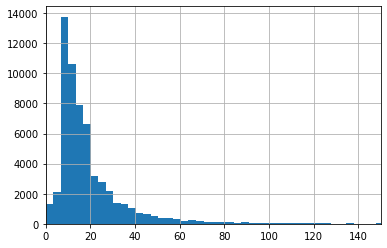

In [65]:
df.loc[df['insider_free_freight']>0, 'insider_free_freight'].hist(bins=500)
plt.xlim(0, 150)

`insider_free_freight` is the same as `total_shipping_cost_dollars` when it's an insider order:

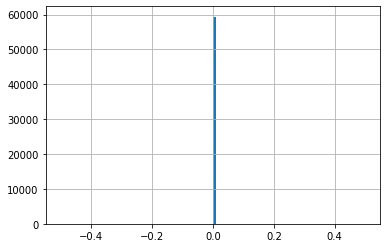

In [66]:
(df.loc[df['insider_free_freight']>0, 'insider_free_freight'] 
 - df.loc[df['insider_free_freight']>0, 'total_shipping_cost_dollars']).hist(bins=100)

In [67]:
slim_cols = [
    'brand_order_id',
    'is_cured',
    'is_rr_cured',
#     'revenue_recognition_date',
    'brand_order_created_date',
#     'first_received_order_created_at',
#     'brand_first_first_active_at',
#     'first_confirmed_order_placed_at',
    'brand_id',
#     'retailer_id',
    'primary_brand_category',
#     'primary_retailer_category',
#     'number_of_stockists',
#     'retailer_age',
#     'brand_age',
#     'brand_order_type',
#     'freight_type',
    'brand_location',
    'avg_weight_of_products', 
    'retailer_location',
#     'brand_first_order_minimum',
#     'summary_channel',
#     'actual_channel',
#     'last_touch_source_signup_conversion',
    'power_retailer',
#     'retailer_qualified_for_terms',
#     'max_retailer_payment_terms_offered',
#     'retailer_min_sales',
#     'retailer_store_type',
#     'insider_subscriber',
    'commission',
    'returns',
    'defaults',
    'support_credits',
    'referral_credits',
    'shipping_rev',
    'swf_profit',
    'insider_free_freight',
    'reverse_freight',
    'redistribution',
    'is_ship_with_faire',
    'loss_on_returns',
    'pmt_processing_fee',
    'net_contribution_ex_fees_from_insider_and_opex',
    'net_cp_ex_insider',
    'cm_ex_fees_from_insider_and_opex',
    'cm_ex_fees_from_insider',
    'is_elevate_order',
    'total_shipping_cost_dollars',
    'net_faire_shipping_cost_dollars',
    'returned_gmv_dollars',
    'return_order_faire_shipping_cost_dollars',
    'maker_paid_shipping_dollars',
    'micro_avg_net_shipping_cost_fraction',
    'retailer_state',
#     'retailer_postal_code',
    'retailer_address_type',
    'brand_state',
#     'brand_postal_code',
    'is_same_state',
    'is_same_division',
    'is_same_region',
    'postal_zone',
    'brand_pct_swf',
    'brand_pct_fedex',
    'brand_pct_ups',
    'brand_pct_usps',
    'historical_gmv_fraction',
    'gmv',
    'freight_type_Freight_Cap',
    'freight_type_Freight_Parity',
    'freight_type_Freight_Profit',
    'freight_type_Insider_Free',
    'freight_type_Not_Yet_Delivered_or_Null',
    'freight_type_Other_Free',
    'brand_order_type_Elevate',
    'brand_order_type_Opening',
    'brand_order_type_Repeat',
    'primary_brand_category_Accessories',
    'primary_brand_category_Beauty',
    'primary_brand_category_Home Decor',
    'primary_brand_category_Jewelry',
    'primary_brand_category_Kids',
    'primary_brand_category_Kitchen',
    'primary_brand_category_Men',
    'primary_brand_category_Other',
    'primary_brand_category_Pets',
    'primary_brand_category_Stationery',
    "primary_brand_category_Women's Apparel",
#     'primary_retailer_category_alcohol',
#     'primary_retailer_category_antique',
#     'primary_retailer_category_arts_crafts',
#     'primary_retailer_category_beauty',
#     'primary_retailer_category_books',
#     'primary_retailer_category_boutique',
#     'primary_retailer_category_bridal',
#     'primary_retailer_category_cafe',
#     'primary_retailer_category_clothing',
#     'primary_retailer_category_clothing_kids',
#     'primary_retailer_category_clothing_men',
#     'primary_retailer_category_clothing_women',
#     'primary_retailer_category_convenience',
#     'primary_retailer_category_fitness',
#     'primary_retailer_category_florist',
#     'primary_retailer_category_furniture',
#     'primary_retailer_category_gift',
#     'primary_retailer_category_grocery',
#     'primary_retailer_category_hardware',
#     'primary_retailer_category_health',
#     'primary_retailer_category_home',
#     'primary_retailer_category_hotel',
#     'primary_retailer_category_jewelry',
#     'primary_retailer_category_lawn_garden',
#     'primary_retailer_category_luggage_bags',
#     'primary_retailer_category_medical',
#     'primary_retailer_category_mercantile_general',
#     'primary_retailer_category_museum',
#     'primary_retailer_category_not found',
#     'primary_retailer_category_office',
#     'primary_retailer_category_other',
#     'primary_retailer_category_pet',
#     'primary_retailer_category_pharmacy',
#     'primary_retailer_category_restaurant_takeaway',
#     'primary_retailer_category_shoes',
#     'primary_retailer_category_skincare',
#     'primary_retailer_category_spa_salon',
#     'primary_retailer_category_specialty_food',
#     'primary_retailer_category_sport_outdoors',
#     'primary_retailer_category_stationery',
#     'primary_retailer_category_toy',
#     'primary_retailer_category_vintage_consignment',
#     'primary_retailer_category_yoga_workout',
    'number_of_stockists_1001-2000',
    'number_of_stockists_2001-10000',
    'number_of_stockists_251-1000',
    'number_of_stockists_51-250',
    'number_of_stockists_<=50',
    'number_of_stockists_Unknown',
#     'retailer_age_Mature',
#     'retailer_age_New',
    'brand_age_Mature',
    'brand_age_New',
    'brand_location_Canada',
    'brand_location_Middle Atlantic',
    'brand_location_New England',
    'brand_location_Northeast Midwest',
    'brand_location_Northwest Midwest',
    'brand_location_Pacific West',
    'brand_location_South Atlantic',
    'brand_location_South East',
    'brand_location_South West',
    'brand_location_Unknown',
    'retailer_location_Canada',
    'retailer_location_Middle Atlantic',
    'retailer_location_New England',
    'retailer_location_Northeast Midwest',
    'retailer_location_Northwest Midwest',
    'retailer_location_Pacific West',
    'retailer_location_South Atlantic',
    'retailer_location_South East',
    'retailer_location_South West',
    'retailer_location_Unknown',
    'retailer_address_type_RESIDENTIAL',
    'retailer_address_type_COMMERCIAL',
#     'retailer_store_type_Brick & Mortar Store',
#     'retailer_store_type_Online Only',
#     'retailer_store_type_Pop Up Store',
#     'retailer_store_type_Unknown',
    'insider_subscriber_Insider',
    'insider_subscriber_Non-Insider',
    'first_order_commission',
    'coalesced_shipping_cost_dollars',
]

In [68]:
slim_cols = [x for x in slim_cols if x in df.columns.tolist()]
df = df[slim_cols]

In [69]:
df_future = df_future[slim_cols]

In [70]:
df.shape

(348663, 85)

## Group by brand and retailer_state

- Add mean of CM and Insider freight fractions
- Count orders to that state

### Build grouped_by dataframe from cartesian product of brands and states:

In [71]:
a = df['brand_id'].unique().tolist()
b = df['retailer_state'].unique().tolist()

index = pd.MultiIndex.from_product([a, b], names = ["brand_id", "retailer_state"])

df_unlabeled = pd.DataFrame(index = index).reset_index()
df_gb = df_unlabeled.copy()

In [72]:
num_unique_brands = df_gb['brand_id'].nunique()
num_unique_rstates = df_gb['retailer_state'].nunique()
print('# of brands:', num_unique_brands)
print('# of states:', num_unique_rstates)
print('df_gb shape:', df_gb.shape)
print('# of rows from index product:', num_unique_brands * num_unique_rstates)

# of brands: 5190
# of states: 63
df_gb shape: (326970, 2)
# of rows from index product: 326970


In [73]:
df_gb.drop_duplicates().shape[0]

326970

In [74]:
df_gb = df_gb.merge(df[['brand_id','retailer_state', 'historical_gmv_fraction']].drop_duplicates(), 
                    on=['brand_id', 'retailer_state'],
                    how='left'
                   )

In [75]:
df_gb['historical_gmv_fraction'] = df_gb['historical_gmv_fraction'].fillna(0) 

In [76]:
df_gb['historical_gmv_fraction'].sum()

0.9999837436107218

In [77]:
df_gb.drop_duplicates().shape[0]

326970

In [78]:
df_gb.shape[0]

326970

In [79]:
df_gb['historical_gmv_fraction'].sum()

0.9999837436107218

In [80]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction
0,396,CA,0.000257
1,396,ME,0.000010
2,396,TX,0.000031
3,396,MS,0.000004
4,396,MN,0.000040


### Create separate brand features df for easier merge later:

Brand features like carrier usage, age, etc

In [81]:
# df[['brand_id', 'brand_age_New']].head(20)

In [82]:
brand_features = [
    'brand_pct_swf',
    'avg_weight_of_products', 
    'first_order_commission',
    'brand_pct_fedex',
    'brand_pct_ups',
    'brand_pct_usps',
    'brand_location',
    'brand_state',
    'brand_location_Canada',
    'brand_location_Middle Atlantic',
    'brand_location_New England',
    'brand_location_Northeast Midwest',
    'brand_location_Northwest Midwest',
    'brand_location_Pacific West',
    'brand_location_South Atlantic',
    'brand_location_South East',
    'brand_location_South West',
    'brand_location_Unknown',
    'number_of_stockists_1001-2000',
    'number_of_stockists_2001-10000',
    'number_of_stockists_251-1000',
    'number_of_stockists_51-250',
    'number_of_stockists_<=50',
    'primary_brand_category',
    'primary_brand_category_Accessories',
    'primary_brand_category_Beauty',
    'primary_brand_category_Home Decor',
    'primary_brand_category_Jewelry',
    'primary_brand_category_Kids',
    'primary_brand_category_Kitchen',
    'primary_brand_category_Men',
    'primary_brand_category_Other',
    'primary_brand_category_Pets',
    'primary_brand_category_Stationery',
    "primary_brand_category_Women's Apparel",
]

In [83]:
df_brand = df[['brand_id'] + brand_features].drop_duplicates()

In [84]:
df_brand.shape

(5190, 36)

In [85]:
df_brand.drop_duplicates().shape

(5190, 36)

In [86]:
df_brand.head()

,brand_id,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,brand_state,brand_location_Canada,...,primary_brand_category_Beauty,primary_brand_category_Home Decor,primary_brand_category_Jewelry,primary_brand_category_Kids,primary_brand_category_Kitchen,primary_brand_category_Men,primary_brand_category_Other,primary_brand_category_Pets,primary_brand_category_Stationery,primary_brand_category_Women's Apparel
0,396,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,MA,0,...,0,1,0,0,0,0,0,0,0,0
66,4198,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,CO,0,...,0,0,0,0,1,0,0,0,0,0
166,6881,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,IN,0,...,1,0,0,0,0,0,0,0,0,0
194,10036,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,None,0,...,0,0,0,0,0,0,1,0,0,0
201,7569,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,OH,0,...,0,0,0,0,0,0,0,0,1,0


Add average `maker_paid_shipping_dollars` for SwF orders because that's extra cost

In [87]:
# df_brand['extra_shipping_cost_dollars'] = df.loc[
#     df['is_ship_with_faire']==true, :
# ].groupby('brand_id')['maker_paid_shipping_dollars'].sum()

In [88]:
df_brand = df_brand.loc[df_brand['brand_location']!='Canada', :]

In [89]:
df_gb = df_gb.merge(df_brand, on='brand_id', how='inner')

In [90]:
df_gb['historical_gmv_fraction'].sum()

0.97920985951769

In [91]:
df_gb.drop_duplicates()['historical_gmv_fraction'].sum()

0.97920985951769

In [92]:
num_unique_brands = df_gb['brand_id'].nunique()
num_unique_rstates = df_gb['retailer_state'].nunique()
print('# of brands:', num_unique_brands)
print('# of states:', num_unique_rstates)
print('df_gb shape:', df_gb.shape)
print('# of rows from index product:', num_unique_brands * num_unique_rstates)

# of brands: 5063
# of states: 63
df_gb shape: (318969, 38)
# of rows from index product: 318969


### A few easy features to engineer (consider doing in SQL)

In [93]:
df_gb['is_HI'] = df_gb[['brand_state', 'retailer_state']].apply(
    lambda x: 1 if (x['retailer_state'] == 'HI' or x['brand_state'] == 'HI') else 0
    , axis=1
)

In [94]:
df_gb['is_AK'] = df_gb[['brand_state', 'retailer_state']].apply(
    lambda x: 1 if (x['retailer_state'] == 'AK' or x['brand_state'] == 'AK') else 0
    , axis=1
)

In [95]:
df_gb['same_state'] = df_gb[['brand_state', 'retailer_state']].apply(
    lambda x: 1 if x['brand_state'] == x['retailer_state'] else 0
    , axis=1
)

In [96]:
df_gb.columns.tolist()

['brand_id',
 'retailer_state',
 'historical_gmv_fraction',
 'brand_pct_swf',
 'avg_weight_of_products',
 'first_order_commission',
 'brand_pct_fedex',
 'brand_pct_ups',
 'brand_pct_usps',
 'brand_location',
 'brand_state',
 'brand_location_Canada',
 'brand_location_Middle Atlantic',
 'brand_location_New England',
 'brand_location_Northeast Midwest',
 'brand_location_Northwest Midwest',
 'brand_location_Pacific West',
 'brand_location_South Atlantic',
 'brand_location_South East',
 'brand_location_South West',
 'brand_location_Unknown',
 'number_of_stockists_1001-2000',
 'number_of_stockists_2001-10000',
 'number_of_stockists_251-1000',
 'number_of_stockists_51-250',
 'number_of_stockists_<=50',
 'primary_brand_category',
 'primary_brand_category_Accessories',
 'primary_brand_category_Beauty',
 'primary_brand_category_Home Decor',
 'primary_brand_category_Jewelry',
 'primary_brand_category_Kids',
 'primary_brand_category_Kitchen',
 'primary_brand_category_Men',
 'primary_brand_category

In [97]:
num_unique_brands = df_gb['brand_id'].nunique()
num_unique_rstates = df_gb['retailer_state'].nunique()
print('# of brands:', num_unique_brands)
print('# of states:', num_unique_rstates)
print('df_gb shape:', df_gb.shape)
print('# of rows from index product:', num_unique_brands * num_unique_rstates)

# of brands: 5063
# of states: 63
df_gb shape: (318969, 41)
# of rows from index product: 318969


### Start feature engineering from group by 

In [98]:
df_gb.shape

(318969, 41)

In [99]:
df_temp = df.groupby(['brand_id', 'retailer_state'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_brand_orders_to_state']

df_gb = df_gb.merge(df_temp, on=['brand_id', 'retailer_state'], how='left')

In [100]:
df_gb.loc[:, 'num_brand_orders_to_state'] = df_gb['num_brand_orders_to_state'].fillna(0)

In [101]:
df_temp = df.groupby(['brand_id'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_brand_orders']

df_gb = df_gb.merge(df_temp, on=['brand_id'], how='left')

In [102]:
df_temp = df.loc[df['is_cured']==1, :].groupby(['brand_id'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_cured_brand_orders']

df_gb = df_gb.merge(df_temp, on=['brand_id'], how='left')

In [103]:
df_temp = df.loc[df['is_rr_cured']==1, :].groupby(['brand_id'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_rr_cured_brand_orders']

df_gb = df_gb.merge(df_temp, on=['brand_id'], how='left')

In [104]:
df_gb.loc[:, 'num_brand_orders_to_state'] = df_gb['num_brand_orders_to_state'].fillna(0)
df_gb.loc[:, 'num_brand_orders'] = df_gb['num_brand_orders'].fillna(0)
df_gb.loc[:, 'num_cured_brand_orders'] = df_gb['num_cured_brand_orders'].fillna(0)
df_gb.loc[:, 'num_rr_cured_brand_orders'] = df_gb['num_rr_cured_brand_orders'].fillna(0)

### Only do brands with at least 4 cured orders

*NOTE*: replace this with cured orders

In [105]:
df_gb['brand_id'].nunique()

5063

In [106]:
num_unique_brands = df_gb['brand_id'].nunique()
num_unique_rstates = df_gb['retailer_state'].nunique()
print('# of brands:', num_unique_brands)
print('# of states:', num_unique_rstates)
print('df_gb shape:', df_gb.shape)
print('# of rows from index product:', num_unique_brands * num_unique_rstates)

# of brands: 5063
# of states: 63
df_gb shape: (318969, 45)
# of rows from index product: 318969


#### Only use shipment cured brands 

In [107]:
# df_gb = df_gb.loc[df_gb['num_brand_orders']>=4, :]
# df_gb = df_gb.loc[df_gb['num_cured_brand_orders']>=4, :]

In [108]:
df_gb['brand_id'].nunique()

5063

In [109]:
# df_gb_test = df.groupby(['brand_id', 'retailer_state'])['brand_order_id'].nunique().reset_index()
# df_gb_test.columns = df_gb_test.columns.tolist()[:-1] + ['num_brand_orders_to_state']

In [110]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,primary_brand_category_Pets,primary_brand_category_Stationery,primary_brand_category_Women's Apparel,is_HI,is_AK,same_state,num_brand_orders_to_state,num_brand_orders,num_cured_brand_orders,num_rr_cured_brand_orders
0,396,CA,0.000257,0.0,2.002188,0.15,0.966667,0.0,0.022222,New England,...,0,0,0,0,0,0,66.0,354,354,354
1,396,ME,0.000010,0.0,2.002188,0.15,0.966667,0.0,0.022222,New England,...,0,0,0,0,0,0,3.0,354,354,354
2,396,TX,0.000031,0.0,2.002188,0.15,0.966667,0.0,0.022222,New England,...,0,0,0,0,0,0,6.0,354,354,354
3,396,MS,0.000004,0.0,2.002188,0.15,0.966667,0.0,0.022222,New England,...,0,0,0,0,0,0,1.0,354,354,354
4,396,MN,0.000040,0.0,2.002188,0.15,0.966667,0.0,0.022222,New England,...,0,0,0,0,0,0,8.0,354,354,354


In [111]:
df_gb.shape

(318969, 45)

In [112]:
df_gb = df_gb.drop_duplicates()

In [113]:
df_gb.shape

(318969, 45)

In [114]:
def add_to_df_gb(df_gb,
                 df_full,
                 column,
                 aggtypes = ['mean'],
                 gb_cols = ['brand_id', 'retailer_state'],
                 prefix='bs',
                 how='left',
                 fillna=-99
                ):
    
    if 'mean' in aggtypes:
        df_temp = df_full.groupby(gb_cols)[column].mean().reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['mean_'+prefix+'_'+column]
    if 'num' in aggtypes:
        df_temp = df_full.groupby(gb_cols)[column].nunique().reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_'+prefix+'_'+column]
    if 'sum' in aggtypes:
        df_temp = df_full.groupby(gb_cols)[column].sum().reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['sum_'+prefix+'_'+column]
    if 'mode' in aggtypes:
        df_temp = df_full.loc[df_full['postal_zone']!=-99, :].groupby(gb_cols)[column].agg(
            lambda x:x.value_counts().index[0]
        ).reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['mode_'+prefix+'_'+column]
    
    df_temp = df_temp.loc[:, set(gb_cols + [x+'_'+prefix+'_'+column for x in aggtypes])]
    new_df = df_gb.merge(df_temp, on=gb_cols, how=how)
    
    if how=='left':
#         print(new_df.columns.tolist())
        new_df.loc[:, [x+'_'+prefix+'_'+column for x in aggtypes]].fillna(fillna, inplace=True)
    
    return new_df

### Add the gb features here:

In [115]:
df_temp2 = df[['brand_id', 'retailer_state', 'postal_zone']].head()

df_temp2.groupby(['brand_id', 'retailer_state'])['postal_zone'].agg(lambda x: x.value_counts().index[0]).reset_index()

,brand_id,retailer_state,postal_zone
0,396,CA,8


In [116]:
df_gb.shape

(318969, 45)

In [117]:
# df.groupby(['brand_id', 'retailer_state'])['postal_zone'].agg(
#     lambda x: x.value_counts().index[0]
# )

In [118]:
state_gb_mean_features = [
    'retailer_address_type_RESIDENTIAL',
#     '',
]

In [119]:
brand_state_gb_mean_features = [
    'net_shipping_cost_fraction',
]

In [120]:
brand_gb_sum_features = [
    'maker_paid_shipping_dollars',
    'gmv',
    'returned_gmv_dollars'
]

In [121]:
brand_gb_mean_features = [
    'brand_age_New',
]

In [122]:
brand_gb_countdistinct_features = [
    'brand_order_id',
]

In [123]:
brand_state_gb_sum_features = [
    'total_shipping_cost_dollars',
    'net_faire_shipping_cost_dollars',
    'coalesced_shipping_cost_dollars',
    'gmv',
]

In [124]:
brand_state_gb_mode_features = [
    'postal_zone',
#     '',
]

In [125]:
df_gb.shape

(318969, 45)

In [126]:
for f in state_gb_mean_features:
    df_gb = add_to_df_gb(df_gb, df, f, gb_cols = ['retailer_state'], prefix='s')
#     df_gb_test = add_to_df_gb(df_gb_test, df_test, f, gb_cols = ['retailer_state'], prefix='s')

In [127]:
df_gb.shape

(318969, 46)

In [128]:
for f in brand_state_gb_mode_features:
    df_gb = add_to_df_gb(df_gb, df, f,
                         gb_cols = ['brand_id', 'retailer_state'],
                         aggtypes=['mode'],
                         prefix='bs'
                        )

In [129]:
df.loc[df['brand_id']==51685, 'brand_state']

321304    CA
332853    CA
348627    CA
Name: brand_state, dtype: object

In [130]:
df.shape

(348663, 85)

In [131]:
num_unique_brands = df_gb['brand_id'].nunique()
num_unique_rstates = df_gb['retailer_state'].nunique()
print('# of brands:', num_unique_brands)
print('# of states:', num_unique_rstates)
print('df_gb shape:', df_gb.shape)
print('# of rows from index product:', num_unique_brands * num_unique_rstates)

# of brands: 5063
# of states: 63
df_gb shape: (318969, 47)
# of rows from index product: 318969


### Double check zone distributions

In [132]:
df_gb.loc[(df_gb['brand_state']=='CA') & (df_gb['retailer_state']=='NY'), 'mode_bs_postal_zone'].value_counts()

8.0    457
2.0      8
5.0      7
7.0      4
4.0      3
6.0      3
3.0      3
Name: mode_bs_postal_zone, dtype: int64

In [133]:
df_gb.loc[(df_gb['brand_state']=='IL') & (df_gb['retailer_state']=='NY'), 'mode_bs_postal_zone'].value_counts()

5.0    64
4.0     9
Name: mode_bs_postal_zone, dtype: int64

In [134]:
df_gb.loc[(df_gb['brand_state']=='MA') & (df_gb['retailer_state']=='NY'), 'mode_bs_postal_zone'].value_counts()

3.0    26
2.0    22
4.0     3
5.0     2
8.0     1
Name: mode_bs_postal_zone, dtype: int64

In [135]:
df_gb['mode_bs_postal_zone'].isna().sum()

255595

In [136]:
df_gb['mode_bs_postal_zone'].notna().sum()

63374

In [137]:
df_gb.columns.tolist()

['brand_id',
 'retailer_state',
 'historical_gmv_fraction',
 'brand_pct_swf',
 'avg_weight_of_products',
 'first_order_commission',
 'brand_pct_fedex',
 'brand_pct_ups',
 'brand_pct_usps',
 'brand_location',
 'brand_state',
 'brand_location_Canada',
 'brand_location_Middle Atlantic',
 'brand_location_New England',
 'brand_location_Northeast Midwest',
 'brand_location_Northwest Midwest',
 'brand_location_Pacific West',
 'brand_location_South Atlantic',
 'brand_location_South East',
 'brand_location_South West',
 'brand_location_Unknown',
 'number_of_stockists_1001-2000',
 'number_of_stockists_2001-10000',
 'number_of_stockists_251-1000',
 'number_of_stockists_51-250',
 'number_of_stockists_<=50',
 'primary_brand_category',
 'primary_brand_category_Accessories',
 'primary_brand_category_Beauty',
 'primary_brand_category_Home Decor',
 'primary_brand_category_Jewelry',
 'primary_brand_category_Kids',
 'primary_brand_category_Kitchen',
 'primary_brand_category_Men',
 'primary_brand_category

In [138]:
df_state_locations = df[['retailer_state', 'retailer_location']].drop_duplicates()

In [139]:
df_state_locations = df_state_locations.loc[df_state_locations['retailer_location']!='Unknown', :]

In [140]:
df_state_locations.head()

,retailer_state,retailer_location
0,CA,Pacific West
67,ME,New England
102,TX,South West
166,MS,South East
194,MN,Northwest Midwest


In [141]:
df_state_locations.shape

(61, 2)

In [142]:
df_gb = df_gb.merge(df_state_locations, on='retailer_state')

In [143]:
df_gb['same_location'] = df_gb[['brand_location', 'retailer_location']].apply(
    lambda x: 1 if x['brand_location'] == x['retailer_location'] else 0
    , axis=1
)

#### Impute most likely zone in progressively larger aggregations if RxB pair lacks one

In [144]:
df_temp = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_state', 'retailer_state'],
                       aggtypes=['mode'],
                       prefix='rsbs'
                      )

In [145]:
df_temp2 = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_state', 'retailer_location'],
                       aggtypes=['mode'],
                       prefix='rlbs'
                      )

In [146]:
df_temp3 = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_location', 'retailer_state'],
                       aggtypes=['mode'],
                       prefix='rsbl'
                      )

In [147]:
df_temp4 = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_location', 'retailer_location'],
                       aggtypes=['mode'],
                       prefix='rlbl'
                      )

In [148]:
df_gb['mode_bs_postal_zone'].isna().sum() 

245484

In [149]:
df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp["mode_rsbs_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp2["mode_rlbs_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp3["mode_rsbl_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp4["mode_rlbl_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

In [150]:
df_gb['mode_bs_postal_zone'].isna().sum() 

50630

In [151]:
df_gb.loc[df_gb['mode_bs_postal_zone'].isna()==True, :].head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,is_AK,same_state,num_brand_orders_to_state,num_brand_orders,num_cured_brand_orders,num_rr_cured_brand_orders,mean_s_retailer_address_type_RESIDENTIAL,mode_bs_postal_zone,retailer_location,same_location
111386,396,ON,0.000006,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,0,0,2.0,354,354,354,0.104779,NaN,Canada,0
111387,4198,ON,0.000000,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,0,0,0.0,1166,1166,1166,0.104779,NaN,Canada,0
111388,6881,ON,0.000014,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,0,0,3.0,2041,2041,2041,0.104779,NaN,Canada,0
111389,10036,ON,0.000000,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,0,0,0.0,68,68,68,0.104779,NaN,Canada,0
111390,7569,ON,0.000002,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,0,0,1.0,252,252,252,0.104779,NaN,Canada,0


## Still rows with missing zones due to retailers in Canada. Drop them

In [152]:
df_gb.loc[df_gb['mode_bs_postal_zone'].isna(), 'retailer_state'].value_counts()

YT    5063
AB    5063
SK    5063
BC    5063
NB    5063
MB    5063
NL    5063
ON    5063
QC    5063
NS    5063
Name: retailer_state, dtype: int64

In [153]:
df_gb = df_gb.loc[~df_gb['retailer_state'].isin(['SK','QC', 'YT', 'MB', 'NL', 'BC', 'AB', 'NS', 'NB', 'PE', 'ON']),
                  :
                 ]

In [154]:
df_gb['mode_bs_postal_zone'].isna().sum()

0

Only use SwF for the brand extra cost dollars calculation

In [155]:
df_gb.shape

(258213, 49)

In [156]:
df_gb['historical_gmv_fraction'] = df_gb['historical_gmv_fraction'].fillna(0)

In [157]:
for f in brand_gb_mean_features:
    df_gb = add_to_df_gb(df_gb, df, f, 
                         gb_cols = ['brand_id'], aggtypes=['mean'], prefix='b',
                         how='left',
                         fillna=0.5
                        )

In [158]:
for f in brand_gb_sum_features:
    df_gb = add_to_df_gb(df_gb, df, f, 
                         gb_cols = ['brand_id'], aggtypes=['sum'], prefix='b',
                         how='left',
                         fillna=0
                        )

For extra shipping cost calculation

In [159]:
for f in brand_gb_sum_features:
    df_gb = add_to_df_gb(df_gb, df.loc[df['is_ship_with_faire']==True, :], f, 
                         gb_cols = ['brand_id'], aggtypes=['sum'], prefix='b_swf',
                         how='left',
                         fillna=0
                        )

For return rate calculation

In [160]:
for f in brand_gb_sum_features:
    df_gb = add_to_df_gb(df_gb, df.loc[df['is_rr_cured']==1, :], f, 
                         gb_cols = ['brand_id'], aggtypes=['sum'], prefix='b_rr_cured',
                         how='left',
                         fillna=0
                        )

In [161]:
df_gb.shape

(258213, 59)

In [162]:
for f in brand_gb_countdistinct_features:
    df_gb = add_to_df_gb(df_gb, df, f, 
                         gb_cols = ['brand_id'], aggtypes=['num'], prefix='b')

In [163]:
df_gb.shape

(258213, 60)

In [164]:
df_gb.head(10)

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,sum_b_maker_paid_shipping_dollars,sum_b_gmv,sum_b_returned_gmv_dollars,sum_b_swf_maker_paid_shipping_dollars,sum_b_swf_gmv,sum_b_swf_returned_gmv_dollars,sum_b_rr_cured_maker_paid_shipping_dollars,sum_b_rr_cured_gmv,sum_b_rr_cured_returned_gmv_dollars,num_b_brand_order_id
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,18514.05,125818.20,13287.63,NaN,NaN,NaN,18514.05,125818.20,13287.63,354
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,21040.01,248703.25,18257.00,NaN,NaN,NaN,21040.01,248703.25,18257.00,1166
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,57576.08,620348.50,44455.00,NaN,NaN,NaN,57576.08,620348.50,44455.00,2041
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,5353.00,22250.70,1904.04,NaN,NaN,NaN,5353.00,22250.70,1904.04,68
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,1867.18,34537.80,1521.90,0.0,8572.95,25.5,1867.18,34537.80,1521.90,252
5,7935,CA,0.000065,0.000000,2.392898,0.18,0.622222,0.266667,0.088889,Pacific West,...,1870.36,18305.50,2679.50,NaN,NaN,NaN,1870.36,18305.50,2679.50,94
6,3531,CA,0.000177,0.000000,1.171428,0.15,0.003040,0.972644,0.021277,Northeast Midwest,...,5425.96,107836.25,8317.00,NaN,NaN,NaN,5425.96,107836.25,8317.00,377
7,11712,CA,0.000003,0.142857,1.468205,0.25,0.000000,0.000000,1.000000,Northwest Midwest,...,601.82,7140.00,1596.00,8.0,280.00,0.0,601.82,7140.00,1596.00,24
8,4630,CA,0.001624,0.002426,0.956707,0.15,0.367495,0.000000,0.630685,Pacific West,...,33895.50,711272.00,35218.50,NaN,NaN,NaN,33895.50,711272.00,35218.50,1719
9,9220,CA,0.000121,0.483271,1.852029,0.18,0.825279,0.156134,0.014870,South West,...,18990.29,129005.35,11501.75,0.0,19787.00,423.5,18990.29,129005.35,11501.75,533


In [165]:
df_gb.shape

(258213, 60)

In [166]:
for f in brand_state_gb_sum_features:
    df_gb = add_to_df_gb(df_gb,
                         df,
                         f,
                         gb_cols = ['brand_id', 'retailer_state'],
                         aggtypes=['sum'],
                         prefix='bs'
                        )

In [167]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,sum_b_swf_gmv,sum_b_swf_returned_gmv_dollars,sum_b_rr_cured_maker_paid_shipping_dollars,sum_b_rr_cured_gmv,sum_b_rr_cured_returned_gmv_dollars,num_b_brand_order_id,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,NaN,NaN,18514.05,125818.20,13287.63,354,3577.30,2195.82,3577.3000,21605.00
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,NaN,NaN,21040.01,248703.25,18257.00,1166,2544.40,914.45,2544.4000,32078.75
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,NaN,NaN,57576.08,620348.50,44455.00,2041,5740.70,2843.80,5740.7000,62599.50
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,NaN,NaN,5353.00,22250.70,1904.04,68,505.00,367.73,505.0000,2036.88
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,8572.95,25.5,1867.18,34537.80,1521.90,252,320.14,169.93,320.1400,3111.00


#### Create the macro_averaged features now that the brand_state group by sums have been performed

In [168]:
df_gb['macro_avg_extra_shipping_cost_fraction'] = df_gb['sum_b_swf_maker_paid_shipping_dollars'].astype(float) / df_gb['sum_b_swf_gmv']

df_gb['macro_avg_shipping_cost_fraction'] = df_gb['sum_bs_total_shipping_cost_dollars'].astype(float) / df_gb['sum_bs_gmv']
df_gb['target_shipping_cost_fraction'] = df_gb['sum_bs_coalesced_shipping_cost_dollars'].astype(float) / df_gb['sum_bs_gmv']

df_gb['macro_avg_net_faire_shipping_cost_fraction'] = df_gb['sum_bs_net_faire_shipping_cost_dollars'].astype(float) / df_gb['sum_bs_gmv']

In [169]:
smoothing_strength = 8

df_gb['sum_b_rr_cured_returned_gmv_dollars'] = df_gb['sum_b_rr_cured_returned_gmv_dollars'].fillna(0)

df_gb['macro_avg_return_rate'] = df_gb['sum_b_rr_cured_returned_gmv_dollars'].astype(float) / df_gb['sum_b_rr_cured_gmv']
avg_rr = df_gb[['brand_id', 'macro_avg_return_rate']].drop_duplicates().mean().values[1]

In [170]:
print(avg_rr)

0.12057825656970649


In [171]:
df_gb['num_b_brand_order_id'] = df_gb['num_b_brand_order_id'].fillna(0)

In [172]:
df_gb['num_rr_cured_brand_orders'] = df_gb['num_rr_cured_brand_orders'].fillna(0)

In [173]:
df_gb.loc[:, 'smoothed_return_rate'] = df_gb.apply(
    lambda x: (smoothing_strength * avg_rr + x['num_rr_cured_brand_orders']*x['macro_avg_return_rate']) \
    / (smoothing_strength + x['num_rr_cured_brand_orders']), axis=1
)

In [174]:
df_gb.loc[df_gb['sum_b_gmv'].isna(), 'brand_id'].nunique()

0

In [175]:
df_gb.loc[df_gb['sum_b_gmv'].notna(), 'brand_id'].nunique()

5063

In [176]:
df_gb['macro_avg_return_rate'].isna().sum()

0

In [177]:
df_gb['smoothed_return_rate'].isna().sum()

0

In [178]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv,macro_avg_extra_shipping_cost_fraction,macro_avg_shipping_cost_fraction,target_shipping_cost_fraction,macro_avg_net_faire_shipping_cost_fraction,macro_avg_return_rate,smoothed_return_rate
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,3577.30,2195.82,3577.3000,21605.00,NaN,0.165577,0.165577,0.101635,0.105610,0.105941
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,2544.40,914.45,2544.4000,32078.75,NaN,0.079317,0.079317,0.028506,0.073409,0.073730
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,5740.70,2843.80,5740.7000,62599.50,NaN,0.091705,0.091705,0.045428,0.071661,0.071852
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,505.00,367.73,505.0000,2036.88,NaN,0.247928,0.247928,0.180536,0.085572,0.089257
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,320.14,169.93,320.1400,3111.00,0.0,0.102906,0.102906,0.054622,0.044065,0.046419


#### Cross-check macro average shipping cost increases with zones:

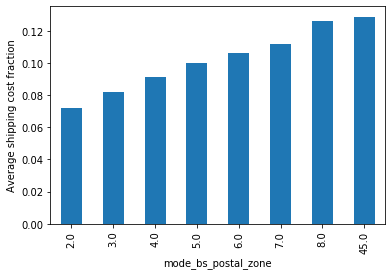

In [179]:
df_gb.groupby('mode_bs_postal_zone')['macro_avg_shipping_cost_fraction'].mean().plot(kind='bar');
plt.ylabel('Average shipping cost fraction');

## Do costs follow expected distributions?

Brands from CA

In [180]:
df_ohe = pd.get_dummies(df_gb['retailer_location'], prefix='retailer_location')
df_gb = pd.concat([df_gb, df_ohe], axis=1)

In [181]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,macro_avg_return_rate,smoothed_return_rate,retailer_location_Middle Atlantic,retailer_location_New England,retailer_location_Northeast Midwest,retailer_location_Northwest Midwest,retailer_location_Pacific West,retailer_location_South Atlantic,retailer_location_South East,retailer_location_South West
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,0.105610,0.105941,0,0,0,0,1,0,0,0
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,0.073409,0.073730,0,0,0,0,1,0,0,0
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,0.071661,0.071852,0,0,0,0,1,0,0,0
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,0.085572,0.089257,0,0,0,0,1,0,0,0
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,0.044065,0.046419,0,0,0,0,1,0,0,0


In [182]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,macro_avg_return_rate,smoothed_return_rate,retailer_location_Middle Atlantic,retailer_location_New England,retailer_location_Northeast Midwest,retailer_location_Northwest Midwest,retailer_location_Pacific West,retailer_location_South Atlantic,retailer_location_South East,retailer_location_South West
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,0.105610,0.105941,0,0,0,0,1,0,0,0
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,0.073409,0.073730,0,0,0,0,1,0,0,0
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,0.071661,0.071852,0,0,0,0,1,0,0,0
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,0.085572,0.089257,0,0,0,0,1,0,0,0
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,0.044065,0.046419,0,0,0,0,1,0,0,0


In [183]:
df_gb.columns

Index(['brand_id', 'retailer_state', 'historical_gmv_fraction',
       'brand_pct_swf', 'avg_weight_of_products', 'first_order_commission',
       'brand_pct_fedex', 'brand_pct_ups', 'brand_pct_usps', 'brand_location',
       'brand_state', 'brand_location_Canada',
       'brand_location_Middle Atlantic', 'brand_location_New England',
       'brand_location_Northeast Midwest', 'brand_location_Northwest Midwest',
       'brand_location_Pacific West', 'brand_location_South Atlantic',
       'brand_location_South East', 'brand_location_South West',
       'brand_location_Unknown', 'number_of_stockists_1001-2000',
       'number_of_stockists_2001-10000', 'number_of_stockists_251-1000',
       'number_of_stockists_51-250', 'number_of_stockists_<=50',
       'primary_brand_category', 'primary_brand_category_Accessories',
       'primary_brand_category_Beauty', 'primary_brand_category_Home Decor',
       'primary_brand_category_Jewelry', 'primary_brand_category_Kids',
       'primary_brand_ca

In [184]:
df_gb.shape[0]

258213

In [185]:
df_gb = df_gb.loc[df_gb['brand_location']!='Canada', :]

In [186]:
df_gb.shape[0]

258213

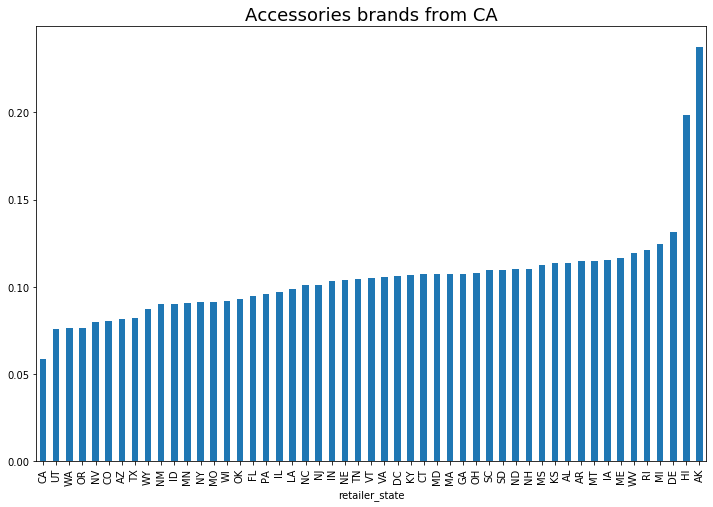

In [187]:
b_state = 'CA'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title(b_cat + ' brands from '+b_state, fontsize=18);

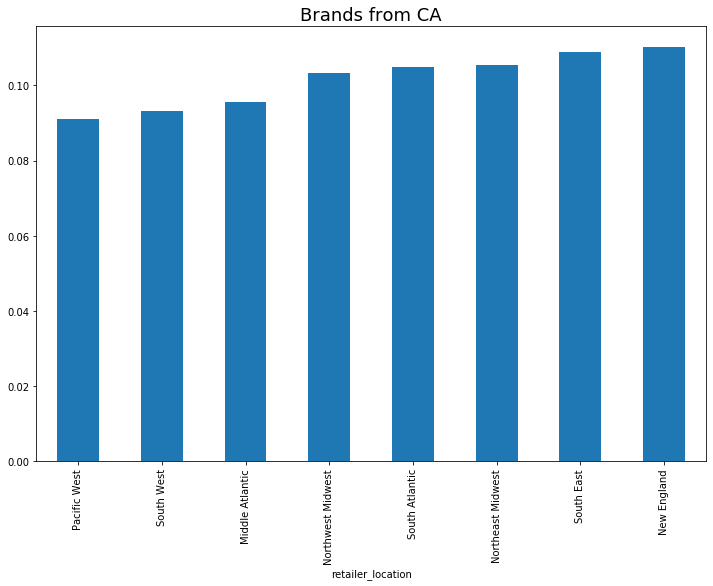

In [188]:
b_state = 'CA'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

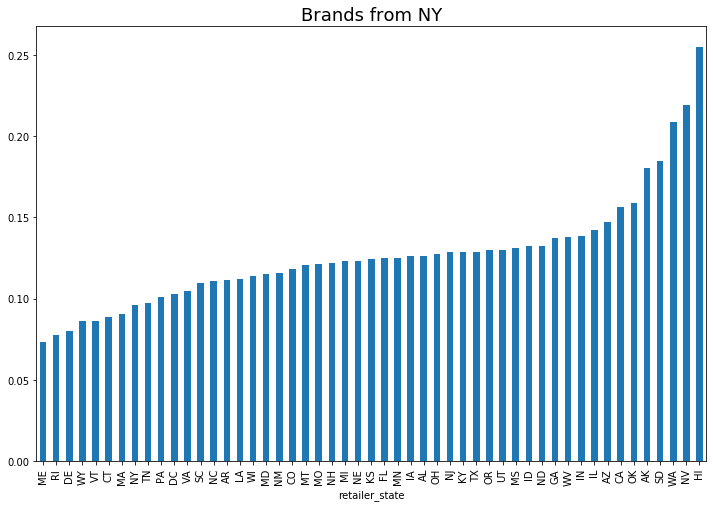

In [189]:
b_state = 'NY'
b_cat = 'Home Decor'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

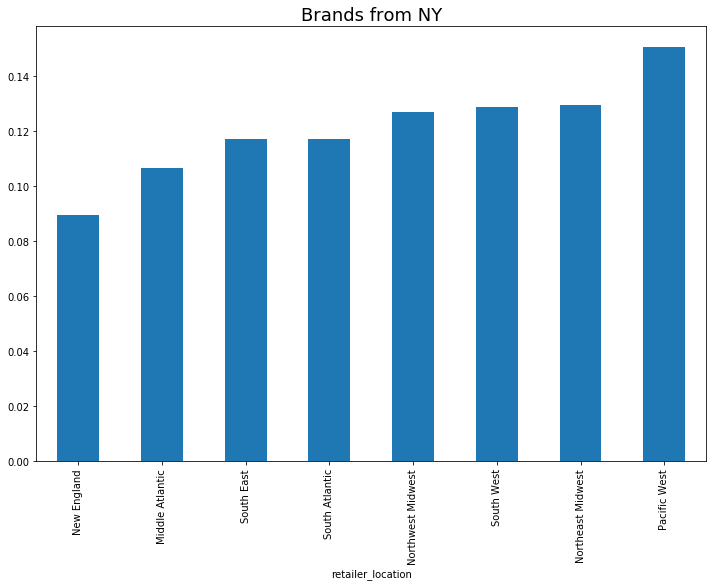

In [190]:
b_state = 'NY'
b_cat = 'Home Decor'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

In [191]:
df_gb['mode_bs_postal_zone'].isna().sum() / df_gb.shape[0]

0.0

In [192]:
df_gb = df_gb.loc[df_gb['mode_bs_postal_zone'].notna(), :]

In [193]:
df_gb['mode_bs_postal_zone'] = df_gb['mode_bs_postal_zone'].astype(int)

In [194]:
df_ohe = pd.get_dummies(df_gb['mode_bs_postal_zone'], prefix='postal_zone')
df_gb = pd.concat([df_gb, df_ohe], axis=1)

In [195]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,retailer_location_South East,retailer_location_South West,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,0,0,0,0,0,0,0,0,1,0
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,0,0,0,0,0,1,0,0,0,0
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,0,0,0,0,0,0,0,0,1,0
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,0,0,0,0,0,0,0,0,1,0
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,0,0,0,0,0,0,0,0,1,0


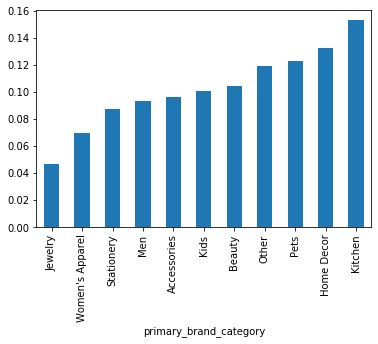

In [196]:
df_gb.groupby('primary_brand_category')['macro_avg_shipping_cost_fraction'].mean().sort_values().plot(kind='bar')

## Declare columns to use

In [197]:
df_gb.columns.tolist()

['brand_id',
 'retailer_state',
 'historical_gmv_fraction',
 'brand_pct_swf',
 'avg_weight_of_products',
 'first_order_commission',
 'brand_pct_fedex',
 'brand_pct_ups',
 'brand_pct_usps',
 'brand_location',
 'brand_state',
 'brand_location_Canada',
 'brand_location_Middle Atlantic',
 'brand_location_New England',
 'brand_location_Northeast Midwest',
 'brand_location_Northwest Midwest',
 'brand_location_Pacific West',
 'brand_location_South Atlantic',
 'brand_location_South East',
 'brand_location_South West',
 'brand_location_Unknown',
 'number_of_stockists_1001-2000',
 'number_of_stockists_2001-10000',
 'number_of_stockists_251-1000',
 'number_of_stockists_51-250',
 'number_of_stockists_<=50',
 'primary_brand_category',
 'primary_brand_category_Accessories',
 'primary_brand_category_Beauty',
 'primary_brand_category_Home Decor',
 'primary_brand_category_Jewelry',
 'primary_brand_category_Kids',
 'primary_brand_category_Kitchen',
 'primary_brand_category_Men',
 'primary_brand_category

#### MVP list of columns

In [198]:
cols_to_use = [
#     'mode_bs_postal_zone',
    'is_AK',
    'is_HI',
    'same_state',
    'avg_weight_of_products', 
    'same_location',
    'postal_zone_2',
    'postal_zone_3',
    'postal_zone_4',
    'postal_zone_5',
    'postal_zone_6',
    'postal_zone_7',
    'postal_zone_8',
    'postal_zone_45',
    'mean_b_brand_age_New',
    'brand_location_Canada',
    'brand_location_Middle Atlantic',
    'brand_location_New England',
    'brand_location_Northeast Midwest',
    'brand_location_Northwest Midwest',
    'brand_location_Pacific West',
    'brand_location_South Atlantic',
    'brand_location_South East',
    'brand_location_South West',
    'brand_location_Unknown',
    'number_of_stockists_1001-2000',
    'number_of_stockists_2001-10000',
    'number_of_stockists_251-1000',
    'number_of_stockists_51-250',
#     'number_of_stockists_<=50',
    'primary_brand_category_Accessories',
    'primary_brand_category_Beauty',
    'primary_brand_category_Home Decor',
    'primary_brand_category_Jewelry',
    'primary_brand_category_Kids',
    'primary_brand_category_Kitchen',
    'primary_brand_category_Men',
    'primary_brand_category_Other',
    'primary_brand_category_Pets',
    'primary_brand_category_Stationery',
    "primary_brand_category_Women's Apparel",
    "macro_avg_extra_shipping_cost_fraction",
    'mean_s_retailer_address_type_RESIDENTIAL',
#     "macro_avg_shipping_cost_fraction",
    'brand_pct_swf',
    'brand_pct_fedex',
    'brand_pct_ups',
    'brand_pct_usps',
#     'brands_historical_shipping_cost_fraction_from_mean'
]

## Regress on mean brand,state CM or shipping_cost_fraction

In [199]:
# target = 'macro_avg_shipping_cost_fraction'
target = 'target_shipping_cost_fraction'
# target = 'cm_per_order_excluding_insider_fees'

In [200]:
# SKLEARN stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [201]:
# [x for x in df_gb.columns.tolist() if x!=target]

In [202]:
df_gb[cols_to_use].isna().sum()

is_AK                                            0
is_HI                                            0
same_state                                       0
avg_weight_of_products                           0
same_location                                    0
postal_zone_2                                    0
postal_zone_3                                    0
postal_zone_4                                    0
postal_zone_5                                    0
postal_zone_6                                    0
postal_zone_7                                    0
postal_zone_8                                    0
postal_zone_45                                   0
mean_b_brand_age_New                             0
brand_location_Canada                            0
brand_location_Middle Atlantic                   0
brand_location_New England                       0
brand_location_Northeast Midwest                 0
brand_location_Northwest Midwest                 0
brand_location_Pacific West    

In [203]:
num_unique_brands = df_gb['brand_id'].nunique()
num_unique_rstates = df_gb['retailer_state'].nunique()
print('# of brands:', num_unique_brands)
print('# of states:', num_unique_rstates)
print('df_gb shape:', df_gb.shape)
print('# of rows from index product:', num_unique_brands * num_unique_rstates)

# of brands: 5063
# of states: 51
df_gb shape: (258213, 86)
# of rows from index product: 258213


## Impute some features with specific strategies:

In [204]:
df_gb['macro_avg_extra_shipping_cost_fraction'] = df_gb['macro_avg_extra_shipping_cost_fraction'].fillna(0)

In [205]:
df_gb['brand_pct_swf'] = df_gb['brand_pct_swf'].fillna(0.43)

In [206]:
df_gb['brand_pct_fedex'] = df_gb['brand_pct_fedex'].fillna(0.33)
df_gb['brand_pct_ups'] = df_gb['brand_pct_ups'].fillna(0.33)
df_gb['brand_pct_usps'] = df_gb['brand_pct_usps'].fillna(0.33)

## Create X_train, X_test and X_future

Remember df_gb is built using only static features and non-future data

In [207]:
# df_with_labels = df_gb.loc[df_gb[target]>0, :]

In [208]:
df_gb_future = df_gb.copy()

### Now just replace the label column and the predictions 
#### predictions are the same unless now training on full 'past' data

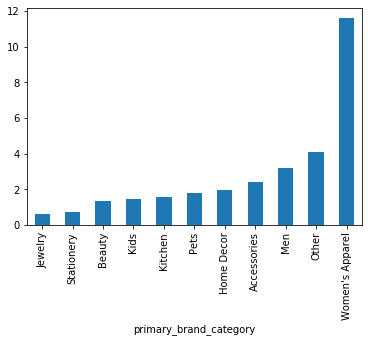

In [209]:
df_future.groupby('primary_brand_category')['avg_weight_of_products'].mean().sort_values().plot(kind='bar')

Remove the previous target columns:

In [210]:
print(brand_state_gb_sum_features)

['total_shipping_cost_dollars', 'net_faire_shipping_cost_dollars', 'coalesced_shipping_cost_dollars', 'gmv']


In [211]:
for c in brand_state_gb_sum_features:
    for cf in df_gb_future.columns.tolist():
        if c in cf:
            print(cf)

sum_bs_total_shipping_cost_dollars
sum_bs_net_faire_shipping_cost_dollars
sum_bs_coalesced_shipping_cost_dollars
historical_gmv_fraction
sum_b_gmv
sum_b_returned_gmv_dollars
sum_b_swf_gmv
sum_b_swf_returned_gmv_dollars
sum_b_rr_cured_gmv
sum_b_rr_cured_returned_gmv_dollars
sum_bs_gmv


In [212]:
df_gb_future.drop(columns = ['sum_bs_total_shipping_cost_dollars',
                             'sum_bs_net_faire_shipping_cost_dollars',
                             'sum_bs_coalesced_shipping_cost_dollars',
                             'sum_b_gmv',
                             'sum_bs_gmv',
                            ], inplace = True)

In [213]:
for f in brand_state_gb_sum_features:
    print(f)
    df_gb_future = add_to_df_gb(df_gb_future,
                         df_future,
                         f, 
                         gb_cols = ['brand_id', 'retailer_state'],
                         aggtypes=['sum'],
                         prefix='bs'
                        )

total_shipping_cost_dollars
net_faire_shipping_cost_dollars
coalesced_shipping_cost_dollars
gmv


In [214]:
df_gb_future.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,0,0,0,0,1,0,586.49,155.49,586.4900,3478.00
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,0,1,0,0,0,0,1024.93,408.03,1024.9300,11766.95
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,0,0,0,0,1,0,1964.81,818.85,1964.8100,20856.75
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,0,0,0,0,1,0,62.44,35.68,62.4400,726.00


#### Create the macro_averaged features now that the brand_state group by sums have been performed

In [215]:
df_gb_future['macro_avg_extra_shipping_cost_fraction'] = df_gb_future['sum_b_swf_maker_paid_shipping_dollars'].astype(float) / df_gb_future['sum_b_swf_gmv']

df_gb_future['macro_avg_shipping_cost_fraction'] = df_gb_future['sum_bs_total_shipping_cost_dollars'].astype(float) / df_gb_future['sum_bs_gmv']
df_gb_future['target_shipping_cost_fraction'] = df_gb_future['sum_bs_coalesced_shipping_cost_dollars'].astype(float) / df_gb_future['sum_bs_gmv']

In [216]:
df_gb_future['macro_avg_net_faire_shipping_cost_fraction'] = \
df_gb_future['sum_bs_net_faire_shipping_cost_dollars'].astype(float) / df_gb_future['sum_bs_gmv']

In [217]:
df_gb_future['macro_avg_extra_shipping_cost_fraction'] = df_gb_future['macro_avg_extra_shipping_cost_fraction'].fillna(0)

#### Option to target future shipping cost

In [218]:
print(target)

target_shipping_cost_fraction


In [219]:
# df_gb_future.columns.tolist()

In [220]:
if target_future_scf == True:
    df_gb['past_'+target] = df_gb[target]
    df_gb.drop(columns=[target], inplace=True)
    df_gb = df_gb.merge(df_gb_future[['brand_id', 'retailer_state', target]], 
                        on=['brand_id', 'retailer_state']
                       )
    
    cols_to_use = cols_to_use + ['past_'+target]

In [221]:
df_temp = df_gb[['primary_brand_category', 'past_'+target]].groupby(
    'primary_brand_category'
)['past_'+target].mean().reset_index()

In [222]:
df_temp.loc[df_temp['primary_brand_category']=='Beauty', 'past_target_shipping_cost_fraction'].values[0]

0.1039432661659289

Impute the mean of the category

In [223]:
for c in df_temp['primary_brand_category'].unique().tolist():
    df_gb.loc[(df_gb['primary_brand_category']==c), 'past_'+target] = \
    df_gb.loc[(df_gb['primary_brand_category']==c), 'past_'+target].fillna(
        df_temp.loc[df_temp['primary_brand_category']==c, 'past_'+target].values[0]
    )

In [224]:
df_with_labels = df_gb.loc[df_gb[target]>0, :]

In [225]:
print(target)

target_shipping_cost_fraction


In [226]:
df_gb_future = df_gb_future.loc[df_gb_future[target].notna(), :]

In [227]:
df_gb_future[target].isna().sum()

0

In [228]:
df_gb_future[target].notna().sum()

69285

In [229]:
df_with_labels['mode_bs_postal_zone'].value_counts()

5     16569
8     13426
4     10282
6      9221
7      9127
3      4505
2      4463
45     1372
Name: mode_bs_postal_zone, dtype: int64

In [230]:
df_gb_future['mode_bs_postal_zone'].value_counts()

5     16627
8     13475
4     10322
6      9259
7      9159
2      4540
3      4525
45     1378
Name: mode_bs_postal_zone, dtype: int64

In [231]:
y_future = df_gb_future[target]

## Simple split on brand, retailer_state 
### eventually don't do it once split is in time axis

In [232]:
split_size = 0.15

df_train, df_test, y_train, y_test = \
train_test_split(df_with_labels[[x for x in df_with_labels.columns.tolist() if x!=target]],
                 df_with_labels[target],
                 test_size=split_size
                )

In [233]:
df_train.shape

(58620, 86)

In [234]:
df_test.shape

(10345, 86)

In [235]:
X_train = df_train[cols_to_use]
X_test = df_test[cols_to_use]

In [236]:
X_train.shape

(58620, 46)

In [237]:
# df_train.corr()['macro_avg_shipping_cost_fraction'].sort_values()

## LinearRegression

In [238]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [239]:
std_scaling = StandardScaler() 
# algo = LinearRegression()
algo = Ridge()

steps = [
#             ('std_scaling', StandardScaler()), 
            ('algo', algo)
        ]
pipeline = Pipeline(steps)

parameters = {
                'algo__normalize': [False]
#               'algo__class_weight': ['balanced', None],
#               'algo__n_estimators': [50,100],
#               'algo__max_depth': [4, 6,8],
#               'algo__gamma': [0.1, 0.2],
#               'algo__learning_rate': [0.1, 0.5]
             }

cv1 = RepeatedKFold(n_splits=5, n_repeats=2)
xgb_gsv = GridSearchCV(pipeline, cv = cv1
                   , param_grid = parameters
#                    , scoring = 'neg_mean_squared_error'
                   , scoring = 'r2'
#                    , scoring = 'explained_variance'
#                    , scoring  = 'neg_mean_absolute_error'
#                    , scoring  = 'neg_mean_squared_log_error'
                   , n_jobs=-1, return_train_score=False)


In [240]:
print(cols_to_use)

['is_AK', 'is_HI', 'same_state', 'avg_weight_of_products', 'same_location', 'postal_zone_2', 'postal_zone_3', 'postal_zone_4', 'postal_zone_5', 'postal_zone_6', 'postal_zone_7', 'postal_zone_8', 'postal_zone_45', 'mean_b_brand_age_New', 'brand_location_Canada', 'brand_location_Middle Atlantic', 'brand_location_New England', 'brand_location_Northeast Midwest', 'brand_location_Northwest Midwest', 'brand_location_Pacific West', 'brand_location_South Atlantic', 'brand_location_South East', 'brand_location_South West', 'brand_location_Unknown', 'number_of_stockists_1001-2000', 'number_of_stockists_2001-10000', 'number_of_stockists_251-1000', 'number_of_stockists_51-250', 'primary_brand_category_Accessories', 'primary_brand_category_Beauty', 'primary_brand_category_Home Decor', 'primary_brand_category_Jewelry', 'primary_brand_category_Kids', 'primary_brand_category_Kitchen', 'primary_brand_category_Men', 'primary_brand_category_Other', 'primary_brand_category_Pets', 'primary_brand_category_S

In [241]:
X_train.isna().sum()

is_AK                                       0
is_HI                                       0
same_state                                  0
avg_weight_of_products                      0
same_location                               0
postal_zone_2                               0
postal_zone_3                               0
postal_zone_4                               0
postal_zone_5                               0
postal_zone_6                               0
postal_zone_7                               0
postal_zone_8                               0
postal_zone_45                              0
mean_b_brand_age_New                        0
brand_location_Canada                       0
brand_location_Middle Atlantic              0
brand_location_New England                  0
brand_location_Northeast Midwest            0
brand_location_Northwest Midwest            0
brand_location_Pacific West                 0
brand_location_South Atlantic               0
brand_location_South East         

In [242]:
# Fit grid search
xgb_model_list = xgb_gsv.fit(X_train, y_train)

In [243]:
best_model = xgb_model_list.best_estimator_

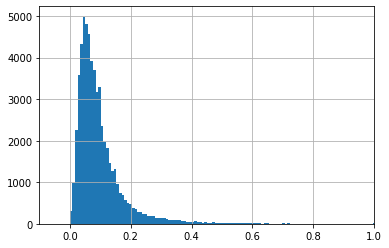

In [244]:
y_train.hist(bins=200)
plt.xlim(-0.1, 1);

In [245]:
X_train.mean()

is_AK                                       0.011464
is_HI                                       0.009212
same_state                                  0.043245
avg_weight_of_products                      2.051892
same_location                               0.183299
postal_zone_2                               0.064517
postal_zone_3                               0.064910
postal_zone_4                               0.149130
postal_zone_5                               0.240328
postal_zone_6                               0.134562
postal_zone_7                               0.131849
postal_zone_8                               0.194661
postal_zone_45                              0.020044
mean_b_brand_age_New                        0.422887
brand_location_Canada                       0.000000
brand_location_Middle Atlantic              0.118441
brand_location_New England                  0.058956
brand_location_Northeast Midwest            0.099352
brand_location_Northwest Midwest            0.

In [246]:
# The coefficients
print('Coefficients: \n', best_model.get_params()['steps'][0][1].coef_)

Coefficients: 
 [ 7.02709561e-02  4.24850776e-02 -1.51183729e-03  8.80026804e-05
 -1.45353057e-03 -1.28182186e-02 -8.35452979e-03 -7.50809379e-03
 -2.60602597e-03  2.78633142e-03  6.28304830e-03  1.02762614e-02
  1.19412270e-02  1.28984546e-02  0.00000000e+00 -4.61116799e-03
  1.30177007e-03 -2.93729518e-03 -3.47429258e-03 -5.58439273e-03
 -1.39790271e-03  3.80851321e-03 -6.78825276e-03  1.96830207e-02
  7.93948872e-03  4.92339479e-03 -7.14070482e-03 -1.68482678e-03
 -2.08547293e-03  1.49394938e-03  8.36840523e-03 -2.01531925e-02
  3.28712896e-03  2.38173278e-02  2.28695259e-03  3.20373102e-05
 -3.55741422e-03 -4.58500659e-03 -8.90471503e-03  3.70712553e-01
 -3.16029452e-03 -2.45568579e-02 -6.01964655e-02 -6.66917065e-02
 -6.67565144e-02  4.84662493e-01]


In [247]:
y_test_pred = best_model.predict(X_test[cols_to_use])

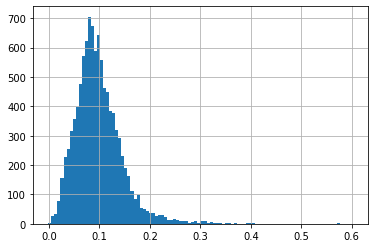

In [248]:
pd.Series(y_test_pred).hist(bins=100)

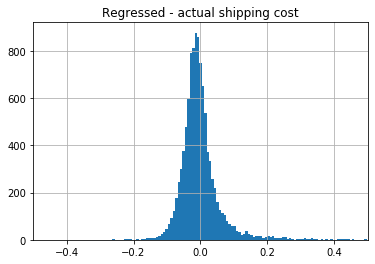

In [249]:
(y_test - y_test_pred).hist(bins=250)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.5, 0.5);

In [250]:
r2_score(y_test, y_test_pred)

0.31145397329120617

In [251]:
if target_future_scf:
    df_gb_future = df_gb_future.merge(df_gb[['brand_id', 'retailer_state', 'past_'+target]],
                                      on=['brand_id', 'retailer_state']
                                     )

In [252]:
y_future_pred = best_model.predict(df_gb_future[cols_to_use])

0.3180434698521326

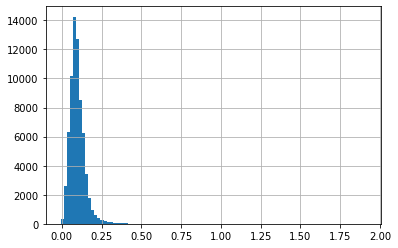

In [253]:
pd.Series(y_future_pred).hist(bins=100)
r2_score(y_future, y_future_pred)

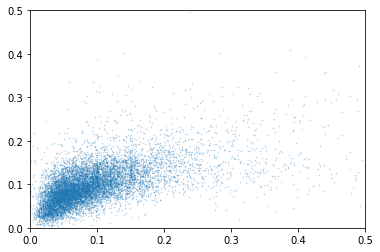

In [254]:
plt.scatter(y_test, y_test_pred, s=0.3, alpha=0.3)
plt.xlim(0,0.5);
plt.ylim(0,0.5);
# plt.xlim(-2000,1000)
# plt.ylim(-2000,1000)

In [255]:
if not target_future_scf:
    plt.scatter(y_future, y_future_pred, s=0.3, alpha=0.3)
    plt.xlim(0,0.5);
    plt.ylim(0,0.5);

### Fraction beyond 20% off

In [256]:
100.0*(abs(y_test_pred - y_test)/y_test_pred > 0.2).sum()/y_test_pred.shape[0]

68.09086515224746

### Fraction beyond 50% off

In [257]:
100.0*(abs(y_test_pred - y_test)/y_test_pred > 0.5).sum()/y_test_pred.shape[0]

28.023199613339777

### Fraction beyond 80% off

In [258]:
100.0*(abs(y_test_pred - y_test)/y_test_pred > 0.8).sum()/y_test_pred.shape[0]

8.922184630256162

In [259]:
df_test.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,retailer_location_South West,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction
32050,29508,NJ,0.000000,0.977011,3.007033,0.25,0.597701,0.333333,0.057471,Northeast Midwest,...,0,0,0,0,1,0,0,0,0,0.132668
88443,13942,NC,0.000000,0.000000,1.636055,0.25,0.000000,1.000000,0.000000,Northeast Midwest,...,0,0,0,0,1,0,0,0,0,0.153170
23810,25640,MN,0.000002,0.987654,0.337477,0.25,0.012346,0.000000,0.987654,Middle Atlantic,...,0,0,0,0,1,0,0,0,0,0.137128
211122,21852,NH,0.000000,0.250000,0.789153,0.25,0.000000,0.250000,0.750000,Pacific West,...,0,0,0,0,0,0,0,1,0,0.100593
150171,12367,WI,0.000002,0.000000,0.309332,0.25,0.000000,0.000000,0.976744,Middle Atlantic,...,0,0,0,0,1,0,0,0,0,0.031788


In [260]:
y_test[:5]

32050     0.042464
88443     0.252014
23810     0.012341
211122    0.065166
150171    0.029675
Name: target_shipping_cost_fraction, dtype: float64

In [261]:
df_val = pd.concat([df_test, y_test], axis=1)

In [262]:
df_val_future = pd.concat([df_gb_future.reset_index(), pd.Series(y_future_pred, name='prediction')], axis=1)

In [263]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
32050,29508,NJ,0.000000,0.977011,3.007033,0.25,0.597701,0.333333,0.057471,Northeast Midwest,...,0,0,0,1,0,0,0,0,0.132668,0.042464
88443,13942,NC,0.000000,0.000000,1.636055,0.25,0.000000,1.000000,0.000000,Northeast Midwest,...,0,0,0,1,0,0,0,0,0.153170,0.252014
23810,25640,MN,0.000002,0.987654,0.337477,0.25,0.012346,0.000000,0.987654,Middle Atlantic,...,0,0,0,1,0,0,0,0,0.137128,0.012341
211122,21852,NH,0.000000,0.250000,0.789153,0.25,0.000000,0.250000,0.750000,Pacific West,...,0,0,0,0,0,0,1,0,0.100593,0.065166
150171,12367,WI,0.000002,0.000000,0.309332,0.25,0.000000,0.000000,0.976744,Middle Atlantic,...,0,0,0,1,0,0,0,0,0.031788,0.029675


In [264]:
df_val_future.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv,past_target_shipping_cost_fraction,prediction
0,0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,...,0,0,1,0,586.49,155.49,586.4900,3478.00,0.165577,0.151872
1,1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,...,0,0,0,0,1024.93,408.03,1024.9300,11766.95,0.079317,0.097340
2,2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,...,0,0,1,0,1964.81,818.85,1964.8100,20856.75,0.091705,0.116558
3,3,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,...,0,0,1,0,62.44,35.68,62.4400,726.00,0.102906,0.081233
4,4,7935,CA,0.000065,0.000000,2.392898,0.18,0.622222,0.266667,0.088889,...,0,0,0,0,52.22,22.07,52.2200,392.00,0.042651,0.060495


In [265]:
df_val = pd.concat([df_val.reset_index(), pd.Series(y_test_pred)], axis=1)

In [266]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [267]:
df_val.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.093019
Beauty             0.095044
Home Decor         0.117184
Jewelry            0.044650
Kids               0.099161
Kitchen            0.146468
Men                0.091887
Other              0.106490
Pets               0.097856
Stationery         0.082351
Women's Apparel    0.069953
Name: prediction, dtype: float64

In [268]:
df_val.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.072321
3     0.082256
4     0.089242
5     0.096672
6     0.098367
7     0.103717
8     0.117600
45    0.113627
Name: prediction, dtype: float64

In [269]:
df_val.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction
0,32050,29508,NJ,0.000000,0.977011,3.007033,0.25,0.597701,0.333333,0.057471,...,0,0,1,0,0,0,0,0.132668,0.042464,0.104355
1,88443,13942,NC,0.000000,0.000000,1.636055,0.25,0.000000,1.000000,0.000000,...,0,0,1,0,0,0,0,0.153170,0.252014,0.147698
2,23810,25640,MN,0.000002,0.987654,0.337477,0.25,0.012346,0.000000,0.987654,...,0,0,1,0,0,0,0,0.137128,0.012341,0.091955
3,211122,21852,NH,0.000000,0.250000,0.789153,0.25,0.000000,0.250000,0.750000,...,0,0,0,0,0,1,0,0.100593,0.065166,0.108015
4,150171,12367,WI,0.000002,0.000000,0.309332,0.25,0.000000,0.000000,0.976744,...,0,0,1,0,0,0,0,0.031788,0.029675,0.046399


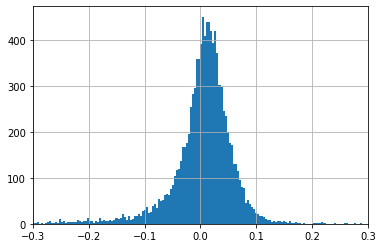

In [270]:
# df_temp = df_val.loc[df_val[target]>0, :]
df_temp = df_val

((df_temp.loc[df_temp[target] > 0, 'prediction'] \
  - df_temp.loc[df_temp[target] > 0, target]) \
#    / df_temp.loc[df_temp[target] > 0, target]
).hist(bins=500)

plt.xlim(-0.3, 0.3);

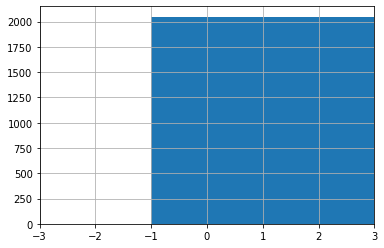

In [271]:
df_temp = df_val.loc[(df_val[target]>0)
                     & (df_val['num_brand_orders_to_state']>5)
                     ,
                     :]

((df_temp.loc[df_temp[target] > 0, 'prediction'] \
  - df_temp.loc[df_temp[target] > 0, target]) \
   / df_temp.loc[df_temp[target] > 0, target]
).hist(bins=200)

plt.xlim(-3, 3);

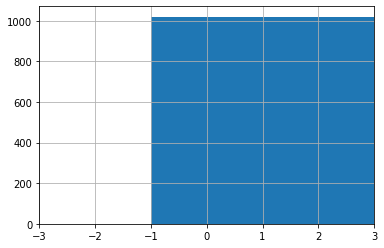

In [272]:
df_temp = df_val.loc[(df_val[target]>0)
                     & (df_val['num_brand_orders_to_state']>10)
                     ,
                     :]

((df_temp.loc[df_temp[target] > 0, 'prediction'] \
  - df_temp.loc[df_temp[target] > 0, target]) \
   / df_temp.loc[df_temp[target] > 0, target]
).hist(bins=200)

plt.xlim(-3, 3);

## Plot predicted shipping costs given brand state

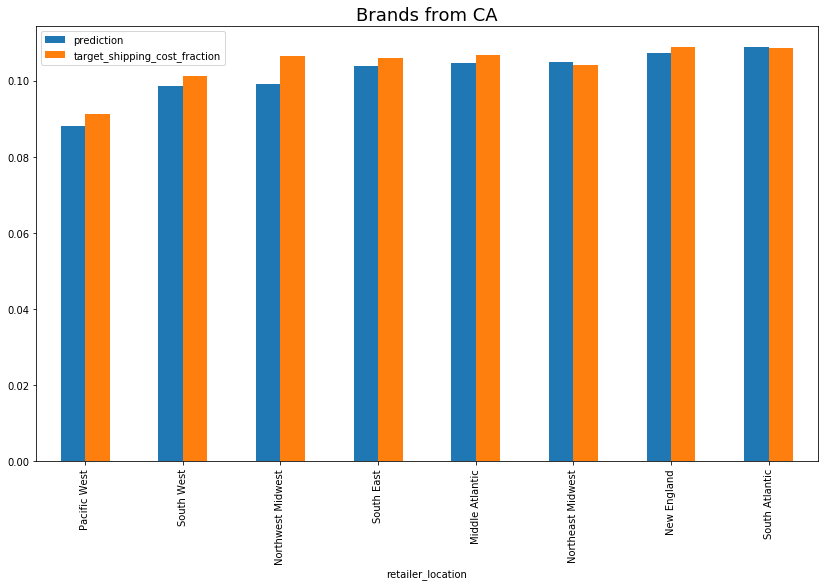

In [273]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

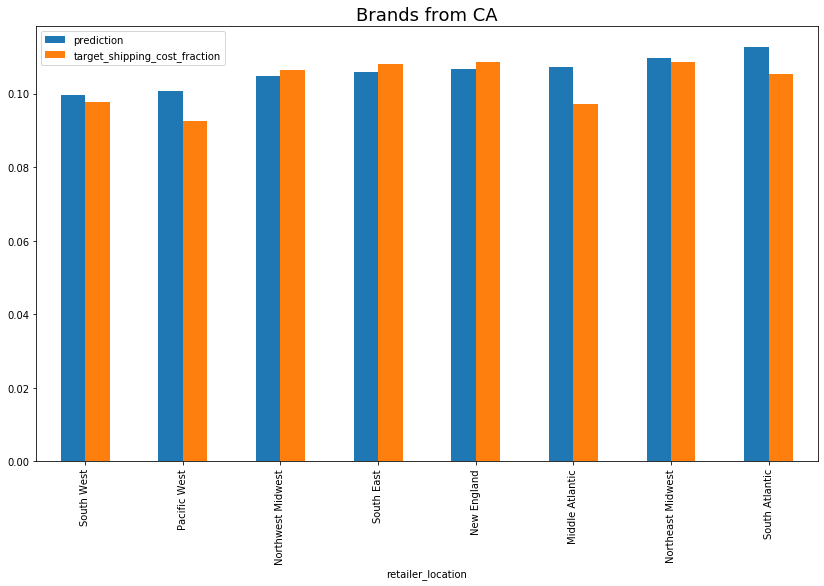

In [653]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

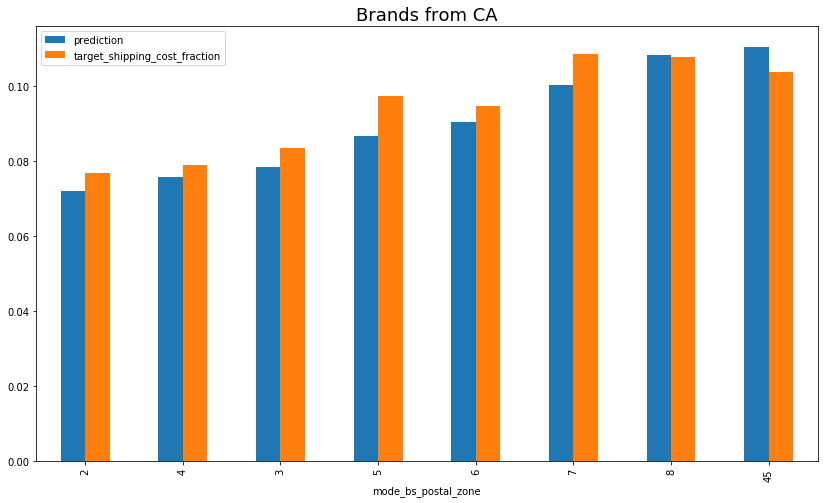

In [275]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

In [276]:
# df_val.loc[df_val['brand_location']=='Northwest Midwest', 'brand_state'].value_counts()

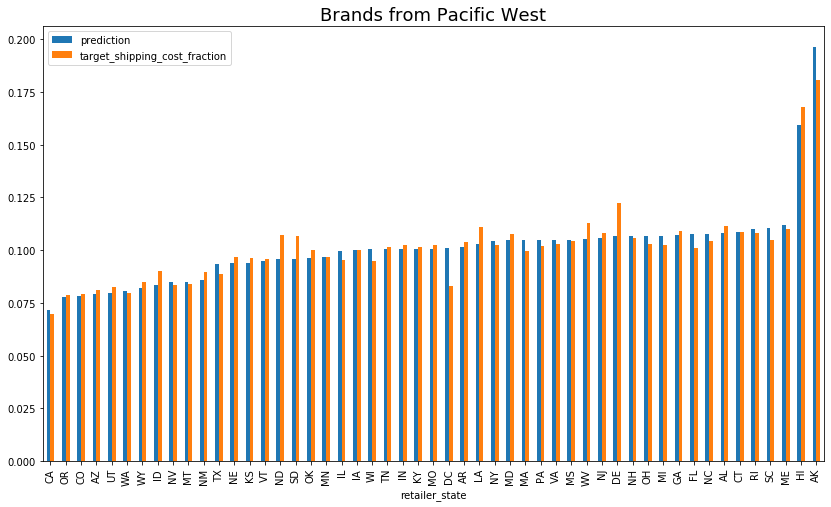

In [277]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

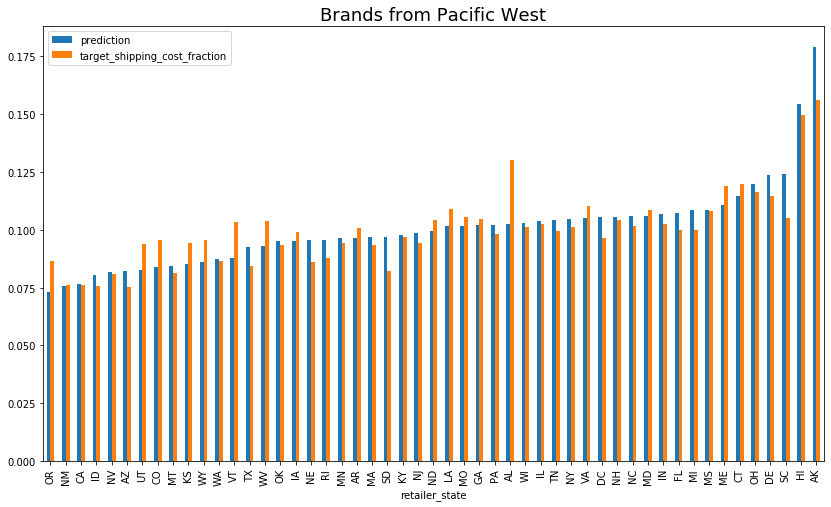

In [278]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_location']==b_loc)
#            & (df_val['primary_brand_category']==b_cat)
#            & (df_val['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

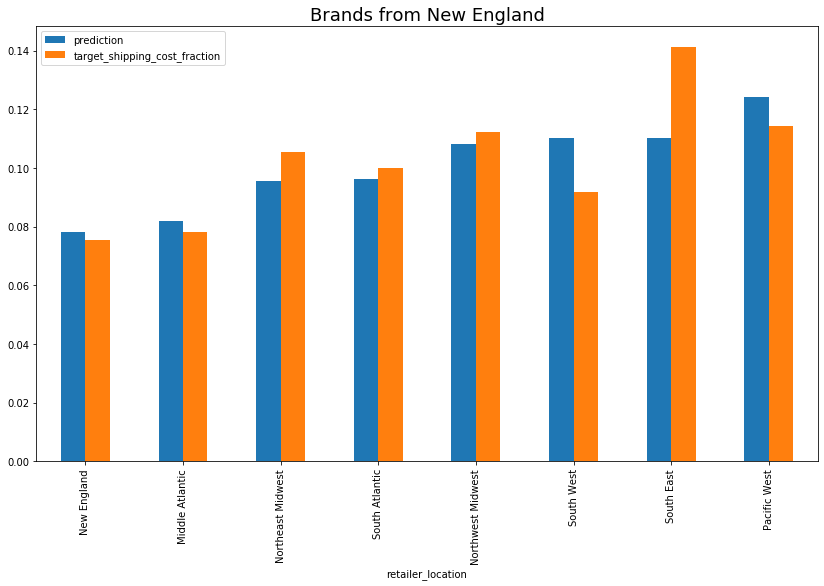

In [279]:
b_loc = 'New England'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_location']==b_loc)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

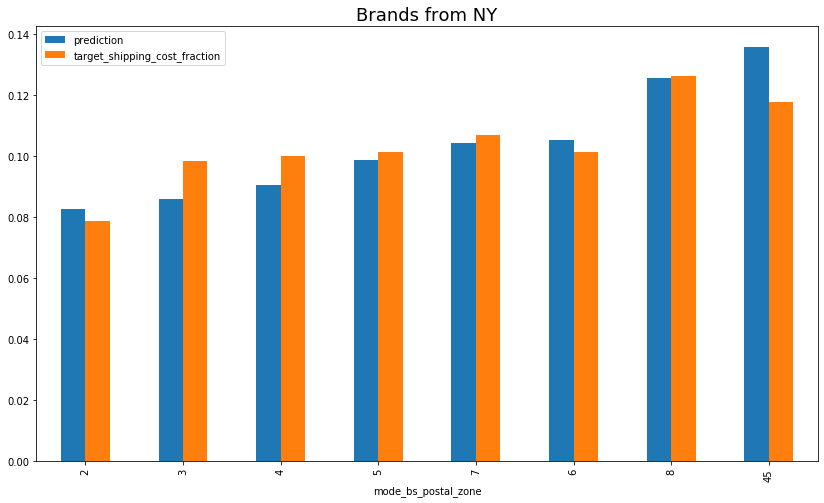

In [280]:
b_state = 'NY'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

In [281]:
# df_val.loc[df_val['brand_location']=='Northwest Midwest', 'brand_state'].value_counts()

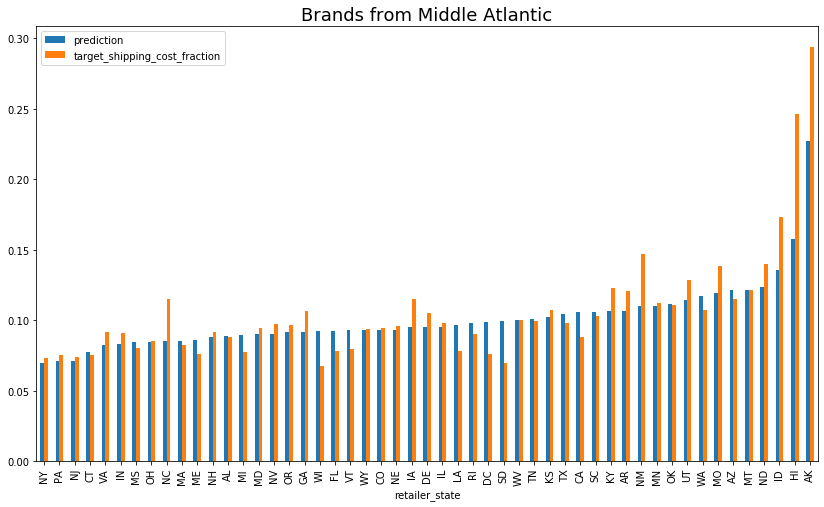

In [282]:
b_loc = 'Middle Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_location']==b_loc)
#            & (df_val['primary_brand_category']==b_cat)
#            & (df_val['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

# RandomForest Regressor

In [283]:
from sklearn.ensemble import RandomForestRegressor

In [284]:
std_scaling = StandardScaler() 
algo = RandomForestRegressor()

steps = [
#             ('std_scaling', StandardScaler()), 
            ('algo', RandomForestRegressor())
        ]
pipeline = Pipeline(steps)

parameters = {
#               'algo__class_weight': ['balanced', None],
              'algo__n_estimators': [250],
              'algo__max_depth': [25],
#               'algo__gamma': [0.1, 0.2],
#               'algo__learning_rate': [0.1, 0.5]
             }

cv1 = RepeatedKFold(n_splits=5, n_repeats=2)
rf_model= GridSearchCV(pipeline, cv = cv1
                   , param_grid = parameters
#                    , scoring = 'neg_mean_squared_error'
                   , scoring = 'r2'
#                    , scoring = 'explained_variance'
#                    , scoring  = 'neg_mean_absolute_error'
#                    , scoring  = 'neg_mean_squared_log_error'
                   , n_jobs=-1, return_train_score=False)


In [285]:
X_train.shape

(58620, 46)

In [286]:
# Fit grid search
best_model = rf_model.fit(X_train, y_train)

In [287]:
best_model = best_model.best_estimator_

In [288]:
best_model.get_params()

{'memory': None,
 'steps': [('algo',
   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                         max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=250,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False))],
 'verbose': False,
 'algo': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0,

In [289]:
y_train_pred = best_model.predict(X_train[cols_to_use])

In [290]:
y_test_pred = best_model.predict(X_test[cols_to_use])

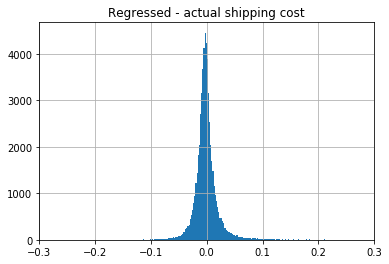

In [291]:
(y_train - y_train_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

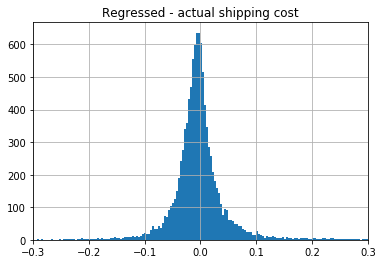

In [292]:
(y_test - y_test_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

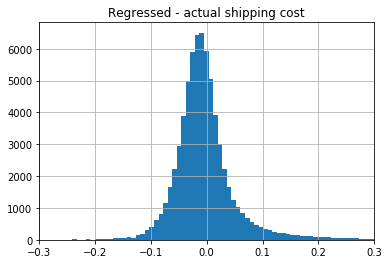

In [293]:
(y_future - y_future_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

In [294]:
r2_score(y_test, y_test_pred)

0.5314945052906973

In [295]:
r2_score(y_future, y_future_pred)

0.3180434698521326

In [296]:
((y_test - y_test_pred)/y_test_pred).mean()

-0.007532075909396745

(0, 0.5)

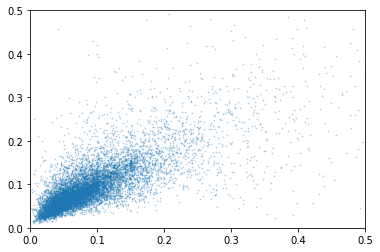

In [297]:
plt.scatter(y_test, y_test_pred, s=0.5, alpha=0.3)
plt.xlim(0,0.5)
plt.ylim(0,0.5)
# plt.xlim(-2000,1000)
# plt.ylim(-2000,1000)

(0, 0.5)

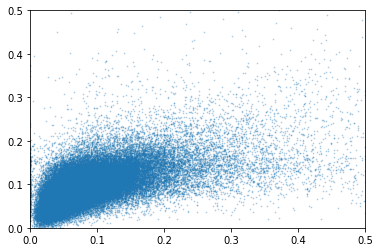

In [298]:
plt.scatter(y_future, y_future_pred, s=0.5, alpha=0.3)
plt.xlim(0,0.5)
plt.ylim(0,0.5)
# plt.xlim(-2000,1000)
# plt.ylim(-2000,1000)

### Fraction beyond 30% off

In [299]:
100.0*(abs(y_test_pred - y_test)/abs(y_test_pred) > 0.3).sum()/y_test_pred.shape[0]

40.918318028032864

In [300]:
100.0*(abs(y_future_pred - y_future)/abs(y_future_pred) > 0.3).sum()/y_future_pred.shape[0]

52.8685862740853

### Fraction beyond 50% off

In [301]:
100.0*(abs(y_test_pred - y_test)/abs(y_test_pred) > 0.5).sum()/y_test_pred.shape[0]

18.35669405509908

In [302]:
100.0*(abs(y_future_pred - y_future)/abs(y_future_pred) > 0.5).sum()/y_future_pred.shape[0]

28.368333694161795

### Fraction beyond 80% off

In [303]:
100.0*(abs(y_test_pred - y_test)/abs(y_test_pred) > 0.8).sum()/y_test_pred.shape[0]

5.094248429192847

In [304]:
100.0*(abs(y_future_pred - y_future)/abs(y_future_pred) > 0.8).sum()/y_future_pred.shape[0]

9.557624305405211

In [305]:
df_val = pd.concat([df_test, y_test], axis=1)

In [306]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
32050,29508,NJ,0.000000,0.977011,3.007033,0.25,0.597701,0.333333,0.057471,Northeast Midwest,...,0,0,0,1,0,0,0,0,0.132668,0.042464
88443,13942,NC,0.000000,0.000000,1.636055,0.25,0.000000,1.000000,0.000000,Northeast Midwest,...,0,0,0,1,0,0,0,0,0.153170,0.252014
23810,25640,MN,0.000002,0.987654,0.337477,0.25,0.012346,0.000000,0.987654,Middle Atlantic,...,0,0,0,1,0,0,0,0,0.137128,0.012341
211122,21852,NH,0.000000,0.250000,0.789153,0.25,0.000000,0.250000,0.750000,Pacific West,...,0,0,0,0,0,0,1,0,0.100593,0.065166
150171,12367,WI,0.000002,0.000000,0.309332,0.25,0.000000,0.000000,0.976744,Middle Atlantic,...,0,0,0,1,0,0,0,0,0.031788,0.029675


In [307]:
df_val = pd.concat([df_val.reset_index(), pd.Series(y_test_pred)], axis=1)

In [308]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [309]:
df_val.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.093507
Beauty             0.096677
Home Decor         0.119339
Jewelry            0.047433
Kids               0.100921
Kitchen            0.144691
Men                0.097007
Other              0.121027
Pets               0.104377
Stationery         0.083340
Women's Apparel    0.074307
Name: prediction, dtype: float64

In [310]:
df_val.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.081284
3     0.089704
4     0.092736
5     0.098768
6     0.098592
7     0.102487
8     0.114973
45    0.106331
Name: prediction, dtype: float64

In [311]:
df_val.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction
0,32050,29508,NJ,0.000000,0.977011,3.007033,0.25,0.597701,0.333333,0.057471,...,0,0,1,0,0,0,0,0.132668,0.042464,0.045881
1,88443,13942,NC,0.000000,0.000000,1.636055,0.25,0.000000,1.000000,0.000000,...,0,0,1,0,0,0,0,0.153170,0.252014,0.182171
2,23810,25640,MN,0.000002,0.987654,0.337477,0.25,0.012346,0.000000,0.987654,...,0,0,1,0,0,0,0,0.137128,0.012341,0.211621
3,211122,21852,NH,0.000000,0.250000,0.789153,0.25,0.000000,0.250000,0.750000,...,0,0,0,0,0,1,0,0.100593,0.065166,0.085588
4,150171,12367,WI,0.000002,0.000000,0.309332,0.25,0.000000,0.000000,0.976744,...,0,0,1,0,0,0,0,0.031788,0.029675,0.034125


In [312]:
df_val_future = pd.concat([df_gb_future.reset_index(), pd.Series(y_future_pred, name='prediction')], axis=1)

In [313]:
df_val_future.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.070785
3     0.081004
4     0.088541
5     0.095668
6     0.098770
7     0.104440
8     0.117645
45    0.113872
Name: prediction, dtype: float64

### Plots again

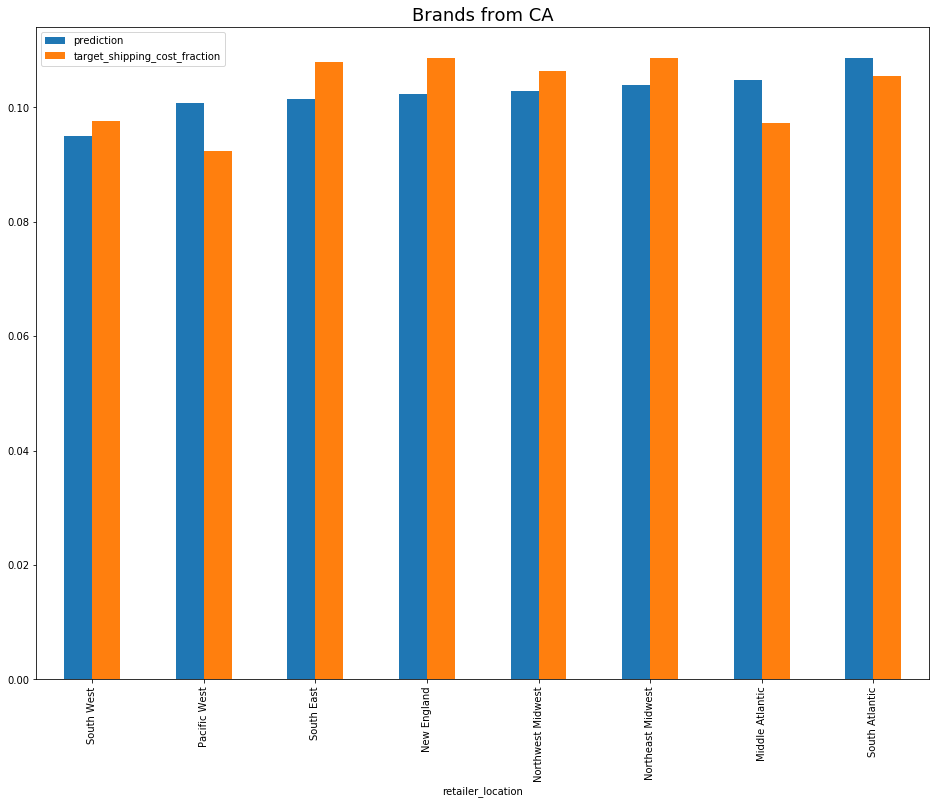

In [314]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

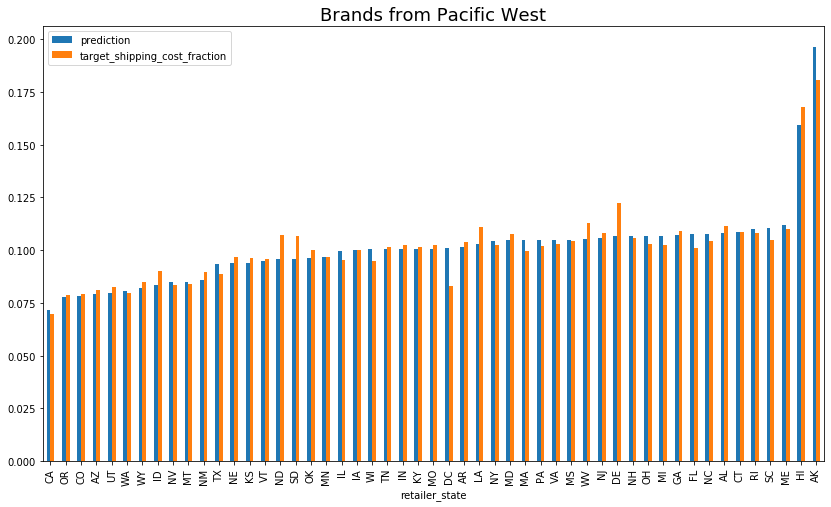

In [315]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

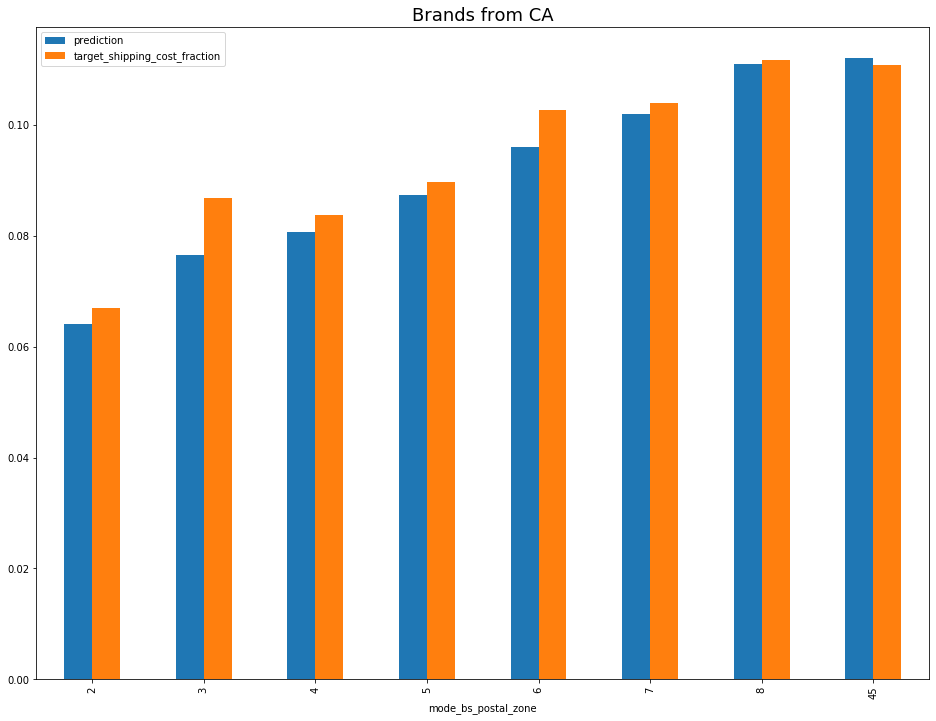

In [316]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

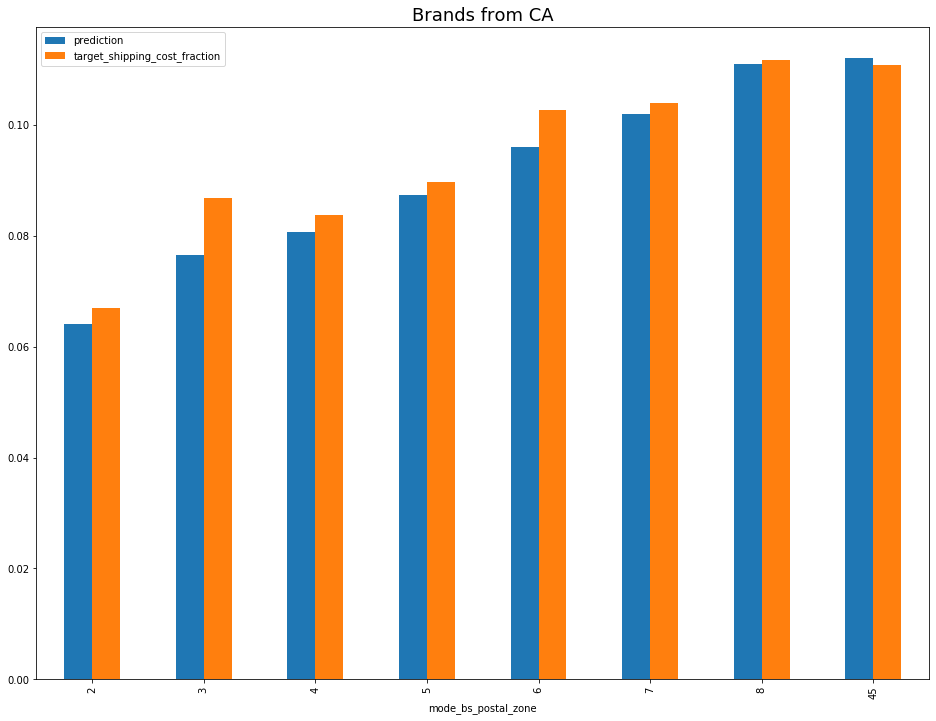

In [317]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

In [318]:
# df_val.loc[df_val['brand_location']=='Northwest Midwest', 'brand_state'].value_counts()

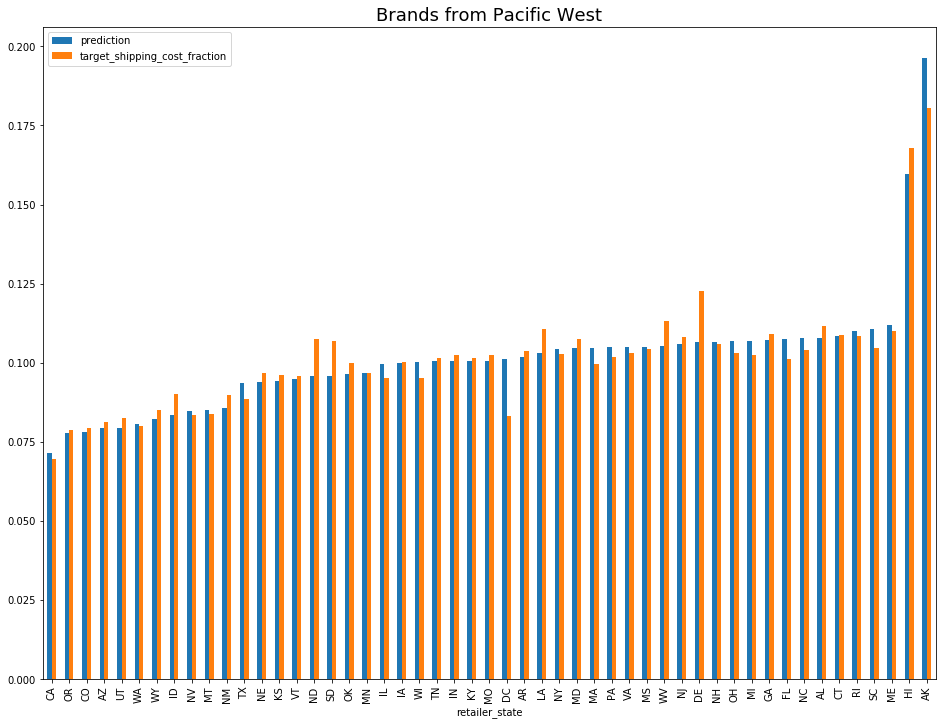

In [319]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

plt.show();

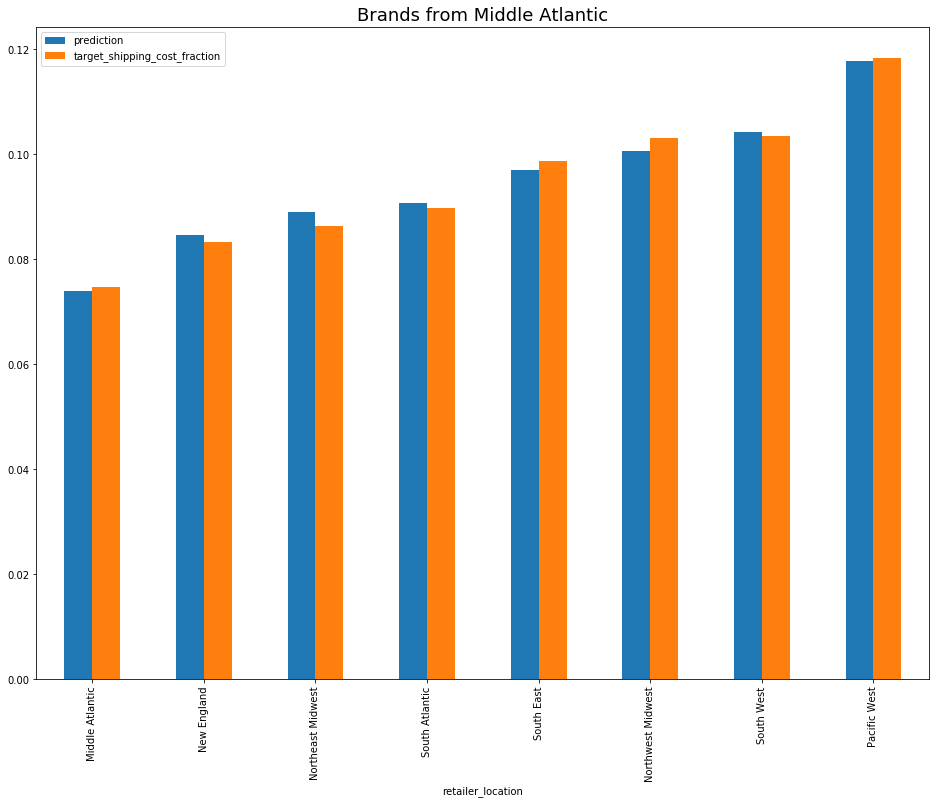

In [320]:
b_loc = 'Middle Atlantic'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

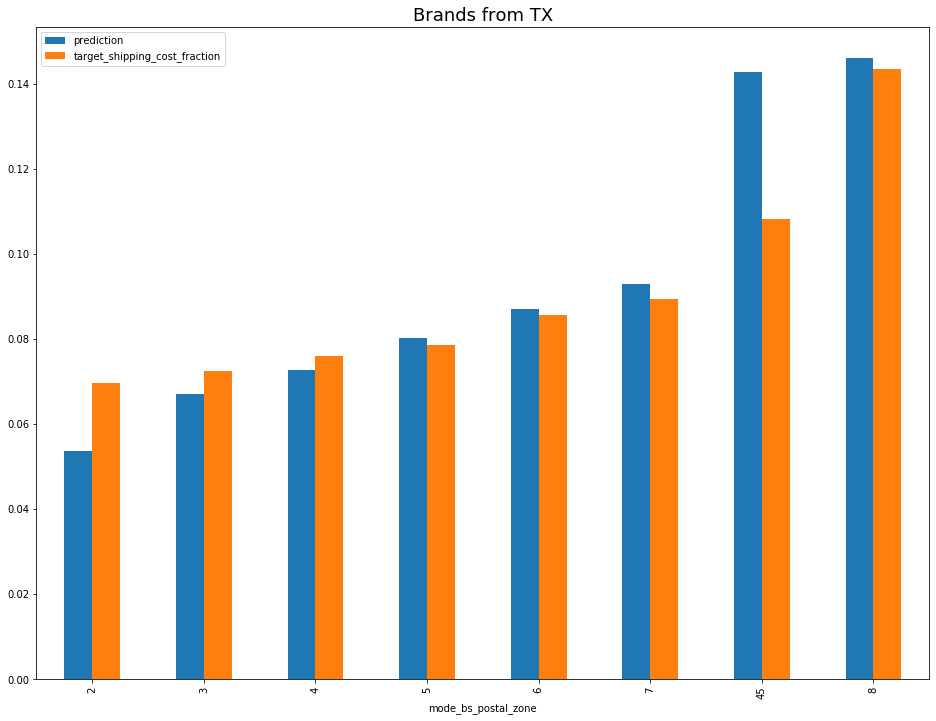

In [321]:
b_state = 'TX'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

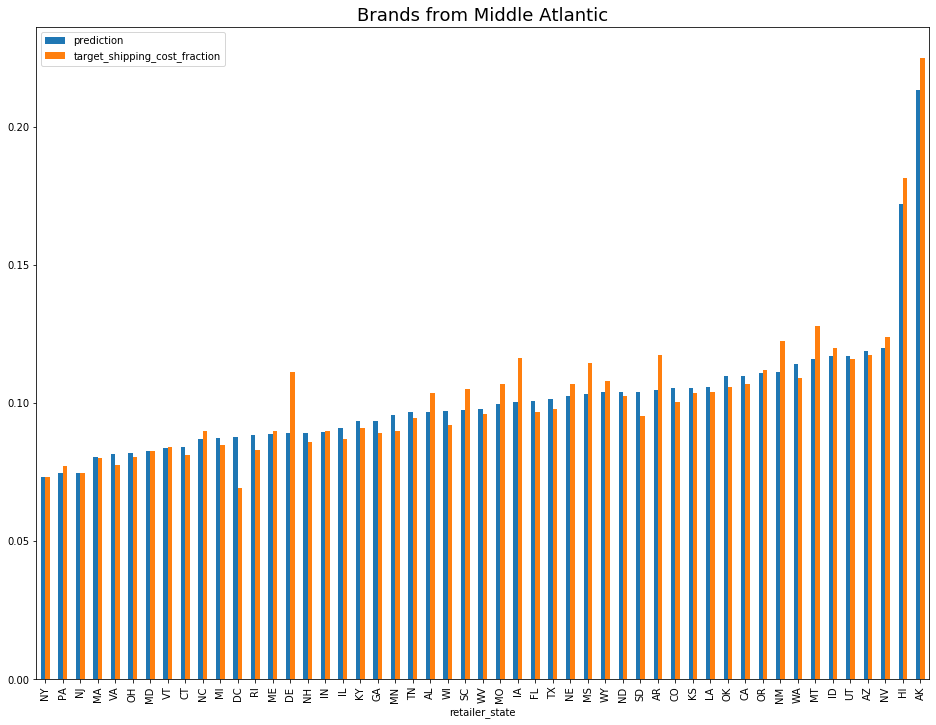

In [322]:
b_loc = 'Middle Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

### Add predictions to df_gb

In [323]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
0,396,CA,0.000257,0.000000,2.002188,0.15,0.966667,0.000000,0.022222,New England,...,0,0,0,0,0,0,1,0,0.165577,0.168629
1,4198,CA,0.000382,0.007853,1.190212,0.15,0.001309,0.827225,0.159686,Pacific West,...,0,0,0,1,0,0,0,0,0.079317,0.087102
2,6881,CA,0.000745,0.000000,1.109405,0.15,0.953627,0.001189,0.029727,Northeast Midwest,...,0,0,0,0,0,0,1,0,0.091705,0.094205
3,10036,CA,0.000024,0.000000,1.755226,0.25,0.000000,0.000000,0.000000,Unknown,...,0,0,0,0,0,0,1,0,0.247928,NaN
4,7569,CA,0.000037,0.933824,0.393461,0.15,0.000000,0.000000,1.000000,Northeast Midwest,...,0,0,0,0,0,0,1,0,0.102906,0.086006


In [324]:
y_test_pred = best_model.predict(df_gb[cols_to_use])

In [325]:
df_gb = pd.concat([df_gb.reset_index(), pd.Series(y_test_pred)], axis=1)

In [326]:
df_gb.columns = df_gb.columns.tolist()[:-1] + ['prediction']

In [327]:
df_gb.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.096974
Beauty             0.101331
Home Decor         0.121219
Jewelry            0.045313
Kids               0.107076
Kitchen            0.154748
Men                0.100812
Other              0.132701
Pets               0.099382
Stationery         0.091795
Women's Apparel    0.079125
Name: prediction, dtype: float64

In [328]:
df_gb.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.082909
3     0.091515
4     0.093555
5     0.098147
6     0.098545
7     0.101388
8     0.118261
45    0.107497
Name: prediction, dtype: float64

# Now train an XGB regressor

In [329]:
from xgboost import XGBRegressor, DMatrix, cv, plot_importance
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, ParameterGrid

In [330]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [331]:
params = {
      'subsample': [0.8]
    , 'n_estimators': [220]
    , 'min_child_weight': [2]
    , 'max_depth': [12]
    , 'colsample_bytree': [0.9]
    , 'learning_rate': [0.02]
}

In [332]:
xgb = XGBRegressor(learning_rate=0.02, silent=True, nthread=1)

folds = 5
param_comb = 5

skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = GridSearchCV(xgb, param_grid=params             
# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, random_state=1001 
                                   , scoring='r2'                 
#                                    , scoring='explained_variance'
#                                    , scoring='neg_mean_absolute_error'
#                                    , scoring='neg_median_absolute_error'
                                   , n_jobs=4, cv=skf.split(X_train,y_train), verbose=3
                                   
                            )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train[cols_to_use], y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.0min finished
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



 Time taken: 0 hours 3 minutes and 10.73 seconds.


In [333]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([61.95467539]), 'std_fit_time': array([4.18673563]), 'mean_score_time': array([0.76319389]), 'std_score_time': array([0.1660365]), 'param_colsample_bytree': masked_array(data=[0.9],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.02],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[12],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[2],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[220],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 12, 'min_chi

In [334]:
# folds = 5

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable

# # skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)
# # for train_index, test_index in skf.split(X_train, y_train):

# error_list = []
# model_list = []
# param_grid = ParameterGrid(params)
# for p in param_grid:
# #     print(p)
#     xgb = XGBRegressor(**p)
# #     print("Trying out model:\n", xgb)
#     xgb.fit(X_train[cols_to_use], y_train)
    
#     y_future_pred = xgb.predict(df_gb_future[cols_to_use])
    
#     e = r2_score(df_gb_future[target], y_future_pred)
#     print(e)
#     error_list.append(e)
#     model_list.append(xgb)
    
# timer(start_time) # timing ends here for "start_time" variable

In [335]:
# import operator
# index, value = max(enumerate(error_list), key=operator.itemgetter(1))
# print(index, value)
# print('Best parameter set:', param_grid[index])
# xgb_model= model_list[index]

In [336]:
xgb_model = random_search.best_estimator_

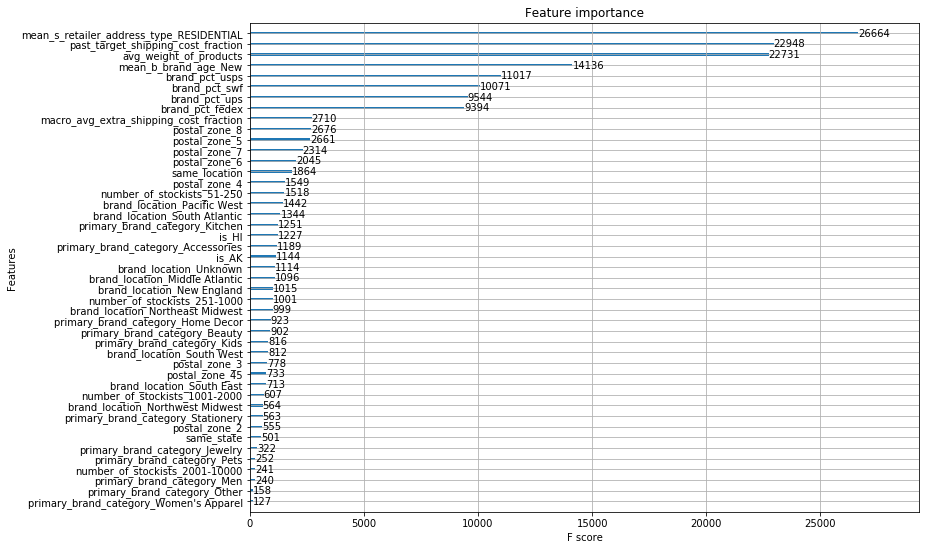

In [337]:
fig, ax = plt.subplots(figsize=(12, 9));
plot_importance(xgb_model.get_booster(), importance_type='weight', ax=ax);

In [338]:
# fig, ax = plt.subplots(figsize=(20, 15));
# plot_importance(xgb_model.get_booster(), importance_type='gain', ax=ax);

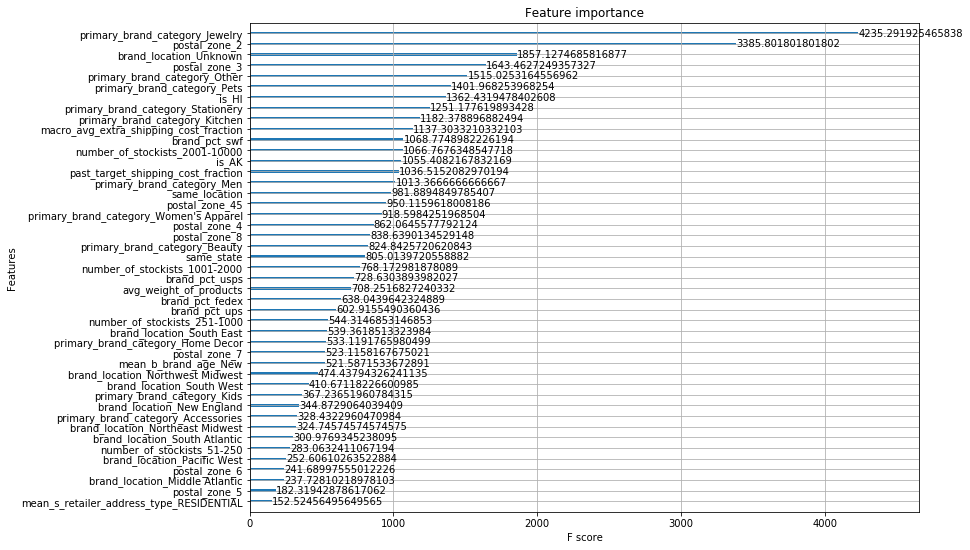

In [339]:
fig, ax = plt.subplots(figsize=(12, 9));
plot_importance(xgb_model.get_booster(), importance_type='cover', ax=ax);

In [340]:
y_test_pred = xgb_model.predict(X_test[cols_to_use])

In [341]:
y_future_pred = xgb_model.predict(df_gb_future[cols_to_use])

In [342]:
r2_score(y_test, y_test_pred)

0.543090613948386

In [343]:
y_future = df_gb_future[target]

In [344]:
r2_score(y_future, y_future_pred)

0.7369054400011783

(0, 0.5)

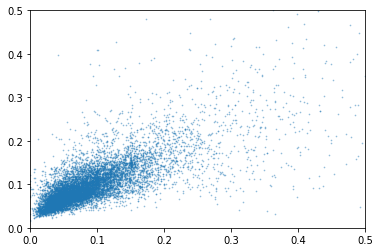

In [345]:
plt.scatter(y_test, y_test_pred, s=0.5, alpha=0.4)
plt.xlim(0,0.5)
plt.ylim(0,0.5)

(0, 0.5)

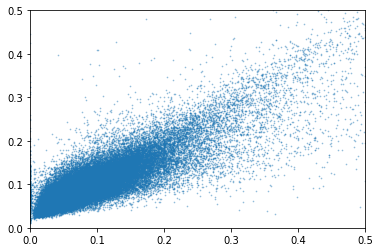

In [346]:
plt.scatter(y_future, y_future_pred, s=0.5, alpha=0.4)
plt.xlim(0,0.5)
plt.ylim(0,0.5)

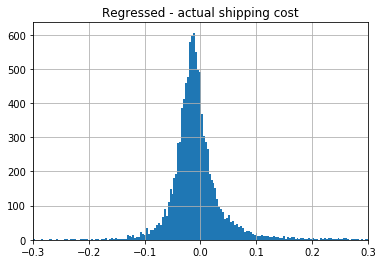

In [347]:
(y_test - y_test_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

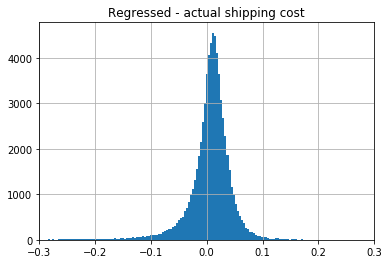

In [348]:
(y_future_pred - y_future).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

In [349]:
(y_test - y_test_pred).std()

0.05889213267644711

In [350]:
(y_future - y_future_pred).std()

0.0446164609063395

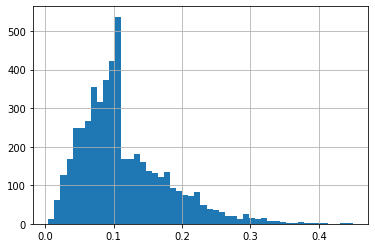

In [351]:
df_gb[['brand_id','smoothed_return_rate']].drop_duplicates()['smoothed_return_rate'].hist(bins=50)

In [352]:
df_val = pd.concat([df_test, y_test], axis=1)

In [353]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
32050,29508,NJ,0.000000,0.977011,3.007033,0.25,0.597701,0.333333,0.057471,Northeast Midwest,...,0,0,0,1,0,0,0,0,0.132668,0.042464
88443,13942,NC,0.000000,0.000000,1.636055,0.25,0.000000,1.000000,0.000000,Northeast Midwest,...,0,0,0,1,0,0,0,0,0.153170,0.252014
23810,25640,MN,0.000002,0.987654,0.337477,0.25,0.012346,0.000000,0.987654,Middle Atlantic,...,0,0,0,1,0,0,0,0,0.137128,0.012341
211122,21852,NH,0.000000,0.250000,0.789153,0.25,0.000000,0.250000,0.750000,Pacific West,...,0,0,0,0,0,0,1,0,0.100593,0.065166
150171,12367,WI,0.000002,0.000000,0.309332,0.25,0.000000,0.000000,0.976744,Middle Atlantic,...,0,0,0,1,0,0,0,0,0.031788,0.029675


In [354]:
df_val = pd.concat([df_val.reset_index(drop=True), pd.Series(y_test_pred)], axis=1)

In [355]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [356]:
df_val.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.097790
Beauty             0.099952
Home Decor         0.122799
Jewelry            0.051804
Kids               0.104847
Kitchen            0.148334
Men                0.099371
Other              0.117617
Pets               0.105581
Stationery         0.087455
Women's Apparel    0.077518
Name: prediction, dtype: float32

In [357]:
df_val.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.080294
3     0.091482
4     0.095887
5     0.102663
6     0.102520
7     0.107303
8     0.120197
45    0.111147
Name: prediction, dtype: float32

In [358]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction
0,29508,NJ,0.000000,0.977011,3.007033,0.25,0.597701,0.333333,0.057471,Northeast Midwest,...,0,0,1,0,0,0,0,0.132668,0.042464,0.070804
1,13942,NC,0.000000,0.000000,1.636055,0.25,0.000000,1.000000,0.000000,Northeast Midwest,...,0,0,1,0,0,0,0,0.153170,0.252014,0.170723
2,25640,MN,0.000002,0.987654,0.337477,0.25,0.012346,0.000000,0.987654,Middle Atlantic,...,0,0,1,0,0,0,0,0.137128,0.012341,0.204661
3,21852,NH,0.000000,0.250000,0.789153,0.25,0.000000,0.250000,0.750000,Pacific West,...,0,0,0,0,0,1,0,0.100593,0.065166,0.098109
4,12367,WI,0.000002,0.000000,0.309332,0.25,0.000000,0.000000,0.976744,Middle Atlantic,...,0,0,1,0,0,0,0,0.031788,0.029675,0.039871


In [359]:
df_val_future = pd.concat([df_gb_future.reset_index(drop=True), pd.Series(y_future_pred, name='prediction')], axis=1)

In [360]:
df_val_future.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.077655
3     0.088051
4     0.094545
5     0.100906
6     0.102847
7     0.107955
8     0.121128
45    0.115171
Name: prediction, dtype: float32

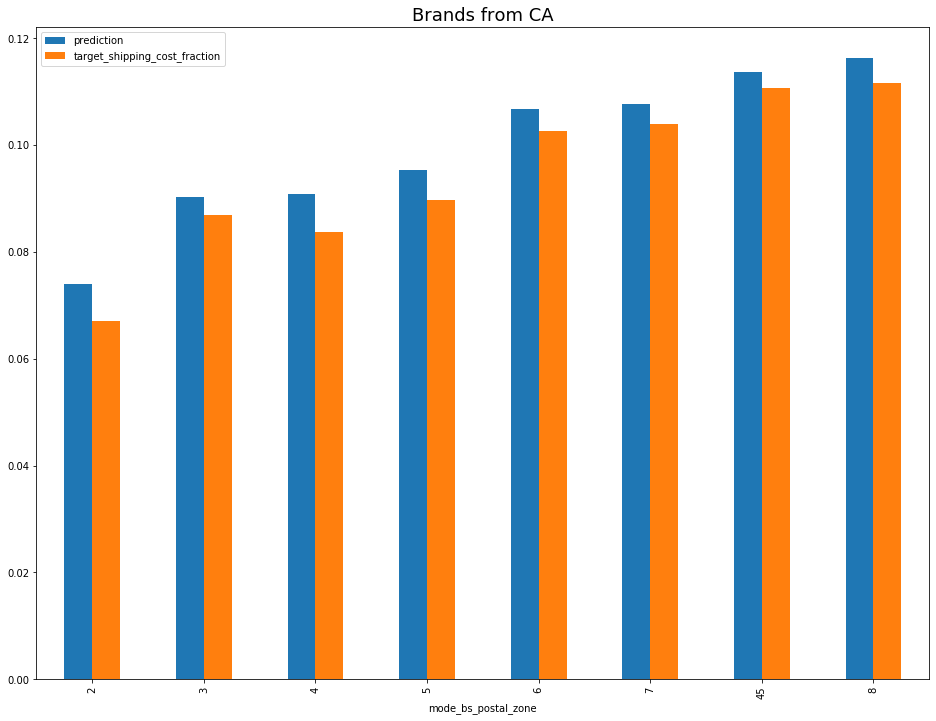

In [361]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

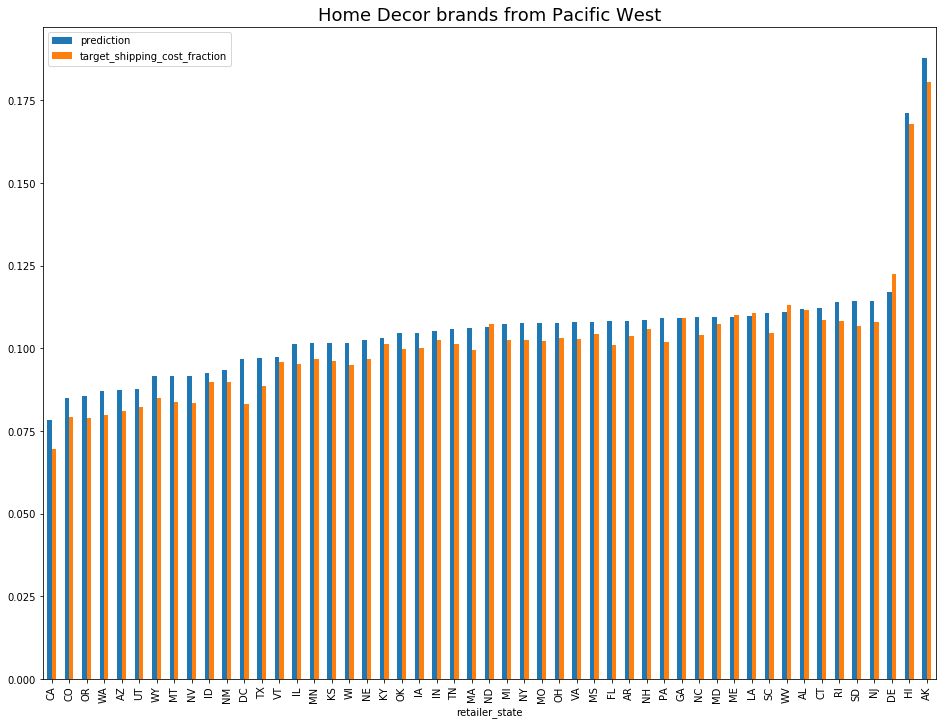

In [362]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title(b_cat+' brands from '+b_loc, fontsize=18);

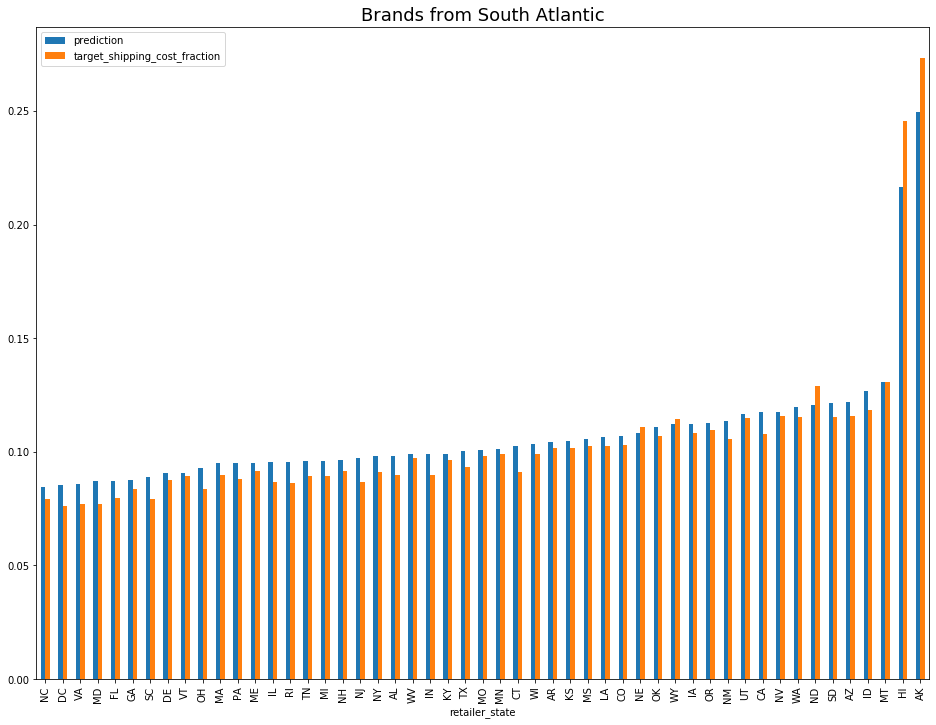

In [363]:
b_loc = 'South Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

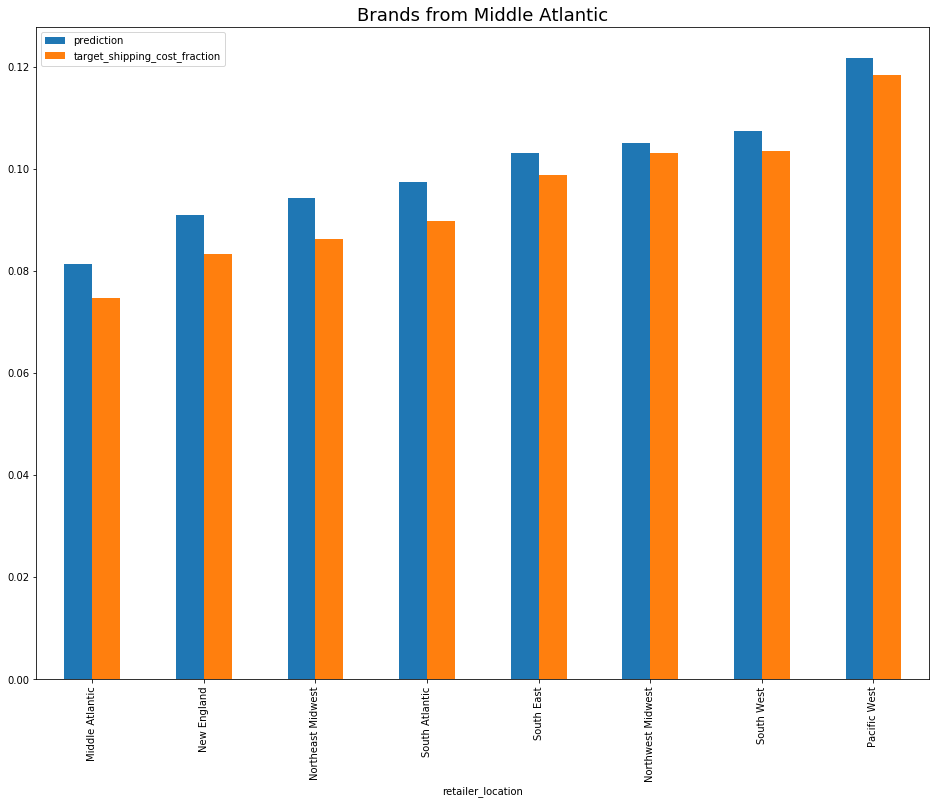

In [364]:
b_loc = 'Middle Atlantic'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

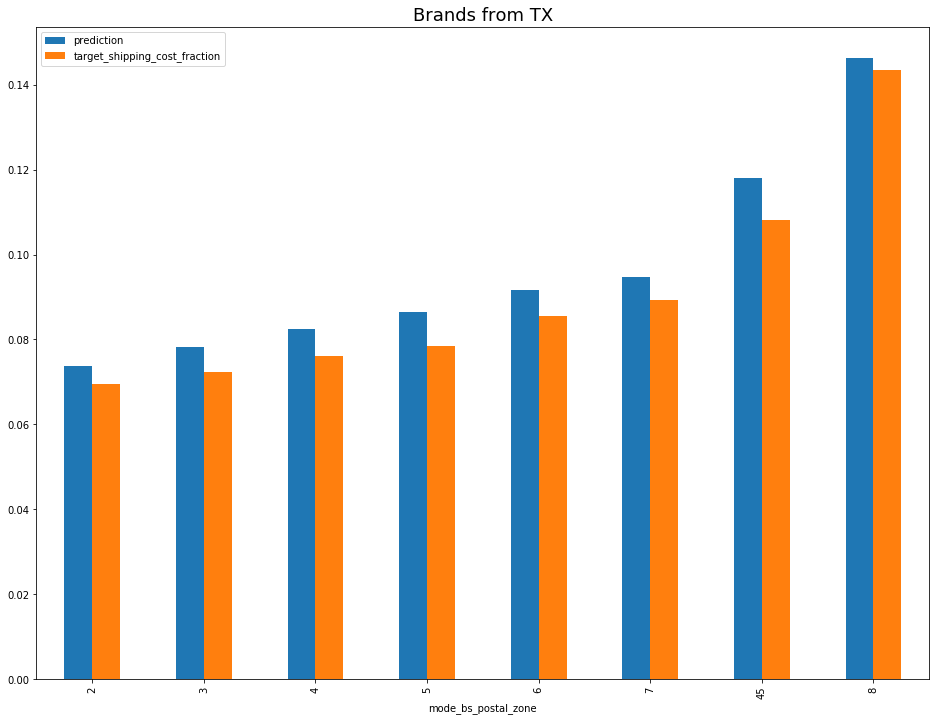

In [365]:
b_state = 'TX'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

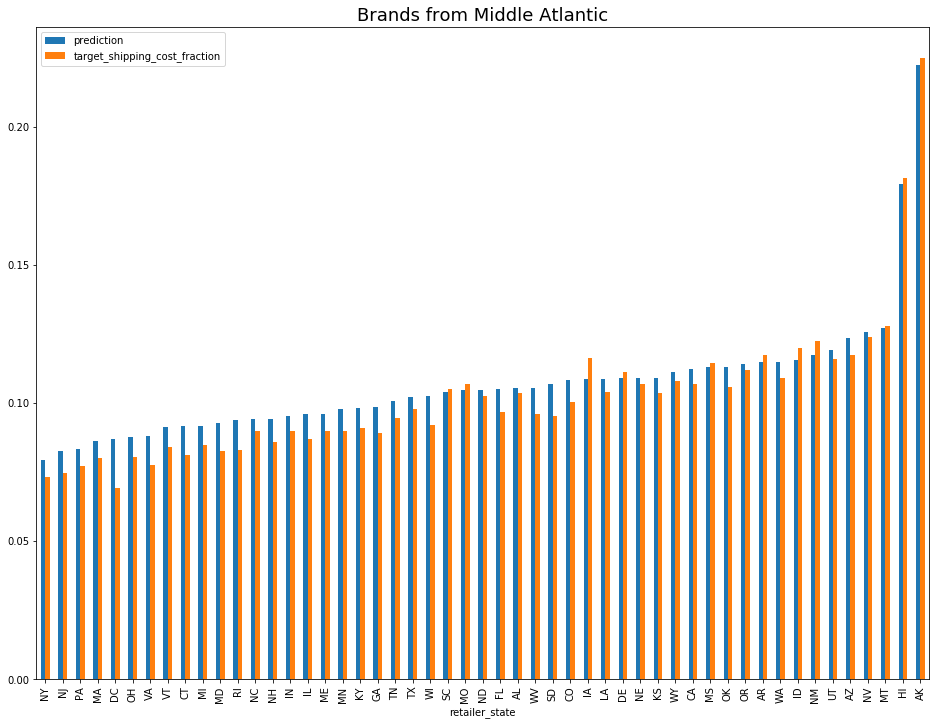

In [366]:
b_loc = 'Middle Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

In [367]:
df_val_future.loc[df_val_future['brand_state']=='NY',
                  ['retailer_state','prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
NY    0.079312
NJ    0.085535
MA    0.087329
DC    0.087496
PA    0.091595
VA    0.091788
OH    0.092473
VT    0.093315
MI    0.096948
ME    0.096979
NC    0.097585
CT    0.097650
RI    0.097820
IL    0.098391
MN    0.099933
KY    0.100626
IN    0.101098
TN    0.101141
NH    0.101252
GA    0.102275
MD    0.103136
TX    0.103254
WI    0.106249
MO    0.106275
AL    0.106331
ND    0.107449
FL    0.109666
WV    0.109800
SC    0.110579
OK    0.110695
LA    0.110749
CO    0.111819
SD    0.112327
IA    0.113256
NE    0.114191
OR    0.115799
CA    0.116049
WA    0.116765
MS    0.119024
KS    0.119210
WY    0.120042
AR    0.121236
UT    0.121954
ID    0.121985
DE    0.124021
NV    0.126215
AZ    0.127636
NM    0.127935
MT    0.131375
HI    0.196296
AK    0.228885
Name: prediction, dtype: float32

In [368]:
df_val_future.loc[df_val_future['brand_state']=='CA',
                  ['retailer_state','prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
CA    0.075161
NV    0.088468
CO    0.090708
AZ    0.090943
OR    0.092721
UT    0.093386
WA    0.093927
ID    0.095193
MT    0.095988
VT    0.096364
NM    0.097127
WY    0.098674
TX    0.099004
DC    0.100961
KY    0.103201
IL    0.103813
MN    0.104479
WI    0.106730
OK    0.107225
KS    0.107716
NE    0.107872
TN    0.108025
IN    0.108676
IA    0.109040
NY    0.109207
FL    0.109272
MA    0.110326
NH    0.110893
VA    0.110926
MO    0.111188
LA    0.111321
MI    0.111469
OH    0.111705
MS    0.111887
PA    0.112502
ME    0.112893
MD    0.112955
ND    0.113145
AL    0.113745
SC    0.113868
GA    0.114345
NC    0.114866
CT    0.115283
AR    0.115570
DE    0.115600
WV    0.118868
NJ    0.119418
RI    0.120043
SD    0.122410
HI    0.174053
AK    0.207973
Name: prediction, dtype: float32

### Add predictions to df_gb

In [369]:
if use_xgb_model:
    df_gb['prediction'] = xgb_model.predict(df_gb[cols_to_use])
else:
    df_gb['prediction'] = best_model.predict(df_gb[cols_to_use])

In [370]:
df_gb.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.101191
Beauty             0.105686
Home Decor         0.125800
Jewelry            0.050942
Kids               0.109993
Kitchen            0.158682
Men                0.103373
Other              0.133584
Pets               0.104546
Stationery         0.094765
Women's Apparel    0.082662
Name: prediction, dtype: float32

In [371]:
df_gb.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.083802
3     0.093339
4     0.096805
5     0.102418
6     0.103040
7     0.106462
8     0.123247
45    0.112112
Name: prediction, dtype: float32

## Hack away from the bottom to keep 30% of historical GMV:

In [372]:
df_gb[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Accessories        879
Home Decor         785
Beauty             766
Jewelry            719
Kitchen            634
Stationery         571
Kids               226
Women's Apparel    194
Other              116
Men                104
Pets                69
Name: primary_brand_category, dtype: int64

### Blended commission as function of 1st order commission

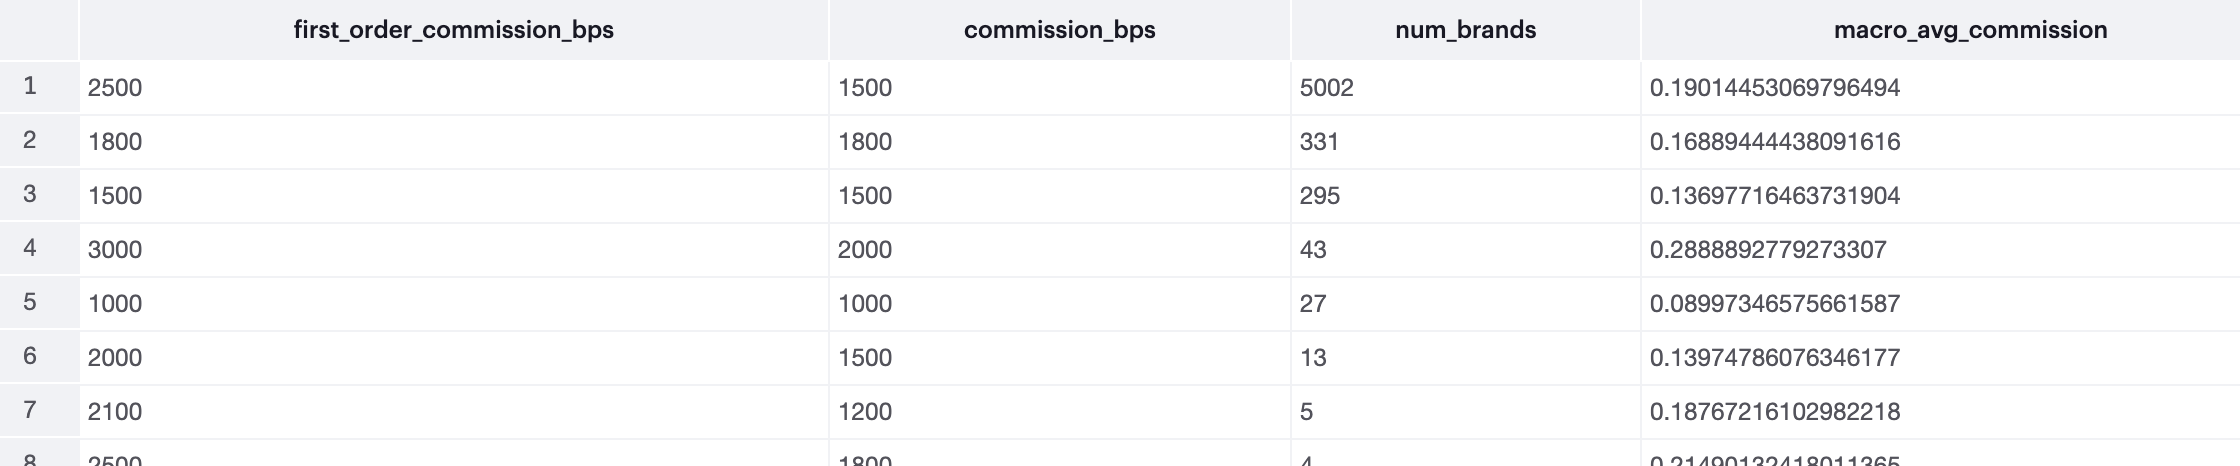

In [373]:
0.169/0.18

0.938888888888889

In [374]:
0.137/0.15

0.9133333333333334

In [375]:
0.19/0.25

0.76

In [376]:
df_gb['first_order_commission'].value_counts()

0.250    218739
0.180     16932
0.150     14739
0.000      3774
0.100      1275
0.200       816
0.300       816
0.210       357
0.120       153
0.125       102
0.110       102
0.220       102
0.010        51
0.170        51
0.070        51
0.240        51
0.230        51
0.050        51
Name: first_order_commission, dtype: int64

In [377]:
df_gb['blended_commission'] = df_gb['first_order_commission'].apply(
    lambda x: 0.19 if x >= 0.25 else 0.92*x
)

In [378]:
# df_gb['simplified_commission'] = -1.0*df_gb['prediction']

df_gb['simplified_commission'] = df_gb['blended_commission'] \
                               - 0.5*df_gb['smoothed_return_rate'] \
                               - df_gb['prediction']

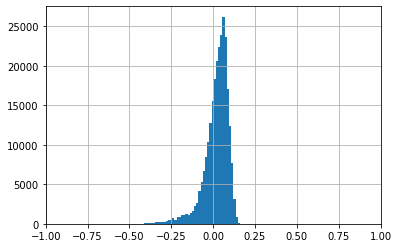

In [379]:
df_gb['simplified_commission'].hist(bins=100)
plt.xlim(-1.0, 1.0);

### TODO: remove this block after:

In [380]:
return_rate_dictionary = (
    df_gb[["primary_brand_category", "macro_avg_return_rate"]]
    .groupby("primary_brand_category")["macro_avg_return_rate"]
    .mean()
).to_dict()

In [381]:
df_gb["smoothed_return_rate_test"] = df_gb.apply(
    lambda x: (
        smoothing_strength * return_rate_dictionary[x["primary_brand_category"]]
        + x["num_rr_cured_brand_orders"] * x["macro_avg_return_rate"]
    )
    / (smoothing_strength + x["num_rr_cured_brand_orders"]),
    axis=1,
)

In [382]:
df_gb['num_rr_cured_brand_orders'].mean()

67.36756863519652

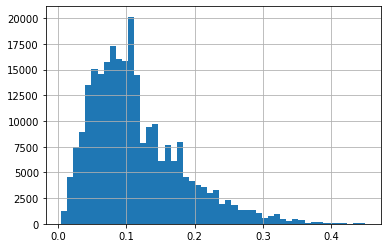

In [383]:
df_gb['smoothed_return_rate_test'].hist(bins=50)

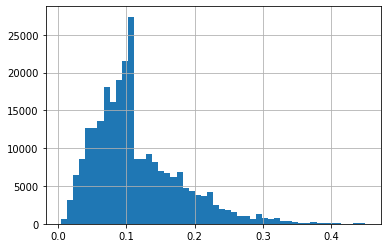

In [384]:
df_gb['smoothed_return_rate'].hist(bins=50)

### Remove block above after

In [385]:
df_gb['simplified_commission'].mean()

0.019257352627126557

In [386]:
df_gb['blended_commission'].mean()

0.18196413193758634

In [387]:
df_gb['prediction'].mean()

0.10554084

In [388]:
df_gb.shape

(258213, 92)

In [389]:
df_gb = df_gb.sort_values('simplified_commission', ascending=False)

In [390]:
df_gb.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission,smoothed_return_rate_test
250758,250758,5954,VT,0.000256,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0,0,0,0,0.007853,0.006597,0.021227,0.19,0.160004,0.019392
98868,98868,5954,CT,0.000015,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0,0,0,0,0.009316,0.000032,0.022702,0.19,0.158529,0.019392
210254,210254,5954,NH,0.000019,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0,0,0,0,0.012366,0.011909,0.023847,0.19,0.157384,0.019392
7734,7734,5954,ME,0.000021,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0,0,0,0,0.017883,0.016644,0.026082,0.19,0.155149,0.019392
119120,119120,5954,MA,0.000007,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0,0,0,0,0.018215,0.000032,0.026485,0.19,0.154746,0.019392


In [391]:
for t in range(20):
    df_top = df_gb.head(int(5*t*df_gb.shape[0]/100.0))
    print('Top {0}%: {1:.2f}'.format(int(5*t), df_top['historical_gmv_fraction'].sum()))

Top 0%: 0.00
Top 5%: 0.11
Top 10%: 0.17
Top 15%: 0.22
Top 20%: 0.27
Top 25%: 0.32
Top 30%: 0.36
Top 35%: 0.42
Top 40%: 0.47
Top 45%: 0.51
Top 50%: 0.55
Top 55%: 0.59
Top 60%: 0.64
Top 65%: 0.68
Top 70%: 0.75
Top 75%: 0.79
Top 80%: 0.83
Top 85%: 0.87
Top 90%: 0.91
Top 95%: 0.95


## Only brands with >=4 rr_cured orders

In [392]:
df_gb['historical_gmv_fraction'].sum()

0.9740406436600534

In [393]:
df_gb = df_gb.loc[df_gb['num_rr_cured_brand_orders']>=4, :]

In [394]:
df_gb['historical_gmv_fraction'].sum()

0.9679835383513996

### Simplified top selection

In [395]:
df_gb[['first_order_commission', 'smoothed_return_rate', 'prediction']].isna().sum()

first_order_commission    0
smoothed_return_rate      0
prediction                0
dtype: int64

In [396]:
df_gb.shape

(209304, 92)

In [397]:
df_gb.head(1000)['simplified_commission'].mean()

0.13804337459772262

In [398]:
df_gb.tail(1000)['simplified_commission'].mean()

-0.4161033362662738

In [399]:
df_top = df_gb.head(int(28*df_gb.shape[0]/100.0))
print('Top {0}%: {1:.2f}'.format(42, df_top['historical_gmv_fraction'].sum()))

Top 42%: 0.32


In [400]:
df_top.loc[df_top['primary_brand_category']=='Jewelry', 'blended_commission'].mean()

0.18896279232810856

### Stratified top selection

In [401]:
overall_top_fraction = 25

In [402]:
top_fractions = {
    'Accessories': 0.9*overall_top_fraction,
    'Beauty': .98*overall_top_fraction,
    'Home Decor': 0.98*overall_top_fraction,
    'Jewelry': 0.875*overall_top_fraction,
    'Kitchen': 0.9*overall_top_fraction,
    'Kids': 1.*overall_top_fraction,
    'Men': 0.82*overall_top_fraction,
    'Other': 0.8*overall_top_fraction,
    'Pets': .98*overall_top_fraction,
    'Stationery': .9*overall_top_fraction,
    "Women\'s Apparel": 1.*overall_top_fraction,
}

In [403]:
top_df_dict = {}
for c in df_gb['primary_brand_category'].unique().tolist():
    print(c)
    t = top_fractions[c] + 25
    cat_gmv_fraction = df_gb.loc[df_gb['primary_brand_category'] == c, 'historical_gmv_fraction'].sum()
    df_c_gb = df_gb.loc[df_gb['primary_brand_category'] == c, :]
    
    total_category_gmv = df_c_gb["historical_gmv_fraction"].sum()
    i=1
    while df_c_gb.iloc[:i]["historical_gmv_fraction"].sum() / total_category_gmv < t/100:
        max_top_idx = i
        i += 1
    df_c_top = df_c_gb.iloc[:max_top_idx]
    print('Top {0}% in {1}: {2:.2f}'.format(t, c, df_c_top['historical_gmv_fraction'].sum() / cat_gmv_fraction) )
    top_df_dict[c] = df_c_top

Jewelry
Top 46.875% in Jewelry: 0.47
Stationery
Top 47.5% in Stationery: 0.47
Pets
Top 49.5% in Pets: 0.49
Home Decor
Top 49.5% in Home Decor: 0.49
Kitchen
Top 47.5% in Kitchen: 0.47
Beauty
Top 49.5% in Beauty: 0.49
Accessories
Top 47.5% in Accessories: 0.47
Kids
Top 50.0% in Kids: 0.50
Women's Apparel
Top 50.0% in Women's Apparel: 0.50
Men
Top 45.5% in Men: 0.45
Other
Top 45.0% in Other: 0.44


Old method, not perfect but faster

In [404]:
# top_df_dict = {}
# for c in df_gb['primary_brand_category'].unique().tolist():
#     print(c)
#     t = top_fractions[c] + 25
#     cat_gmv_fraction = df_gb.loc[df_gb['primary_brand_category'] == c, 'historical_gmv_fraction'].sum()
#     df_c_gb = df_gb.loc[df_gb['primary_brand_category'] == c, :]
#     df_c_top = df_c_gb.sort_values(by='simplified_commission',ascending=False).head(int(t*df_c_gb.shape[0]/100.0))
#     print('Top {0}% in {1}: {2:.2f}'.format(t, c, df_c_top['historical_gmv_fraction'].sum() / cat_gmv_fraction) )
#     top_df_dict[c] = df_c_top

In [405]:
df_stratified_top = pd.DataFrame().reindex_like(df_gb.head(0))

In [406]:
for c, df_c in top_df_dict.items():
#     print(df_c['mode_bs_postal_zone'].isna().sum())pol
    df_stratified_top = pd.concat([df_stratified_top, df_c], axis=0)
#     print(df_stratified_top.head())

In [407]:
df_stratified_top.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission,smoothed_return_rate_test
250758,250758.0,5954.0,VT,0.000256,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.007853,0.006597,0.021227,0.19,0.160004,0.019392
98868,98868.0,5954.0,CT,0.000015,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.009316,0.000032,0.022702,0.19,0.158529,0.019392
210254,210254.0,5954.0,NH,0.000019,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.012366,0.011909,0.023847,0.19,0.157384,0.019392
7734,7734.0,5954.0,ME,0.000021,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.017883,0.016644,0.026082,0.19,0.155149,0.019392
119120,119120.0,5954.0,MA,0.000007,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.018215,0.000032,0.026485,0.19,0.154746,0.019392


In [408]:
df_stratified_top.shape

(85214, 92)

In [409]:
df_top.shape

(58605, 92)

In [410]:
df_stratified_top['mode_bs_postal_zone'].isna().sum()

0

In [411]:
df_gb[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Accessories        699
Home Decor         661
Jewelry            590
Beauty             583
Kitchen            536
Stationery         496
Kids               199
Women's Apparel    146
Men                 73
Other               62
Pets                59
Name: primary_brand_category, dtype: int64

In [412]:
df_top[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Jewelry            449
Accessories        366
Stationery         350
Home Decor         297
Beauty             295
Kitchen            190
Kids                86
Women's Apparel     54
Pets                39
Men                 33
Other               21
Name: primary_brand_category, dtype: int64

In [413]:
df_stratified_top[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Home Decor         472
Accessories        450
Beauty             429
Kitchen            429
Stationery         337
Jewelry            304
Kids               111
Women's Apparel     84
Men                 49
Pets                42
Other               41
Name: primary_brand_category, dtype: int64

In [414]:
df_stratified_top['mode_bs_postal_zone'].isna().sum()

0

### High commission, no zone >= 6 selection

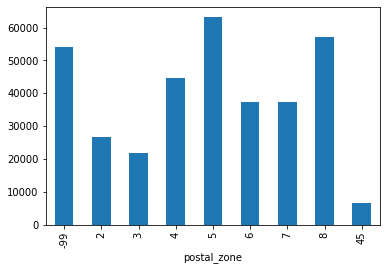

In [415]:
df.groupby('postal_zone')['brand_order_id'].nunique().plot(kind='bar')

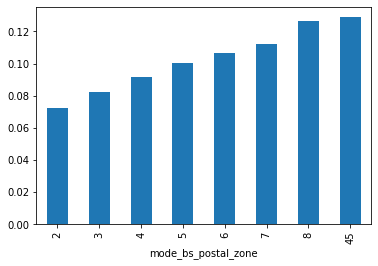

In [416]:
df_gb.groupby('mode_bs_postal_zone')['macro_avg_shipping_cost_fraction'].mean().plot(kind='bar')

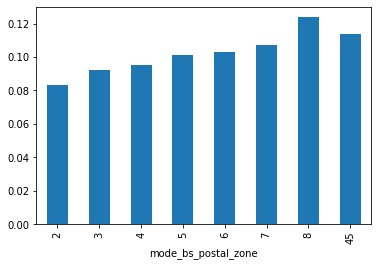

In [417]:
df_gb.groupby('mode_bs_postal_zone')['prediction'].mean().plot(kind='bar')

In [418]:
df_gb.columns

Index(['index', 'brand_id', 'retailer_state', 'historical_gmv_fraction',
       'brand_pct_swf', 'avg_weight_of_products', 'first_order_commission',
       'brand_pct_fedex', 'brand_pct_ups', 'brand_pct_usps', 'brand_location',
       'brand_state', 'brand_location_Canada',
       'brand_location_Middle Atlantic', 'brand_location_New England',
       'brand_location_Northeast Midwest', 'brand_location_Northwest Midwest',
       'brand_location_Pacific West', 'brand_location_South Atlantic',
       'brand_location_South East', 'brand_location_South West',
       'brand_location_Unknown', 'number_of_stockists_1001-2000',
       'number_of_stockists_2001-10000', 'number_of_stockists_251-1000',
       'number_of_stockists_51-250', 'number_of_stockists_<=50',
       'primary_brand_category', 'primary_brand_category_Accessories',
       'primary_brand_category_Beauty', 'primary_brand_category_Home Decor',
       'primary_brand_category_Jewelry', 'primary_brand_category_Kids',
       'primary

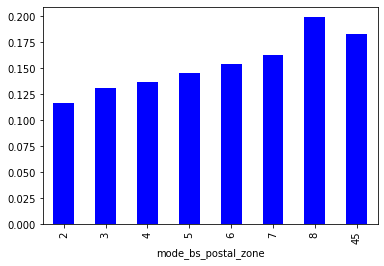

In [419]:
# fig, ax = plt.subplots(figsize=(12, 9));
width=0.35

bar1 = df_gb.loc[(df_gb['primary_brand_category']=='Kitchen')
#           & (df_gb['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar', label='Prediction', color='b');

plt.show()

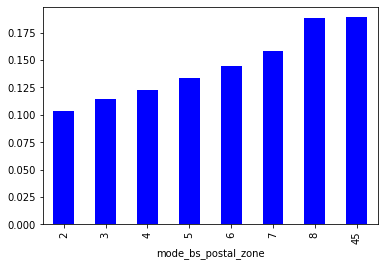

In [420]:
bar2 = df_gb.loc[(df_gb['primary_brand_category']=='Kitchen')
#           & (df_gb['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar', label='Label', color='b');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

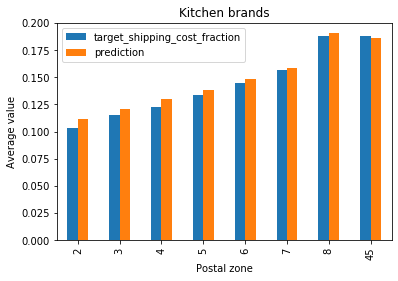

In [421]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Kitchen'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');
plt.show();

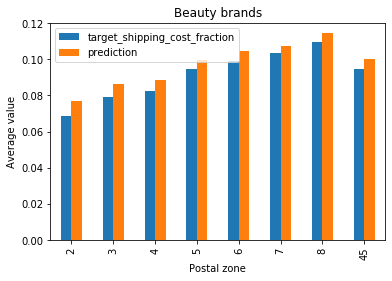

In [422]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Beauty'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

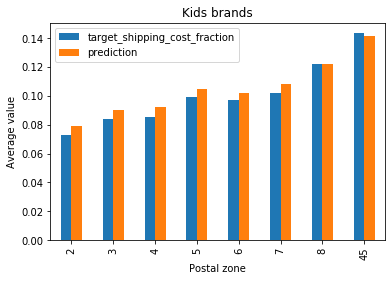

In [423]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Kids'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

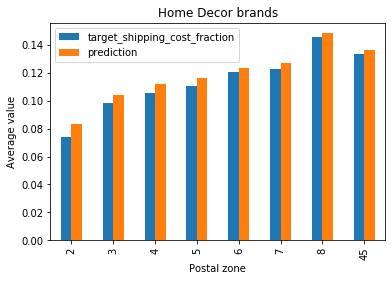

In [424]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Home Decor'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

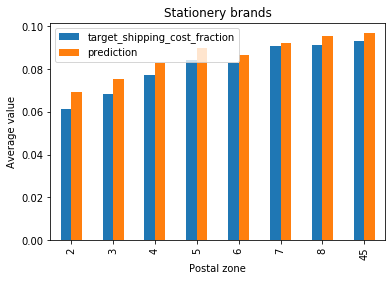

In [425]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Stationery'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

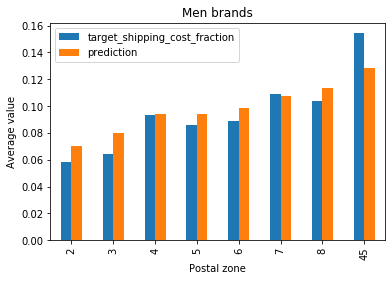

In [426]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Men'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

In [427]:
df_gb.shape

(209304, 92)

In [428]:
df_gb['prediction'].shape

(209304,)

In [429]:
df_val['prediction'].isna().sum()

0

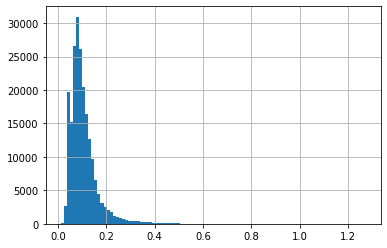

In [430]:
df_gb['prediction'].hist(bins=100)

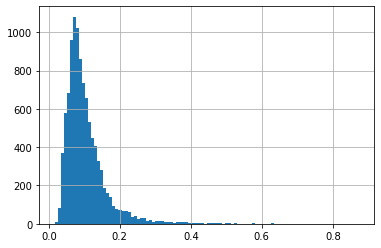

In [431]:
df_val['prediction'].hist(bins=100)

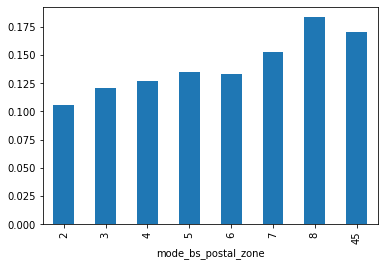

In [432]:
df_val.loc[df_val['primary_brand_category']=='Kitchen', :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar')

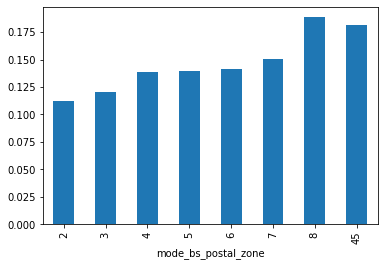

In [433]:
df_val.loc[df_val['primary_brand_category']=='Kitchen', :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar')

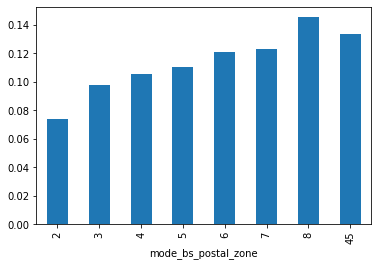

In [434]:
df_val_future.loc[df_val_future['primary_brand_category']=='Home Decor', :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar')

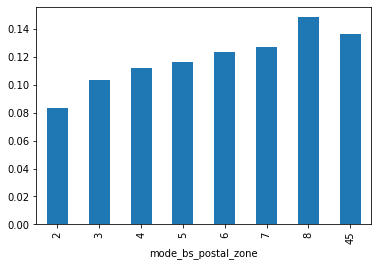

In [435]:
df_val_future.loc[df_val_future['primary_brand_category']=='Home Decor', :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar')

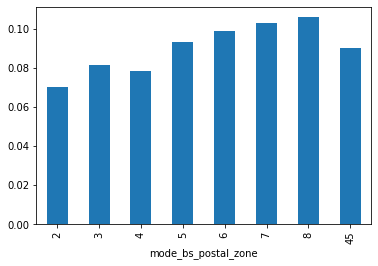

In [436]:
df_val.loc[df_val['primary_brand_category']=='Beauty', :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar')

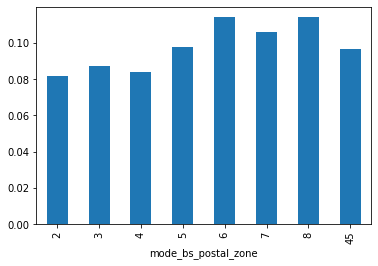

In [437]:
df_val.loc[df_val['primary_brand_category']=='Beauty', :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar')

In [438]:
df_top_vetoes = df_gb.loc[(df_gb['first_order_commission']==0.25) 
                   & (df_gb['mode_bs_postal_zone'] < 6)
                   , :
                  ]

In [439]:
df_gb['mode_bs_postal_zone'].value_counts()

5     48330
8     44968
6     32799
4     29947
7     28379
3     11893
2      9167
45     3821
Name: mode_bs_postal_zone, dtype: int64

In [440]:
df_top_vetoes['historical_gmv_fraction'].sum()

0.30815921430174836

In [441]:
df.shape

(348663, 85)

In [442]:
df.head(10)

,brand_order_id,is_cured,is_rr_cured,brand_order_created_date,brand_id,primary_brand_category,brand_location,avg_weight_of_products,retailer_location,commission,...,retailer_location_South Atlantic,retailer_location_South East,retailer_location_South West,retailer_location_Unknown,retailer_address_type_RESIDENTIAL,retailer_address_type_COMMERCIAL,insider_subscriber_Insider,insider_subscriber_Non-Insider,first_order_commission,coalesced_shipping_cost_dollars
0,93,1,1,2017-02-21 02:07:22,396,Home Decor,New England,2.002188,Pacific West,0.0,...,0,0,0,0,0,1,0,1,0.15,49.3700
1,763,1,1,2017-08-02 17:34:52,396,Home Decor,New England,2.002188,Pacific West,53.6,...,0,0,0,0,0,1,0,1,0.15,108.3400
2,872,1,1,2017-08-19 18:39:24,396,Home Decor,New England,2.002188,Pacific West,40.2,...,0,0,0,0,0,0,1,0,0.15,89.5900
3,11205,1,1,2018-01-30 21:51:50,396,Home Decor,New England,2.002188,Pacific West,30.0,...,0,0,0,0,0,1,0,1,0.15,47.4500
4,8697,1,1,2018-01-08 22:12:39,396,Home Decor,New England,2.002188,Pacific West,42.8,...,0,0,0,0,0,1,1,0,0.15,63.0400
5,13373,1,1,2018-02-16 22:13:12,396,Home Decor,New England,2.002188,Pacific West,21.0,...,0,0,0,0,0,1,0,1,0.15,31.4000
6,92,1,1,2017-02-21 02:07:22,396,Home Decor,New England,2.002188,Pacific West,0.0,...,0,0,0,0,0,1,1,0,0.15,49.3700
7,335,1,1,2017-05-09 17:35:33,396,Home Decor,New England,2.002188,Pacific West,20.4,...,0,0,0,0,0,1,0,1,0.15,38.3300
8,23494,1,1,2018-04-22 21:07:02,396,Home Decor,New England,2.002188,Pacific West,30.6,...,0,0,0,0,0,1,0,1,0.15,37.2600
9,1079,1,1,2017-09-07 00:30:49,396,Home Decor,New England,2.002188,Pacific West,47.4,...,0,0,0,0,0,1,0,1,0.15,74.3900


## Plot number of brands in each state

#### Pick your top selection

In [443]:
# df_top_final = df_top
df_top_final = df_stratified_top
# df_top_final = df_top_vetoes

In [444]:
df_top_final.shape

(85214, 92)

In [445]:
df_top_final['historical_gmv_fraction'].sum()

0.46783992626940657

In [446]:
df_top_final.loc[df_top_final['mode_bs_postal_zone']<8, 'historical_gmv_fraction'].sum()

0.3956524272220525

In [447]:
df_top_final.loc[df_top_final['mode_bs_postal_zone']<7, 'historical_gmv_fraction'].sum()

0.347038418602203

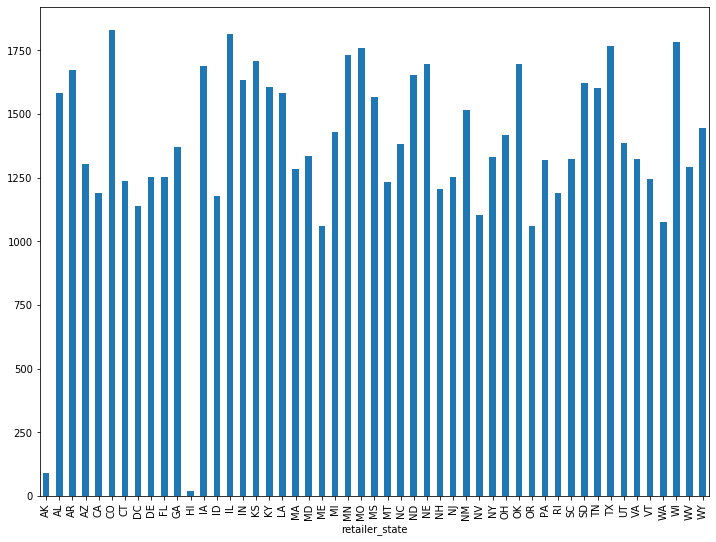

In [448]:
fig, ax = plt.subplots(figsize=(12,9));
df_top_final.loc[df_top_final['mode_bs_postal_zone']<8, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar');

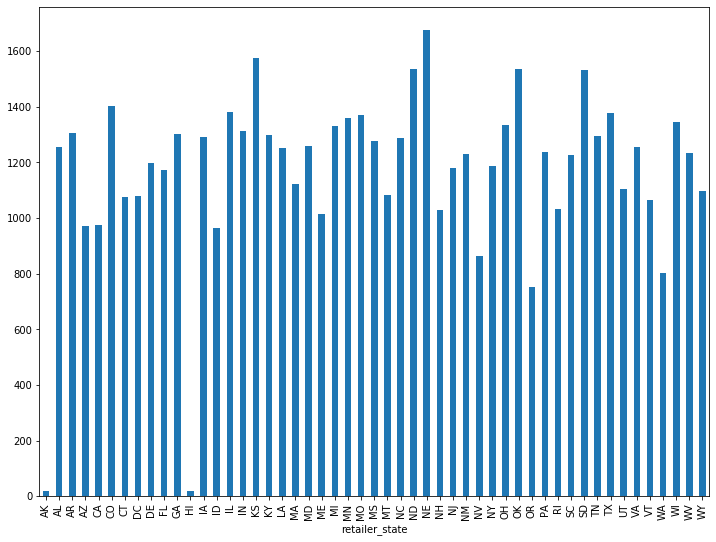

In [449]:
fig, ax = plt.subplots(figsize=(12,9));
df_top_final.loc[df_top_final['mode_bs_postal_zone']<7, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar');

Now let's make some plots

In [450]:
df_top_final['mode_bs_postal_zone'].isna().sum()

0

In [451]:
df_top_final['mode_bs_postal_zone'].notna().sum()

85214

In [452]:
df_gb['mode_bs_postal_zone'].isna().sum()/df_gb.shape[0]

0.0

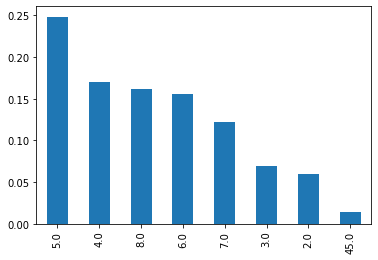

In [453]:
(df_top_final['mode_bs_postal_zone'].value_counts()/ df_top_final.shape[0]).plot(kind='bar')

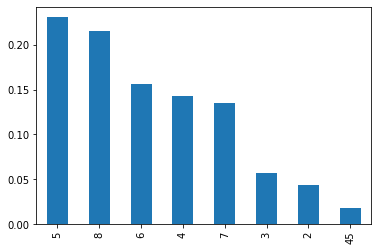

In [454]:
(df_gb['mode_bs_postal_zone'].value_counts()/ df_gb.shape[0]).plot(kind='bar')

In [455]:
df_gb.loc[df_gb['brand_id']==8718, 'retailer_state'].unique()

array(['MI', 'NC', 'MN', 'NJ', 'NV', 'IL', 'NH', 'OH', 'CO', 'MA', 'IN',
       'SC', 'WI', 'AL', 'PA', 'CT', 'WY', 'NY', 'MD', 'ID', 'KS', 'VA',
       'TX', 'TN', 'OR', 'FL', 'RI', 'OK', 'IA', 'MO', 'VT', 'AR', 'ME',
       'WV', 'NE', 'LA', 'MS', 'DE', 'HI', 'KY', 'GA', 'ND', 'SD', 'UT',
       'NM', 'CA', 'DC', 'WA', 'AK', 'MT', 'AZ'], dtype=object)

In [456]:
df_gb['historical_gmv_fraction'].sum()

0.9679835383513996

In [457]:
df_top_final['historical_gmv_fraction'].sum()

0.46783992626940657

In [458]:
df_top_final.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission,smoothed_return_rate_test
250758,250758.0,5954.0,VT,0.000256,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.007853,0.006597,0.021227,0.19,0.160004,0.019392
98868,98868.0,5954.0,CT,0.000015,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.009316,0.000032,0.022702,0.19,0.158529,0.019392
210254,210254.0,5954.0,NH,0.000019,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.012366,0.011909,0.023847,0.19,0.157384,0.019392
7734,7734.0,5954.0,ME,0.000021,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.017883,0.016644,0.026082,0.19,0.155149,0.019392
119120,119120.0,5954.0,MA,0.000007,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.018215,0.000032,0.026485,0.19,0.154746,0.019392


In [459]:
df_top_final.loc[df_top_final['primary_brand_category']=='Accessories', 'brand_id'].nunique()

450

In [460]:
df_gb['brand_id'].nunique()

4104

#### Remove zone 45

In [461]:
df_top_final = df_top_final.loc[~(df_top_final['mode_bs_postal_zone']==45), :]

In [462]:
df_top_final[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Home Decor         472
Accessories        450
Beauty             429
Kitchen            429
Stationery         337
Jewelry            303
Kids               110
Women's Apparel     84
Men                 49
Pets                42
Other               41
Name: primary_brand_category, dtype: int64

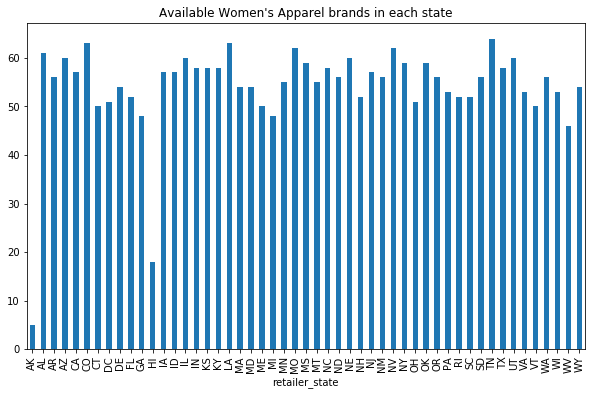

In [463]:
cat = 'Women\'s Apparel'
fig, ax = plt.subplots(figsize=(10,6));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

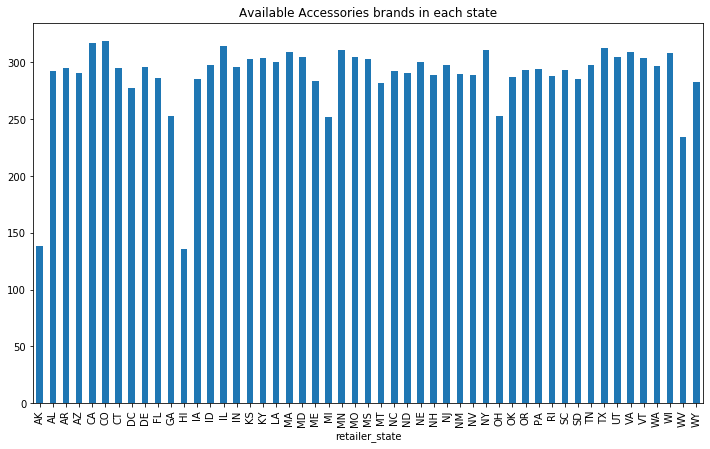

In [464]:
cat = 'Accessories'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

Text(0.5, 1.0, 'Available Kitchen brands in each state')

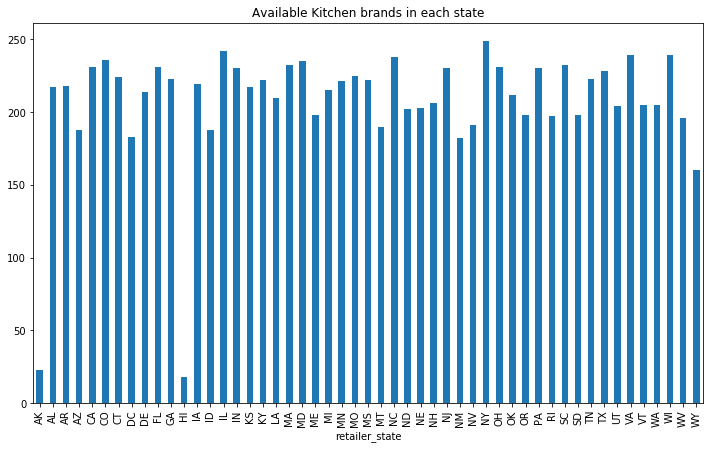

In [465]:
cat = 'Kitchen'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

In [466]:
df_top_final.loc[df_top_final['primary_brand_category']=='Kitchen',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

207.2549019607843

In [467]:
df_top_final.loc[df_top_final['primary_brand_category']=='Home Decor',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

280.8235294117647

Text(0.5, 1.0, 'Available Home Decor brands in each state')

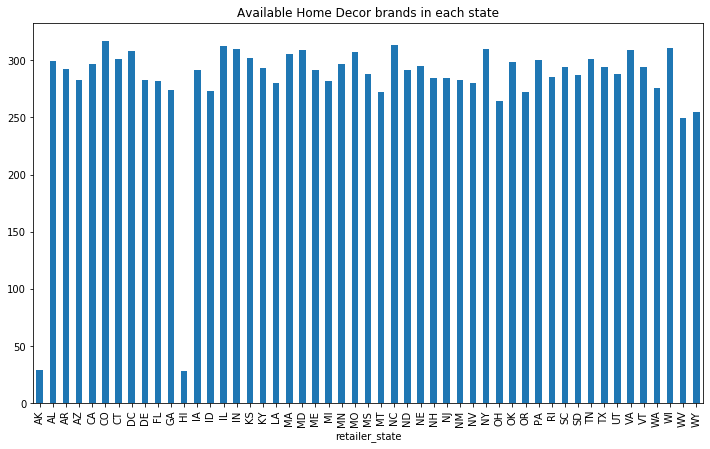

In [468]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

In [469]:
df_top_final = df_top_final.loc[~df_top_final['retailer_state'].isin(['HI','AK']), :]

#### Remove zone 8 for Kitchen and Home Decor

In [470]:
df_top_final = df_top_final.loc[
    ~(
        (df_top_final['primary_brand_category']=='Home Decor')
        & (df_top_final['mode_bs_postal_zone']==8)
    )
    , :
]

In [471]:
df_top_final = df_top_final.loc[
    ~(
        (df_top_final['primary_brand_category']=='Kitchen')
        & (df_top_final['mode_bs_postal_zone']==8)
    )
    , :
]

#### Home Decor and Kitchen after removing zone 8

Text(0.5, 1.0, 'Available Kitchen brands in each state')

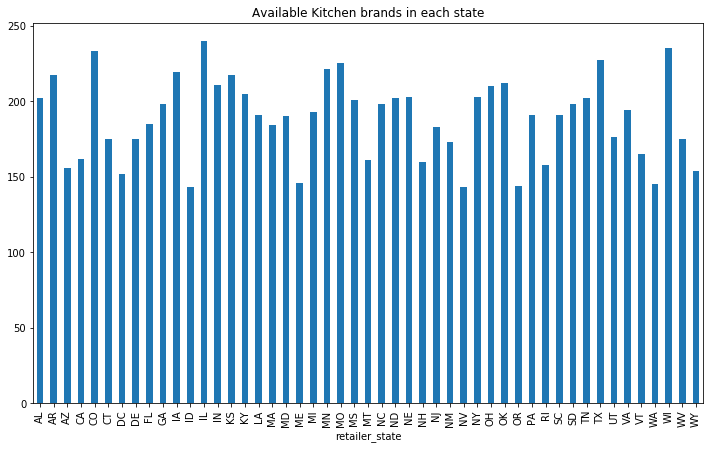

In [472]:
cat = 'Kitchen'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

Text(0.5, 1.0, 'Available Home Decor brands in each state')

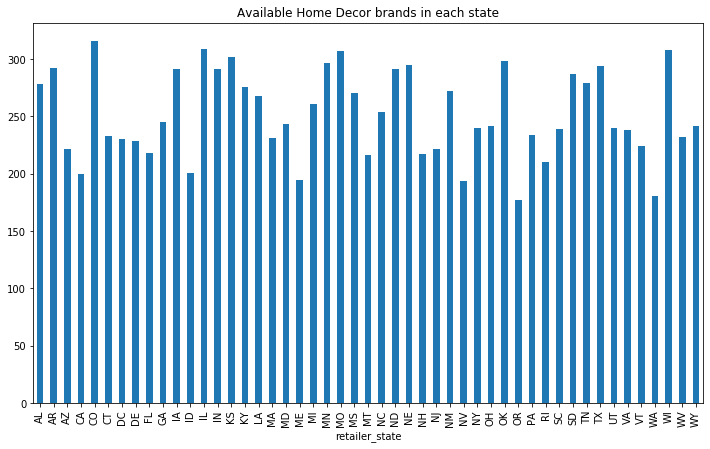

In [473]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

In [474]:
df_top_final.loc[df_top_final['primary_brand_category']=='Kitchen',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

188.6530612244898

In [475]:
df_top_final.loc[df_top_final['primary_brand_category']=='Home Decor',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

251.6530612244898

Text(0.5, 1.0, 'Available Jewelry brands in each state')

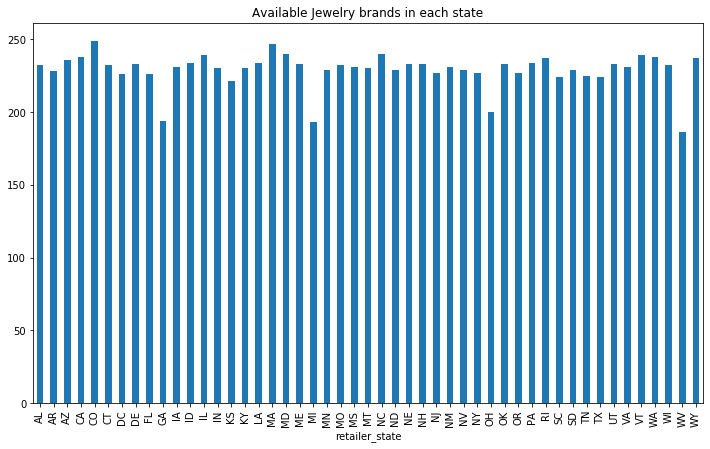

In [476]:
cat = 'Jewelry'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

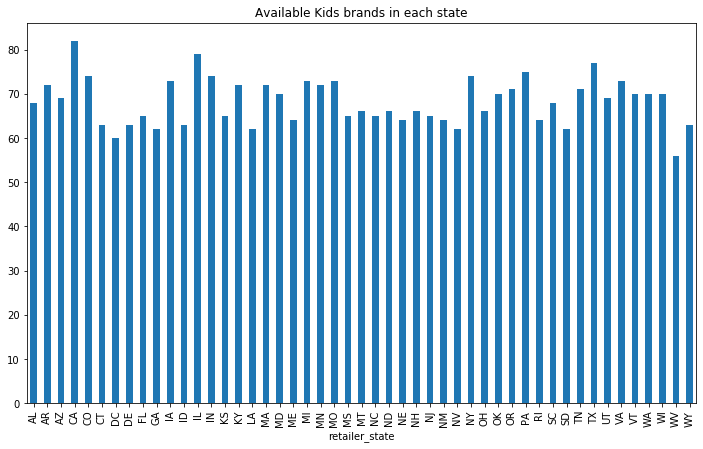

In [477]:
cat = 'Kids'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

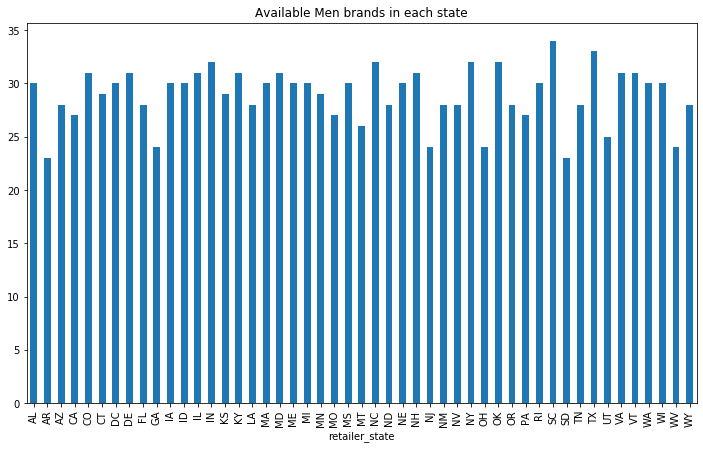

In [478]:
cat = 'Men'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

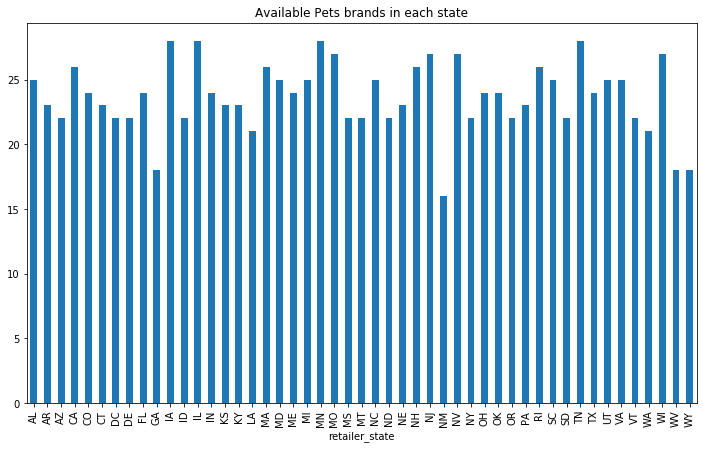

In [479]:
cat = 'Pets'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

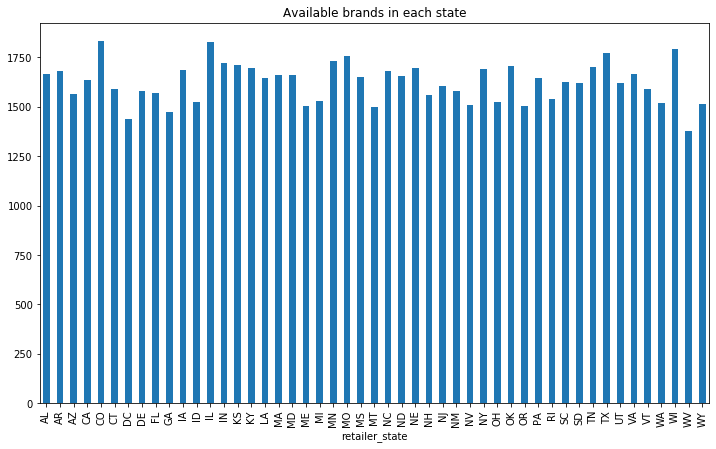

In [480]:
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available brands in each state');

## Tests

Check the brands in CA are different than the ones in NY

In [481]:
df_top_final['historical_gmv_fraction'].sum()

0.44222726667781076

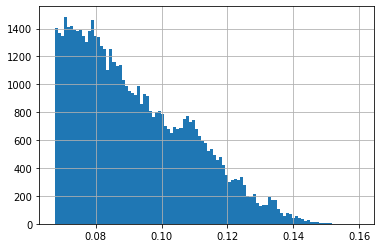

In [482]:
df_top['simplified_commission'].hist(bins=100)

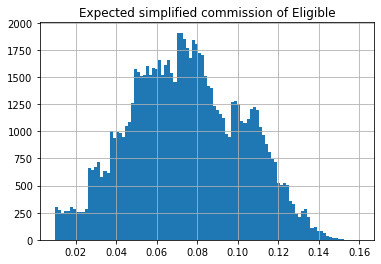

In [483]:
df_stratified_top['simplified_commission'].hist(bins=100);
plt.title('Expected simplified commission of Eligible');

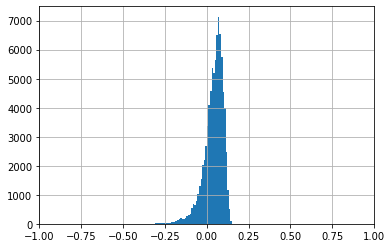

In [484]:
df_top_vetoes['simplified_commission'].hist(bins=100)
plt.xlim(-1.0, 1.0);

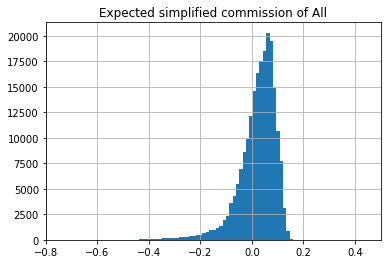

In [485]:
df_gb['simplified_commission'].hist(bins=100);
plt.xlim(-0.8, 0.5);
plt.title('Expected simplified commission of All');

#### Simplified commission

In [486]:
df_gb['simplified_commission'].mean()

0.02168555415257629

In [487]:
df_top['simplified_commission'].mean()

0.09160680868469784

In [488]:
df_stratified_top['simplified_commission'].mean()

0.07444381282221962

In [489]:
df_top_vetoes['simplified_commission'].mean()

0.04063696567935131

#### First order commission

In [490]:
df_gb[['brand_id','first_order_commission']].drop_duplicates().mean()

brand_id                  16621.361598
first_order_commission        0.234790
dtype: float64

In [491]:
df_top[['brand_id','first_order_commission']].drop_duplicates().mean()

brand_id                  17595.613761
first_order_commission        0.245596
dtype: float64

In [492]:
# df_stratified_top['first_order_commission'].mean()
df_stratified_top[['brand_id','first_order_commission']].drop_duplicates().mean()

brand_id                  17613.824600
first_order_commission        0.243663
dtype: float64

In [493]:
df_gb['first_order_commission'].mean()

0.23479044834307997

In [494]:
df_stratified_top['first_order_commission'].mean()

0.2463026615344896

#### Return Rates

In [495]:
df_gb[['brand_id','smoothed_return_rate']].drop_duplicates().mean()

brand_id                16621.361598
smoothed_return_rate        0.111673
dtype: float64

In [496]:
df_top[['brand_id','smoothed_return_rate']].drop_duplicates().mean()

brand_id                17595.613761
smoothed_return_rate        0.073895
dtype: float64

In [497]:
# df_stratified_top['first_order_commission'].mean()
df_stratified_top[['brand_id','smoothed_return_rate']].drop_duplicates().mean()

brand_id                17613.824600
smoothed_return_rate        0.082889
dtype: float64

In [498]:
df_gb['smoothed_return_rate'].mean()

0.11167308980859454

In [499]:
df_stratified_top['smoothed_return_rate'].mean()

0.0708137420206612

#### SwF Adoption

In [500]:
df_gb[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         16621.361598
brand_pct_swf        0.455014
dtype: float64

In [501]:
df_top[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         17595.613761
brand_pct_swf        0.544757
dtype: float64

In [502]:
df_stratified_top[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         17613.824600
brand_pct_swf        0.525545
dtype: float64

In [503]:
df_gb[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         16621.361598
brand_pct_swf        0.455014
dtype: float64

In [504]:
df_gb['brand_pct_swf'].mean()

0.45501372799815426

In [505]:
df_stratified_top['brand_pct_swf'].mean()

0.6016657852724595

#### Postal zones

In [506]:
df_gb['mode_bs_postal_zone'].mean()

6.414531017085197

In [507]:
df_stratified_top['mode_bs_postal_zone'].mean()

5.95985401459854

In [508]:
df_gb.loc[df_gb['primary_brand_category']=='Kitchen', 'mode_bs_postal_zone'].mean()

6.273778167983611

In [509]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Kitchen', 'mode_bs_postal_zone'].mean()

5.485837553929844

In [510]:
df_gb.loc[df_gb['primary_brand_category']=='Home Decor', 'mode_bs_postal_zone'].mean()

6.304826317819109

In [511]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Home Decor', 'mode_bs_postal_zone'].mean()

5.761290767427429

In [512]:
df_gb.loc[df_gb['primary_brand_category']=='Jewelry', 'mode_bs_postal_zone'].mean()

6.404486540378864

In [513]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Jewelry', 'mode_bs_postal_zone'].mean()

6.189939876365484

In [514]:
df_gb.loc[:, 'mode_bs_postal_zone'].value_counts() \
/ df_gb.shape[0]

5     0.230908
8     0.214845
6     0.156705
4     0.143079
7     0.135587
3     0.056822
2     0.043798
45    0.018256
Name: mode_bs_postal_zone, dtype: float64

In [515]:
df_stratified_top.loc[:, 'mode_bs_postal_zone'].value_counts() \
/df_stratified_top.shape[0]

5.0     0.248234
4.0     0.169902
8.0     0.161640
6.0     0.155749
7.0     0.121811
3.0     0.068932
2.0     0.059673
45.0    0.014059
Name: mode_bs_postal_zone, dtype: float64

In [516]:
df_gb.loc[df_gb['primary_brand_category']=='Kitchen', 'mode_bs_postal_zone'].value_counts() \
/ df_gb.loc[df_gb['primary_brand_category']=='Kitchen', :].shape[0]

5     0.230904
8     0.223112
6     0.147351
4     0.144571
7     0.132060
3     0.058604
2     0.048398
45    0.014999
Name: mode_bs_postal_zone, dtype: float64

In [517]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Kitchen',
                      'mode_bs_postal_zone'].value_counts() \
/df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Kitchen', :].shape[0]

5.0     0.265241
4.0     0.196398
6.0     0.140874
8.0     0.123148
7.0     0.108422
3.0     0.081786
2.0     0.075502
45.0    0.008629
Name: mode_bs_postal_zone, dtype: float64

In [518]:
df_stratified_top.loc[(df_stratified_top['primary_brand_category']=='Kitchen')
                      & (df_stratified_top['mode_bs_postal_zone']==8),
                      'brand_pct_swf'
                     ].mean()

0.6743554856026565

In [519]:
df_stratified_top.loc[(df_stratified_top['primary_brand_category']=='Kitchen')
                      & (df_stratified_top['mode_bs_postal_zone']==8),
                      'smoothed_return_rate'
                     ].mean()

0.07030124217844057

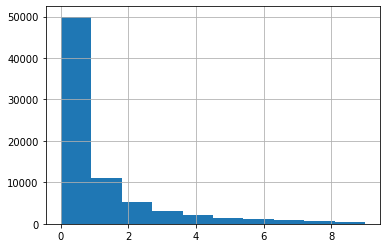

In [520]:
df_top_final.loc[df_top_final['num_brand_orders_to_state']<10, 'num_brand_orders_to_state'].hist(bins=10)

In [521]:
df_gb[target].mean()

0.09757058259206745

In [522]:
df_top[target].mean()

0.05481673656731985

In [523]:
df_stratified_top[target].mean()

0.06647704050760245

In [524]:
df_top_vetoes[target].mean()

0.08751445503666902

In [525]:
df_gb['brand_pct_swf'].mean()

0.45501372799815426

In [526]:
df_gb['brand_pct_fedex'].mean()

0.16082472084766247

In [527]:
df_top_final[['primary_brand_category','brand_id']].drop_duplicates().head(10)

,primary_brand_category,brand_id
250758,Jewelry,5954.0
158601,Jewelry,4912.0
200026,Jewelry,32760.0
184045,Jewelry,7113.0
1134,Jewelry,11773.0
47859,Jewelry,29935.0
5972,Jewelry,9581.0
209638,Jewelry,11747.0
1609,Jewelry,14359.0
1325,Jewelry,14134.0


In [528]:
df_top_final.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission,smoothed_return_rate_test
250758,250758.0,5954.0,VT,0.000256,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.007853,0.006597,0.021227,0.19,0.160004,0.019392
98868,98868.0,5954.0,CT,0.000015,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.009316,0.000032,0.022702,0.19,0.158529,0.019392
210254,210254.0,5954.0,NH,0.000019,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.012366,0.011909,0.023847,0.19,0.157384,0.019392
7734,7734.0,5954.0,ME,0.000021,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.017883,0.016644,0.026082,0.19,0.155149,0.019392
119120,119120.0,5954.0,MA,0.000007,0.0,0.309672,0.25,0.0,0.0,0.680851,...,0.0,0.0,0.0,0.0,0.018215,0.000032,0.026485,0.19,0.154746,0.019392


In [529]:
df_top_final.loc[(df_top_final['brand_state']=='CA')
                & (df_top_final['primary_brand_category']=='Kitchen')
                , ['retailer_state', 'prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
NC    0.067638
PA    0.069956
MD    0.070052
CA    0.082256
FL    0.085896
MA    0.087137
TX    0.091984
OR    0.098326
IL    0.098495
MN    0.099768
WI    0.100381
CO    0.101687
KS    0.101699
AZ    0.101824
IA    0.101836
WA    0.102018
NV    0.102858
NE    0.103139
UT    0.103922
MS    0.104551
ID    0.104572
LA    0.105694
KY    0.105759
TN    0.106607
MO    0.106944
NM    0.107055
CT    0.107068
AR    0.107961
OK    0.108090
IN    0.109037
MT    0.109067
SD    0.109077
AL    0.109580
ND    0.110960
NY    0.112359
WY    0.112612
MI    0.121030
NJ    0.148397
OH    0.154666
Name: prediction, dtype: float32

In [530]:
df_top_final.loc[(df_top_final['brand_state']=='NY')
                & (df_top_final['primary_brand_category']=='Kitchen')
                , ['retailer_state', 'prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
CA    0.079486
NY    0.091773
NJ    0.094826
PA    0.096842
OH    0.097475
MA    0.099336
MD    0.100004
MI    0.101311
RI    0.101746
VA    0.103188
CT    0.103240
NC    0.103295
ME    0.103871
WY    0.105542
NH    0.105602
TN    0.105640
AL    0.106097
VT    0.106749
IL    0.107331
WI    0.107667
MN    0.107671
FL    0.107708
TX    0.108439
CO    0.109193
IN    0.109306
KY    0.109333
SC    0.109952
DC    0.110265
DE    0.110275
GA    0.111618
WV    0.111976
AR    0.112737
MO    0.113693
SD    0.114525
LA    0.115652
IA    0.115769
MS    0.116543
NE    0.116579
KS    0.116874
NM    0.117723
OK    0.118728
ND    0.120312
Name: prediction, dtype: float32

In [531]:
df_gb['brand_pct_swf'].mean()

0.45501372799815426

In [532]:
df_gb['prediction'].mean()

0.105102554

In [533]:
df_top['prediction'].mean()

0.064149514

In [534]:
df_stratified_top['prediction'].mean()

0.07877934

In [535]:
df_top_vetoes['prediction'].mean()

0.09577326

In [536]:
cat = 'Kitchen'

brands_CA = df_top_final.loc[(df_top_final['primary_brand_category']==cat)
                       & (df_top_final['retailer_state']=='CA')
                       , 'brand_id'].unique()
brands_NY = df_top_final.loc[(df_top_final['primary_brand_category']==cat)
                       & (df_top_final['retailer_state']=='NY')
                       , 'brand_id'].unique()

In [537]:
brands_CA.shape

(162,)

In [538]:
brands_NY.shape

(203,)

In [539]:
brands_CA[:5]

array([18118., 36513., 12162., 14517., 26602.])

In [540]:
brands_NY[:5]

array([ 9327., 32067., 14517., 34029., 31298.])

In [541]:
pd.Series(brands_CA).append(pd.Series(brands_NY)).nunique()

322

## Add new or uncured brands

In [542]:
query_brands_low_zones = \
'''
WITH new_arrivals AS (
  SELECT 
      bls.brand_id
    , b.based_in_state as brand_state
  
  FROM etl.core_brand_lifetime_summary bls
  JOIN production.brands b
    ON b.id = bls.brand_id
  WHERE bls.brand_first_first_active_at > getdate() - interval '22 days'
)

, uncured_brands AS (
  SELECT 
        bos.brand_id
      , b.based_in_state as brand_state
      , COUNT(DISTINCT CASE WHEN bos.brand_order_created_date < getdate() - interval '70 days' THEN bos.brand_order_id END) 
        as num_cured_brand_orders
  
  FROM production.brands b
  LEFT JOIN etl.brand_order_summary bos
    ON bos.brand_id = b.id
  WHERE b.active=true
  
  GROUP BY 1, 2
  HAVING num_cured_brand_orders < 4
)

-- Now done in backend
-- SELECT *
-- FROM new_arrivals
-- WHERE brand_state is not null
-- UNION

SELECT brand_id, brand_state
FROM uncured_brands
WHERE brand_state is not null
  AND brand_id is not null
'''

In [543]:
df_brands_low_zones = query_to_df(query_brands_low_zones)

INFO:sqlalchemy.engine.base.Engine:/* INTERMIX_ID: eyJmb3JtYXQiOiAiaW50ZXJtaXgiLCAidmVyc2lvbiI6ICIxIiwgInBsdWdpbiI6ICJpbnRlcm1peC1weXRob24tcGx1Z2luIiwgInBsdWdpbl92ZXIiOiAiMC43IiwgImFwcCI6ICJkYXRhc2NpZW5jZS1kZWZhdWx0IiwgInVzZXIiOiAiIiwgImFwcF92ZXIiOiAiSEVBRCIsICJkYWciOiAiZGVmYXVsdCIsICJ0YXNrIjogImRlZmF1bHQiLCAiYXQiOiAiMjAyMC0wMi0yM1QwNDoyOTo0OC40MzIxNTNaIiwgImZpbGUiOiAiL1VzZXJzL3BlZHJvc2FsZXNkZWJydWluL0RldmVsb3BtZW50L2RhdGFzY2llbmNlL2RhdGFzY2llbmNlL3NyYy9weXRob24vZmFpcmUvZGF0YXNjaWVuY2UvdmVuZG9yL2F3cy9yZWRzaGlmdC9fZXhlY19zcWwucHkiLCAibW9kdWxlIjogIl9fbWFpbl9fIiwgImNsYXNzbmFtZSI6ICIiLCAiZnVuY3Rpb24iOiAicXVlcnlfdG9fZGYiLCAibGluZW51bWJlciI6ICIyNyIsICJtZXRhIjoge319 */ 
WITH new_arrivals AS (
  SELECT 
      bls.brand_id
    , b.based_in_state as brand_state
  
  FROM etl.core_brand_lifetime_summary bls
  JOIN production.brands b
    ON b.id = bls.brand_id
  WHERE bls.brand_first_first_active_at > getdate() - interval '22 days'
)

, uncured_brands AS (
  SELECT 
        bos.brand_id
      , b

In [544]:
df_brands_low_zones['brand_id'].nunique()

2200

In [545]:
df_brands_low_zones = df_brands_low_zones.loc[~df_brands_low_zones['brand_id'].isin(df_gb['brand_id']), :]

In [546]:
a = df_brands_low_zones['brand_id'].unique().tolist()
b = df_state_locations['retailer_state'].unique().tolist()

index = pd.MultiIndex.from_product([a, b], names = ["brand_id", "retailer_state"])

In [547]:
df_temp = pd.DataFrame(index = index).reset_index();

df_brands_low_zones = df_brands_low_zones.merge(df_temp, on='brand_id')

In [548]:
df_brands_low_zones.head()

,brand_id,brand_state,retailer_state
0,121114,NY,CA
1,121114,NY,ME
2,121114,NY,TX
3,121114,NY,MS
4,121114,NY,MN


In [549]:
us_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [550]:
df_brands_low_zones = df_brands_low_zones.loc[(df_brands_low_zones['brand_state'].isin(us_states))
                                              & (df_brands_low_zones['retailer_state'].isin(us_states))
                                              ,:]

In [551]:
df_brands_low_zones = add_to_df_gb(df_brands_low_zones, df, 'postal_zone'
                                   , gb_cols = ['brand_state', 'retailer_state']
                                   , aggtypes=['mode']
                                   , prefix='bsrs')

In [552]:
df_brands_low_zones.head(20)

,brand_id,brand_state,retailer_state,mode_bsrs_postal_zone
0,121114,NY,CA,8.0
1,121114,NY,ME,3.0
2,121114,NY,TX,7.0
3,121114,NY,MS,6.0
4,121114,NY,MN,5.0
5,121114,NY,NJ,2.0
6,121114,NY,OR,8.0
7,121114,NY,MD,3.0
8,121114,NY,MO,5.0
9,121114,NY,NY,2.0


In [553]:
# df_brands_low_zones = df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone']<=4, :]

In [554]:
df_brands_low_zones.shape

(102357, 4)

In [555]:
df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone'].isna(), :].head()

,brand_id,brand_state,retailer_state,mode_bsrs_postal_zone
992,30106,NE,NV,NaN
994,30106,NE,HI,NaN
1011,30106,NE,DE,NaN
2205,63015,HI,UT,NaN
2207,63015,HI,AR,NaN


In [556]:
df_brands_low_zones.head(10)

,brand_id,brand_state,retailer_state,mode_bsrs_postal_zone
0,121114,NY,CA,8.0
1,121114,NY,ME,3.0
2,121114,NY,TX,7.0
3,121114,NY,MS,6.0
4,121114,NY,MN,5.0
5,121114,NY,NJ,2.0
6,121114,NY,OR,8.0
7,121114,NY,MD,3.0
8,121114,NY,MO,5.0
9,121114,NY,NY,2.0


In [557]:
# df_top_final.groupby('mode_bsrs_postal_zone')['prediction'].mean()

# This is the new block:

## Context from Ian

1. Maker experience: As a maker, I need to know my retailer reach as I move my slider on shipping subsidy

2. Baseline state: 50% threshold

3. Keep bottom X percentile of retailers states for remaining subsidy percentages to guarantee a increase (even small) of # of insiders covered all the way to 100% subsidy

#### We want brands with subsidies to have simplified commission greater than the mins in each category

In [558]:
df_top_final.groupby('primary_brand_category')['simplified_commission'].min()

primary_brand_category
Accessories        0.048252
Beauty             0.037159
Home Decor         0.026056
Jewelry            0.096877
Kids               0.049621
Kitchen            0.009611
Men                0.042429
Other              0.017419
Pets               0.057402
Stationery         0.069886
Women's Apparel    0.044664
Name: simplified_commission, dtype: float64

In [559]:
min_subsidies_by_category = df_top_final.groupby('primary_brand_category')['simplified_commission'].min()

In [560]:
min_sunsidies_dict = dict(min_subsidies_by_category)

In [561]:
min_sunsidies_dict

{'Accessories': 0.048252408500230104,
 'Beauty': 0.03715907588058753,
 'Home Decor': 0.026056006143014704,
 'Jewelry': 0.09687735711402365,
 'Kids': 0.04962069558847848,
 'Kitchen': 0.009611133031579178,
 'Men': 0.04242904275693671,
 'Other': 0.017418633505121378,
 'Pets': 0.05740169211440396,
 'Stationery': 0.06988558443696644,
 "Women's Apparel": 0.04466436478891163}

In [562]:
# df_top_final['brand_swf_bin'] = df_top_final['brand_pct_swf'].apply(
#     lambda x: math.floor(x*10) / 10.0
# )

In [563]:
# df_top_final['brand_swf_bin'].hist(bins=10)

In [564]:
# df_top_final.loc[
# #     df_top_final['mode_bs_postal_zone']==4
#     :
#     , ['brand_swf_bin', 'target_shipping_cost_fraction']
# ].groupby('brand_swf_bin')['target_shipping_cost_fraction'].mean().plot()

In [565]:
# df_top_final[['brand_pct_swf', 'target_shipping_cost_fraction']].head()

In [566]:
# df_gb['simplified_commission'].head()

In [567]:
# df_gb['prediction'].hist(bins=50)

In [568]:
# (10/100)*df_gb['prediction'].head()

In [569]:
# (df_gb['simplified_commission'] + (100/100)*df_gb['prediction']).head(20)

In [570]:
# for s in range(10, 101, 10):
#     print(s)
# #     print((s/100)*df_gb['prediction'].head())
#     df_gb.loc[:, 'expected_commission_subsidy_'+str(s)+'pct'] = \
#     df_gb['simplified_commission'] + (s/100)*df_gb['prediction']
# #     + 0.005 * df_gb['brand_pct_swf'].apply(lambda x: 1.0 if x < 0.5 else 0.0)

In [571]:
# df_gb.sort_values(by='brand_id').head()

## Make a subsidy dataframe

In [572]:
df_subsidy = df_gb[
    ['brand_id',
     'retailer_state',
     'primary_brand_category',
     'mode_bs_postal_zone',
     'historical_gmv_fraction',
     'target_shipping_cost_fraction',
     'prediction',
     'simplified_commission',
    ]
]

### At this point all brands have all states as rows

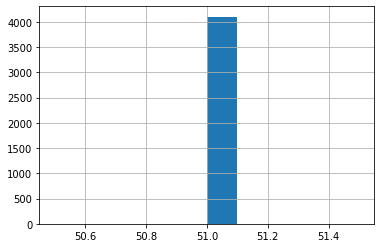

In [573]:
df_subsidy.groupby('brand_id')['retailer_state'].nunique().hist()

In [574]:
df_subsidy.loc[:, 'eligible_0pct_subsidy'] = df_subsidy.apply(
    lambda x: x['simplified_commission'] > min_sunsidies_dict[x['primary_brand_category']]
    , axis = 1
)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### A chunk are already eligible with no subsidies at this point:

In [575]:
df_gb[target].max()

1.7022222222222223

In [576]:
df_gb[target].min()

0.0

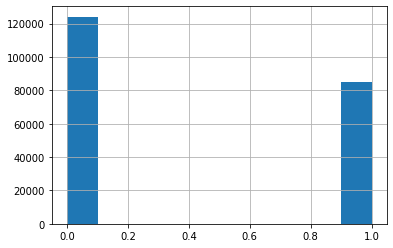

In [577]:
df_subsidy['eligible_0pct_subsidy'].astype(int).hist()

In [578]:
df_subsidy.head()

,brand_id,retailer_state,primary_brand_category,mode_bs_postal_zone,historical_gmv_fraction,target_shipping_cost_fraction,prediction,simplified_commission,eligible_0pct_subsidy
250758,5954,VT,Jewelry,2,0.000256,0.006597,0.021227,0.160004,True
98868,5954,CT,Jewelry,3,0.000015,0.000032,0.022702,0.158529,True
210254,5954,NH,Jewelry,2,0.000019,0.011909,0.023847,0.157384,True
7734,5954,ME,Jewelry,2,0.000021,0.016644,0.026082,0.155149,True
119120,5954,MA,Jewelry,3,0.000007,0.000032,0.026485,0.154746,True


In [579]:
# df_test = df_top_final.loc[df_top_final['target_shipping_cost_fraction']>0, ['prediction', 'target_shipping_cost_fraction']]

# ((df_test['prediction'] - df_test['target_shipping_cost_fraction'])/df_test['prediction']).hist(bins=100)
# plt.xlim(-2, 2)

In [580]:
# (df_test['prediction'] - df_test['target_shipping_cost_fraction']).hist(bins=200)
# plt.xlim(-0.2, 0.2)

In [581]:
# for s in range(10, 101, 10):
#     print(s)
#     df_subsidy['eligible_'+str(s)+'pct_subsidy'] = df_subsidy.apply(
#         lambda x: x['expected_commission_subsidy_'+str(s)+'pct'] > min_sunsidies_dict[x['primary_brand_category']]
#         , axis = 1
#     )

In [582]:
df_subsidy['simplified_commission'].head()

250758    0.160004
98868     0.158529
210254    0.157384
7734      0.155149
119120    0.154746
Name: simplified_commission, dtype: float64

In [583]:
df_subsidy.head()

,brand_id,retailer_state,primary_brand_category,mode_bs_postal_zone,historical_gmv_fraction,target_shipping_cost_fraction,prediction,simplified_commission,eligible_0pct_subsidy
250758,5954,VT,Jewelry,2,0.000256,0.006597,0.021227,0.160004,True
98868,5954,CT,Jewelry,3,0.000015,0.000032,0.022702,0.158529,True
210254,5954,NH,Jewelry,2,0.000019,0.011909,0.023847,0.157384,True
7734,5954,ME,Jewelry,2,0.000021,0.016644,0.026082,0.155149,True
119120,5954,MA,Jewelry,3,0.000007,0.000032,0.026485,0.154746,True


In [584]:
df_subsidy.loc[:, 'min_eligible_subsidy_bps'] = 10000
for s in reversed(range(0, 101, 1)):
    print(s)
    df_subsidy.loc[:, ['min_eligible_subsidy_bps']] = df_subsidy[
        [
            'simplified_commission',
            'primary_brand_category',
            'prediction',
            'min_eligible_subsidy_bps'
        ]
    ].apply(
        lambda x: 100*s 
        if x['simplified_commission'] + (s/100)*x['prediction'] > min_sunsidies_dict[x['primary_brand_category']]
        else x['min_eligible_subsidy_bps']
        , axis=1
    )

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


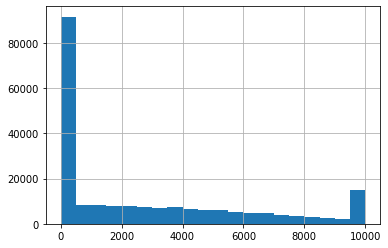

In [585]:
df_subsidy['min_eligible_subsidy_bps'].hist(bins=20)

In [586]:
df_subsidy.head()

,brand_id,retailer_state,primary_brand_category,mode_bs_postal_zone,historical_gmv_fraction,target_shipping_cost_fraction,prediction,simplified_commission,eligible_0pct_subsidy,min_eligible_subsidy_bps
250758,5954,VT,Jewelry,2,0.000256,0.006597,0.021227,0.160004,True,0
98868,5954,CT,Jewelry,3,0.000015,0.000032,0.022702,0.158529,True,0
210254,5954,NH,Jewelry,2,0.000019,0.011909,0.023847,0.157384,True,0
7734,5954,ME,Jewelry,2,0.000021,0.016644,0.026082,0.155149,True,0
119120,5954,MA,Jewelry,3,0.000007,0.000032,0.026485,0.154746,True,0


In [587]:
# df_subsidy['inserted_at'] = datetime.date(datetime.now()).strftime("%Y-%m-%d")

### Add the same vetoes as before

No HI or AK:

In [588]:
df_subsidy = df_subsidy.loc[~df_subsidy['retailer_state'].isin(['HI','AK']), :]

No zone 45

In [589]:
df_subsidy = df_subsidy.loc[~(df_subsidy['mode_bs_postal_zone']==45), :]

No zone8 for Kitchen and Home Decor

In [590]:
df_subsidy = df_subsidy.loc[
    ~(
        (df_subsidy['primary_brand_category']=='Home Decor')
        & (df_subsidy['mode_bs_postal_zone']==8)
    )
    , :
]

In [591]:
df_subsidy = df_subsidy.loc[
    ~(
        (df_subsidy['primary_brand_category']=='Kitchen')
        & (df_subsidy['mode_bs_postal_zone']==8)
    )
    , :
]

In [592]:
df_brands_low_zones['mode_bsrs_postal_zone'].fillna(8, inplace=True)

In [593]:
df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone']<=4, 'min_eligible_subsidy_bps'] = 0
df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone']>4, 'min_eligible_subsidy_bps'] = 10000

In [594]:
df_brands_low_zones['mode_bsrs_postal_zone'].isna().sum()

0

In [595]:
df_subsidy['inserted_at'] = datetime.date(datetime.now()).strftime("%Y-%m-%d")
df_brands_low_zones['inserted_at'] = datetime.date(datetime.now()).strftime("%Y-%m-%d")

In [596]:
cols_to_write = [
    'brand_id',
    'retailer_state',
    'min_eligible_subsidy_bps',
    'inserted_at',
]

In [597]:
print(cols_to_write)

['brand_id', 'retailer_state', 'min_eligible_subsidy_bps', 'inserted_at']


In [598]:
df_subsidy[cols_to_write].head()

,brand_id,retailer_state,min_eligible_subsidy_bps,inserted_at
250758,5954,VT,0,2020-02-22
98868,5954,CT,0,2020-02-22
210254,5954,NH,0,2020-02-22
7734,5954,ME,0,2020-02-22
119120,5954,MA,0,2020-02-22


In [599]:
df_subsidy[cols_to_write].shape

(186556, 4)

In [600]:
df_to_write = df_subsidy[cols_to_write]

In [601]:
random_brand = df_subsidy['brand_id'].sample(1).values[0]
print(random_brand)
df_subsidy.loc[df_subsidy['brand_id']==random_brand, 
               ['brand_id', 'retailer_state', 'min_eligible_subsidy_bps']].sort_values(by='brand_id').head(100)

10331


,brand_id,retailer_state,min_eligible_subsidy_bps
101944,10331,WY,10000
152574,10331,IL,10000
15873,10331,MS,10000
223456,10331,WV,10000
86755,10331,NC,10000
112070,10331,VA,10000
182952,10331,TN,10000
91818,10331,ND,10000
96881,10331,CT,10000
167763,10331,FL,10000


## Validation

In [602]:
df_subsidy[cols_to_write]['brand_id'].nunique()

4104

In [603]:
# df_subsidy[cols_to_write].groupby('retailer_state')['brand_id'].nunique().mean()

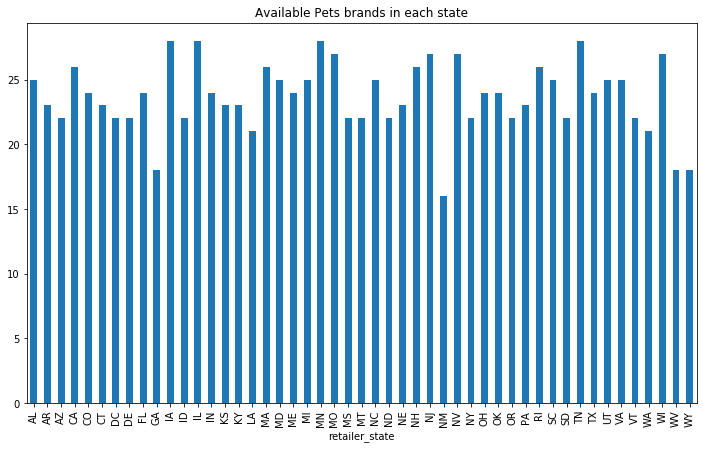

In [604]:
cat = 'Pets'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

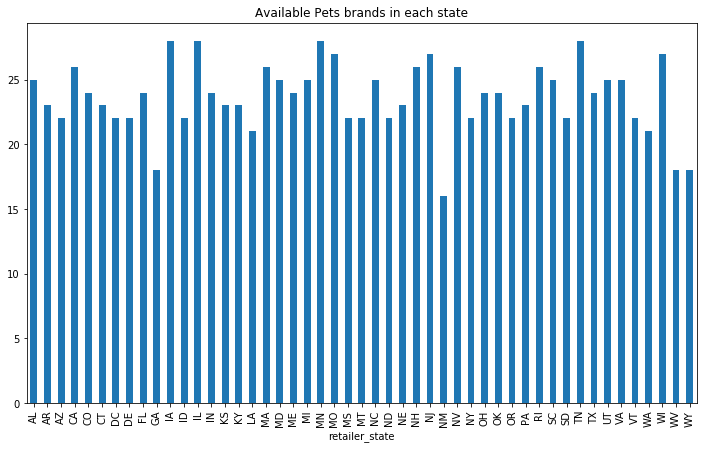

In [605]:
cat = 'Pets'
fig, ax = plt.subplots(figsize=(12,7));
df_currently_eligible = df_subsidy.loc[df_subsidy['min_eligible_subsidy_bps']==0, :]
df_currently_eligible.loc[df_currently_eligible['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

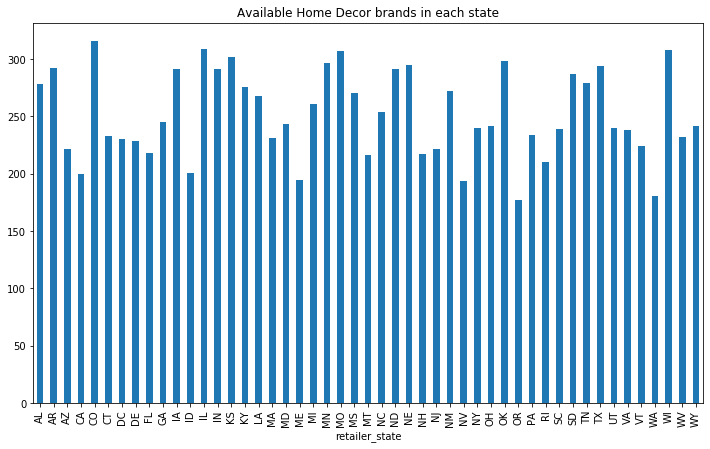

In [606]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

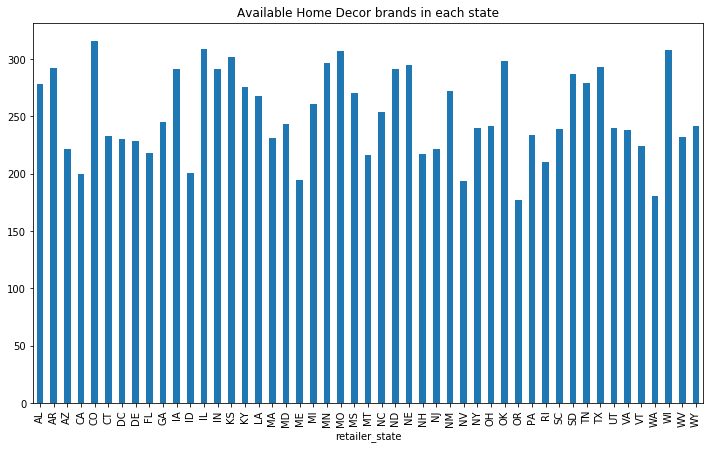

In [607]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_currently_eligible = df_subsidy.loc[df_subsidy['min_eligible_subsidy_bps']==0, :]
df_currently_eligible.loc[df_currently_eligible['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

In [608]:
df_top_final.groupby('retailer_state')['brand_id'].nunique().mean()

1622.857142857143

In [609]:
df_subsidy['min_eligible_subsidy_bps'] = df_subsidy['min_eligible_subsidy_bps'].astype(int)

In [610]:
df_subsidy.loc[df_subsidy['min_eligible_subsidy_bps']==0, :].groupby('retailer_state')['brand_id'].nunique().mean()

1622.6326530612246

In [611]:
[x for x in df_subsidy['retailer_state'].unique().tolist() 
 if x not in df_top_final['retailer_state'].unique().tolist()]

[]

In [612]:
df_to_write = df_subsidy[cols_to_write]

In [613]:
df_to_write = pd.concat([df_to_write, df_brands_low_zones[df_to_write.columns.tolist()]], axis=0)

In [614]:
df_to_write.dtypes

brand_id                      int64
retailer_state               object
min_eligible_subsidy_bps    float64
inserted_at                  object
dtype: object

In [617]:
df_to_write["min_eligible_subsidy_bps"] = df_to_write["min_eligible_subsidy_bps"].astype(int)

In [618]:
df_to_write.head()

,brand_id,retailer_state,min_eligible_subsidy_bps,inserted_at
250758,5954,VT,0,2020-02-22
98868,5954,CT,0,2020-02-22
210254,5954,NH,0,2020-02-22
7734,5954,ME,0,2020-02-22
119120,5954,MA,0,2020-02-22


In [619]:
filename = '/Users/pedrosalesdebruin/Development/data/insider_eligibility_with_subsidies.tsv'
df_to_write.to_csv(filename, index=None, sep='\t')

In [620]:
write_output_to_s3(filename, 'insider_eligibility_with_subsidies.tsv', bucket_name='faire.ranking')

INFO:faire.datascience.vendor.aws.s3._s3:Saving filename: /Users/pedrosalesdebruin/Development/data/insider_eligibility_with_subsidies.tsv to s3 to bucket_name: faire.ranking key: insider_eligibility_with_subsidies.tsv


In [621]:
from faire.datascience.vendor.aws.redshift import exec_sql

In [622]:
query_copy_to_redshift = \
"""
begin;
drop table if exists etl_datascience.insider_eligibility_with_subsidies;

create table etl_datascience.insider_eligibility_with_subsidies (
    brand_id                bigint,
    retailer_state          varchar(8),
    min_eligible_subsidy_bps int,
    inserted_at             date
) distkey (brand_id);
commit;


begin;
copy etl_datascience.insider_eligibility_with_subsidies
    from 's3://faire.analytics-etl-uploads/insider_eligibility_with_subsidies.csv'
    iam_role 'arn:aws:iam::632898149584:role/RedshiftCopyUnload'
    ignoreheader 1
    csv;
commit;
""" 

In [623]:
exec_sql(query_copy_to_redshift)

INFO:sqlalchemy.engine.base.Engine:/* INTERMIX_ID: eyJmb3JtYXQiOiAiaW50ZXJtaXgiLCAidmVyc2lvbiI6ICIxIiwgInBsdWdpbiI6ICJpbnRlcm1peC1weXRob24tcGx1Z2luIiwgInBsdWdpbl92ZXIiOiAiMC43IiwgImFwcCI6ICJkYXRhc2NpZW5jZS1kZWZhdWx0IiwgInVzZXIiOiAiIiwgImFwcF92ZXIiOiAiSEVBRCIsICJkYWciOiAiZGVmYXVsdCIsICJ0YXNrIjogImRlZmF1bHQiLCAiYXQiOiAiMjAyMC0wMi0yM1QwNDo0NDo1OC4yODI3MjdaIiwgImZpbGUiOiAiPGlweXRob24taW5wdXQtNjIzLWIxYmI0M2QxNTE5ND4iLCAibW9kdWxlIjogIl9fbWFpbl9fIiwgImNsYXNzbmFtZSI6ICIiLCAiZnVuY3Rpb24iOiAiPG1vZHVsZT4iLCAibGluZW51bWJlciI6ICIxIiwgIm1ldGEiOiB7fX0= */ 
begin;
drop table if exists etl_datascience.insider_eligibility_with_subsidies;

create table etl_datascience.insider_eligibility_with_subsidies (
    brand_id                bigint,
    retailer_state          varchar(8),
    min_eligible_subsidy_bps int,
    inserted_at             date
) distkey (brand_id);
commit;


begin;
copy etl_datascience.insider_eligibility_with_subsidies
    from 's3://faire.analytics-etl-uploads/insider_eligibility_with

In [ ]:
asdasdsad

#### Brand x state eligibility counts for different subsidy thresholds

In [ ]:
df_subsidy['eligible_0pct_subsidy'].astype(int).hist()

In [ ]:
rr_dict = df_gb.groupby("primary_brand_category")["macro_avg_return_rate"].mean().to_dict()

In [ ]:
rr_dict.keys()

In [ ]:
rr_dict['Accessories']

In [ ]:
return_rate_dictionary = (
    df_gb[["brand_id", "primary_brand_category", "macro_avg_return_rate"]]
    .groupby("primary_brand_category")["macro_avg_return_rate"]
    .mean()
).to_dict()

In [ ]:
return_rate_dictionary

In [ ]:
return_rate_dictionary["Jewelry"]

In [ ]:
df_gb["smoothed_return_rate"] = df_gb.apply(
    lambda x: (
        smoothing_strength * return_rate_dictionary[x["primary_brand_category"]]
        + x["num_rr_cured_brand_orders"] * x["macro_avg_return_rate"] )
    / (smoothing_strength + x["num_rr_cured_brand_orders"])
    , axis=1
)

In [ ]:
df_subsidy['eligible_20pct_subsidy'].astype(int).hist()

In [ ]:
df_subsidy['eligible_50pct_subsidy'].astype(int).hist()

In [ ]:
df_subsidy['eligible_80pct_subsidy'].astype(int).hist()

Can hardcode this to be 100% for everyone

In [ ]:
df_subsidy['eligible_100pct_subsidy'].astype(int).hist()

In [ ]:
df_subsidy['min_subsidy_100pct_coverage'] = np.nan

for s in range(100, -5, -10):
    df_subsidy.loc[(df_subsidy.groupby('brand_id')['eligible_'+str(s)+'pct_subsidy'].sum() == 51.0).values,
               'min_subsidy_100pct_coverage'] = s/100.0

In [ ]:
df_subsidy['min_subsidy_100pct_coverage'].hist(bins=21)

In [ ]:
df_subsidy['brand_id'].nunique()

## Validation of KF code:

In [ ]:
df_kf = pd.read_csv('/Users/pedrosalesdebruin/Development/datascience/apps/insider/data/insider_eligibility_with_subsidies.tsv', sep='\t')

In [ ]:
df_kf.isna().sum()

In [ ]:
df_kf['brand_id'] = df_kf['brand_id'].astype(int)
df_kf.head()

In [ ]:
df_kf.groupby('retailer_state')['brand_id'].nunique().hist()

In [ ]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

In [ ]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_currently_eligible = df_subsidy.loc[df_subsidy['min_eligible_subsidy_bps']==0, :]
df_currently_eligible.loc[df_currently_eligible['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

In [ ]:
df_brand.head()

In [ ]:
df_kf = df_kf.merge(df_brand, on='brand_id', how='inner')

In [ ]:
df_kf['brand_id'].nunique()

In [ ]:
df_currently_eligible["brand_id"].nunique()

In [ ]:
df_brands_low_zones['brand_id'].nunique()

In [ ]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_kf.loc[df_kf['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

In [ ]:
cat = 'Pets'
fig, ax = plt.subplots(figsize=(12,7));
df_kf.loc[df_kf['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

In [ ]:
cat = 'Kitchen'
fig, ax = plt.subplots(figsize=(12,7));
df_kf.loc[df_kf['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

# End of new block

<break/>

In [ ]:
asdasdasd

<break/>

## Write to file

In [ ]:
from datetime import datetime as dt

In [ ]:
df_to_write = df_top_final[['brand_id', 'retailer_state']].reset_index(drop=True).sort_values(by='brand_id')

### Append new brands in low zones to original final file

In [ ]:
df_brands_low_zones = df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone']<=4, :]

In [ ]:
df_to_write = pd.concat([df_to_write, df_brands_low_zones[df_to_write.columns.tolist()]], axis=0)

In [ ]:
df_brands_low_zones['brand_id'].nunique()

In [ ]:
df_top_final['brand_id'].nunique()

In [ ]:
df_to_write['brand_id'].nunique()

In [ ]:
df_brands_low_zones.groupby('retailer_state')['brand_id'].nunique().mean()

In [ ]:
df_top_final.groupby('retailer_state')['brand_id'].nunique().mean()

In [ ]:
df_to_write.groupby('retailer_state')['brand_id'].nunique().mean()

In [ ]:
# asdasad

In [ ]:
dt.today().strftime('%Y-%m-%d')

In [ ]:
df_to_write.loc[:, 'inserted_at'] = dt.today().strftime('%Y-%m-%d')

In [ ]:
out_path = '/Users/pedrosalesdebruin/Development/data/'

In [ ]:
filename = 'insider_v2_A.tsv'

In [ ]:
df_brands_low_zones['brand_id'].isna().sum()

In [ ]:
df_top_final['brand_id'].isna().sum()

In [ ]:
df_to_write['brand_id'].isna().sum()

In [ ]:
df_to_write['brand_id'] = df_to_write['brand_id'].astype(int)

In [ ]:
df_to_write.to_csv(out_path+filename, sep='\t', index=False)

In [ ]:
df_to_write.head()

In [ ]:
from faire.datascience.vendor.aws import s3, redshift

In [ ]:
s3.write_output_to_s3(
        '/Users/pedrosalesdebruin/Development/data/'+filename,
        filename,
        "faire.ranking",
    )

In [ ]:
df_top_final['brand_id'].nunique()

In [ ]:
df_to_write['brand_id'].nunique()

In [ ]:
df_to_write['retailer_state'].nunique()

In [ ]:
df_brands_low_zones.head(50)

## End

In [ ]:
asdasdasd

## Checking only brands with several brand orders

In [ ]:
df_val = pd.concat([df_test, y_test], axis=1)

In [ ]:
df_val.head()

In [ ]:
df_val = pd.concat([df_val.reset_index(), pd.Series(y_test_pred)], axis=1)

In [ ]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [ ]:
df_val.head()

In [ ]:
df_temp = df_val.loc[df_val['macro_avg_shipping_cost_fraction']>0, :]

((df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'prediction'] \
  - df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']) \
   / df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']
).hist(bins=25000)

plt.xlim(-3, 3);

In [ ]:
df_temp = df_val.loc[(df_val['macro_avg_shipping_cost_fraction']>0)
                     & (df_val['num_brand_orders_to_state']>10)
                     ,
                     :]

((df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'prediction'] \
  - df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']) \
   / df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']
).hist(bins=100)

plt.xlim(-3, 3);

In [ ]:
df_temp = df_val.loc[(df_val['macro_avg_shipping_cost_fraction']>0)
                     & (df_val['num_brand_orders_to_state']>15)
                     ,
                     :]

((df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'prediction'] \
  - df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']) \
   / df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']
).hist(bins=100)

plt.xlim(-3, 3);

## Plot predicted shipping costs given brand state

In [ ]:
b_state = 'CA'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_val.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['prediction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

In [ ]:
b_state = 'NY'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_val.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

## Regress on mean brand-state-CM

### Random Forest Regressor

### Reading Insider file

In [ ]:
final_df = pd.read_csv('/Users/pedrosalesdebruin/Downloads/insider_v2_A_latest.tsv', sep='\t')

In [ ]:
final_df.head()

In [ ]:
df_brands_low_zones.head()

In [ ]:
df_brands_low_zones['brand_id'].isin(final_df['brand_id']).sum()

In [ ]:
df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone']>3, :]

#### because I'm paranoid

In [ ]:
for b in df_brands_low_zones['brand_id'].unique().tolist():
    if b in final_df['brand_id'].unique().tolist():
        print('Repeated brand!')

In [ ]:
df_brands_low_zones.reset_index(drop=True, inplace=True)

In [ ]:
final_df = pd.concat([final_df, df_brands_low_zones[['brand_id', 'retailer_state']]], axis=0)

In [ ]:
final_df.isna().sum()

In [ ]:
final_df.loc[:, 'inserted_at'] = dt.today().strftime('%Y-%m-%d')

In [ ]:
final_df.isna().sum()

In [ ]:
filename = 'insider_v2_A.tsv'

In [ ]:
final_df.head()

In [ ]:
final_df = final_df[['brand_id', 'retailer_state', 'inserted_at']]

In [ ]:
final_df.head()

In [ ]:
final_df.to_csv(out_path+filename, sep='\t', index=False)

In [ ]:
print(out_path)

In [ ]:
# s3.write_output_to_s3(
#         out_path+filename,
#         filename,
#         "faire.ranking",
#     )

In [ ]:
final_df.head()

In [ ]:
final_df = pd.concat([final_df.reset_index(), pd.Series(y_test_pred)], axis=1)

In [ ]:
final_df.columns = final_df.columns.tolist()[:-1] + ['prediction']

In [ ]:
final_df.groupby('primary_brand_category')['prediction'].mean()

In [ ]:
final_df.groupby('mode_bs_postal_zone')['prediction'].mean()

## Validating file format

In [635]:
df_feb7 = pd.read_csv('/Users/pedrosalesdebruin/Downloads/insiderFiles/insider_eligibility_with_subsidies_feb7.tsv', sep='\t')

In [636]:
df_feb7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279304 entries, 0 to 279303
Data columns (total 4 columns):
brand_id                    279304 non-null int64
retailer_state              279304 non-null object
min_eligible_subsidy_bps    279304 non-null int64
inserted_at                 279304 non-null object
dtypes: int64(2), object(2)
memory usage: 8.5+ MB


In [642]:
df_feb7.isna().sum()

brand_id                    0
retailer_state              0
min_eligible_subsidy_bps    0
inserted_at                 0
dtype: int64

In [637]:
df_feb7.dtypes

brand_id                     int64
retailer_state              object
min_eligible_subsidy_bps     int64
inserted_at                 object
dtype: object

In [638]:
df_feb7.shape

(279304, 4)

In [639]:
df_feb17 = pd.read_csv('/Users/pedrosalesdebruin/Downloads/insiderFiles/insider_eligibility_with_subsidies_feb17.tsv', sep='\t')

In [641]:
df_feb17.isna().sum()

brand_id                    0
retailer_state              0
min_eligible_subsidy_bps    0
inserted_at                 0
dtype: int64

In [640]:
df_feb17.dtypes

brand_id                      int64
retailer_state               object
min_eligible_subsidy_bps    float64
inserted_at                  object
dtype: object

In [643]:
df_feb17.shape

(283946, 4)

In [645]:
df_feb22 =\
pd.read_csv('/Users/pedrosalesdebruin/Downloads/insiderFiles/insider_eligibility_with_subsidies_feb22.tsv', sep='\t')

In [646]:
df_feb22.isna().sum()

brand_id                    0
retailer_state              0
min_eligible_subsidy_bps    0
inserted_at                 0
dtype: int64

In [647]:
df_feb22.dtypes

brand_id                     int64
retailer_state              object
min_eligible_subsidy_bps     int64
inserted_at                 object
dtype: object

In [648]:
df_feb22.shape

(288913, 4)

In [649]:
df_feb22.head()

,brand_id,retailer_state,min_eligible_subsidy_bps,inserted_at
0,5954,VT,0,2020-02-22
1,5954,CT,0,2020-02-22
2,5954,NH,0,2020-02-22
3,5954,ME,0,2020-02-22
4,5954,MA,0,2020-02-22


In [651]:
df_feb17.head()

,brand_id,retailer_state,min_eligible_subsidy_bps,inserted_at
0,5954,VT,0.0,2020-02-17
1,5954,CT,0.0,2020-02-17
2,4912,GA,0.0,2020-02-17
3,5954,NH,0.0,2020-02-17
4,5954,MA,0.0,2020-02-17


In [650]:
df_feb7.head()

,brand_id,retailer_state,min_eligible_subsidy_bps,inserted_at
0,5954,VT,0,2020-02-06
1,5954,NH,0,2020-02-06
2,5954,CT,0,2020-02-06
3,4912,GA,0,2020-02-06
4,32760,MT,0,2020-02-06
